# Transcription Factor Extraction - TF Project Part 1
**Author:** Robin Anwyl

**Objective:** Read in Perturb-Seq hiPSC CRISPR KO scRNA-seq dataset from Mali Lab and extract the transcription factors from the full list of gene knockouts

## Determining which KOs are TF KOs

Extract the set of all gene knockouts from `crispr.var` and save as a .txt file.

In [ ]:
# crispr = mdata["crispr"]
# crispr_sgrnas = crispr.var.index.tolist()
# crispr_genes = {crispr_sgrnas[i][:-2] for i in range(len(crispr_sgrnas))}
# crispr_genes = sorted(list(crispr_genes))
# print(crispr_genes[:10])
# with open("gene_knockouts.txt", "w") as f:
#     for gene in crispr_genes:
#         f.write(gene + "\n")

Read the KO .txt file in.

In [ ]:
# with open("gene_knockouts.txt") as f:
#     gene_kos = f.read().split()
# print(gene_kos[:10])
# print(len(gene_kos))

### Comparing Perturb-seq KOs to human TFs from Lambert et al 2018 study

Lambert et al (2018) identified 1639 human transcription factors; this list of TFs is publicly available as a spreadsheet of each studied gene and whether or not it is a TF. 

Read in the spreadsheet and view the first few rows and columns:

In [ ]:
# lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
# print(lambert_csv.iloc[:10, :4])

Filter TFs from full list

In [ ]:
# lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# print(lambert_tfs[:10])
# print(len(lambert_tfs))

Find the intersection of the set of 11702 Perturb-seq KOs and the set of 1639 transcription factors

In [ ]:
# tfs = set(gene_kos) & set(lambert_tfs)
# tfs = list(tfs)
# tfs.sort()
# print(tfs[:10])
# print(len(tfs))

Some TFs in the Lambert set are missing from the gene KO set. To verify that this is indeed the case, use the Ensembl ID of each missing TF to find alternate gene names (synonyms), and search the gene KO set for these synonyms.

In [ ]:
# # Get missing TFs
# missing_tfs = set(lambert_tfs) - set(tfs)
# print(f"Lambert TFs not present in Perturb-seq KOs: {missing_tfs}")
# # Get Ensembl ID for each missing TF
# missing_tf_ensembl = lambert_csv[lambert_csv.iloc[:, 1].isin(missing_tfs)].iloc[:, 0].tolist()
# print(f"Ensembl IDs for Lambert TFs not in Perturb-seq KOs: {missing_tf_ensembl}")

# # Generate gene synonyms for each missing TF
# def get_ensembl_synonyms(ensembl_id):
#     # Use Ensembl REST API xrefs/id to search up gene synonyms for a given Ensembl ID
#     url = "https://rest.ensembl.org/xrefs/id/" + ensembl_id + "?content-type=application/json"
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         synonyms = list()
#         for xref in data:
#             if xref.get('synonyms'):
#                 synonyms.extend(xref['synonyms'])
#         return synonyms
#     else:
#         return f"Error fetching data for {ensembl_id}: {response.status_code}"
# synonym_list = []
# for id in missing_tf_ensembl:
#     alt_names = list(set(get_ensembl_synonyms(id)))
#     synonym_list.append(alt_names)
# print(f"Gene synonyms for Lambert TFs not in Perturb-seq KOs: {synonym_list}")

# # Search gene KO set for these synonyms
# alt_name_tfs = list()
# for gene_synonyms in synonym_list:
#     for synonym in gene_synonyms:
#         if synonym in gene_kos:
#             alt_name_tfs.append(synonym)
# print(f"TF gene synonyms present in Perturb-seq KOs: {alt_name_tfs}")

None of the synonyms were found in the Perturb-seq gene KO set; thus, the final set of TFs in common between the gene KO set and the Lambert TF set is 1610 TFs. Save the final set of TFs as a .txt file.

In [ ]:
# with open("tfs_1610.txt", "w") as f:
#     for tf in tfs:
#         f.write(tf + "\n")

## Extracting gene KOs from Perturb-Seq dataset
Read in the scRNA-seq dataset, which is a .h5mu file, and assign it to the variable `mdata`

In [ ]:
import mudata
mdata = mudata.read_h5mu("/home/data/Mali_project/KOLF_Pan_Genome_Aggregate.h5mu")

Rich representation of `mdata`, which is a `MuData` object

In [ ]:
with mudata.set_options(display_style = "html", display_html_expand = 0b000):
    display(mdata)

MuData object with n_obs × n_vars = 5386783 × 74595
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5386783 x 38606
      var:	'gene_ids', 'feature_types'
    crispr:	5386783 x 35989
      var:	'gene_ids', 'feature_types'

Access the `rna` cell-by-gene matrix and `crispr` cell-by-knockout matrix, which are `AnnData` objects.
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each gene in the human genome
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)

In [ ]:
rna_adata = mdata['rna']
crispr_adata = mdata['crispr']

`rna` and `crispr` both have `obs` and `var` attributes. 

- `obs` = cell barcodes associated with single cells; same for both `rna` and `crispr`  
- `rna.var` = human genes, `crispr.var` = gene knockouts

In [ ]:
rna_adata.var

gene_ids    feature_types
DDX11L2          ENSG00000290825  Gene Expression
MIR1302-2HG      ENSG00000243485  Gene Expression
FAM138A          ENSG00000237613  Gene Expression
ENSG00000290826  ENSG00000290826  Gene Expression
OR4F5            ENSG00000186092  Gene Expression
...                          ...              ...
ENSG00000277836  ENSG00000277836  Gene Expression
ENSG00000278633  ENSG00000278633  Gene Expression
ENSG00000276017  ENSG00000276017  Gene Expression
ENSG00000278817  ENSG00000278817  Gene Expression
ENSG00000277196  ENSG00000277196  Gene Expression

[38606 rows x 2 columns]

In [ ]:
crispr_adata.var

gene_ids         feature_types
A1BG_1    A1BG_1  CRISPR Guide Capture
A1BG_2    A1BG_2  CRISPR Guide Capture
A1BG_3    A1BG_3  CRISPR Guide Capture
A1CF_1    A1CF_1  CRISPR Guide Capture
A1CF_2    A1CF_2  CRISPR Guide Capture
...          ...                   ...
ZZEF1_2  ZZEF1_2  CRISPR Guide Capture
ZZEF1_3  ZZEF1_3  CRISPR Guide Capture
ZZZ3_1    ZZZ3_1  CRISPR Guide Capture
ZZZ3_2    ZZZ3_2  CRISPR Guide Capture
ZZZ3_3    ZZZ3_3  CRISPR Guide Capture

[35989 rows x 2 columns]

Get the list of all gene KOs (which can then be compared to a list of human TFs and narrowed down to only the TF KOs)

In [ ]:
crispr_sgrnas = crispr_adata.var.index.tolist()
crispr_genes = {crispr_sgrnas[i][:-2] for i in range(len(crispr_sgrnas))}
crispr_genes = sorted(list(crispr_genes))
print(crispr_genes[:10])
# with open("gene_knockouts.txt", "w") as f:
#     for gene in crispr_genes:
#         f.write(gene + "\n")

['A1BG', 'A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAMP', 'AAR2', 'AARD']


## Extracting list of human TFs from Lambert et al 2018 study

A 2018 study by Lambert et al identified 1639 human transcription factors; this list of TFs is publicly available as a spreadsheet. The spreadsheet includes each studied gene and whether or not it is a TF.

Read in spreadsheet

In [ ]:
import pandas as pd

lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
print(lambert_csv.iloc[:10, :4])

  Gene Information Unnamed: 1   Unnamed: 2 Is TF?
0               ID       Name          DBD    NaN
1  ENSG00000137203     TFAP2A         AP-2    Yes
2  ENSG00000008196     TFAP2B         AP-2    Yes
3  ENSG00000087510     TFAP2C         AP-2    Yes
4  ENSG00000008197     TFAP2D         AP-2    Yes
5  ENSG00000116819     TFAP2E         AP-2    Yes
6  ENSG00000117713     ARID1A  ARID/BRIGHT     No
7  ENSG00000049618     ARID1B  ARID/BRIGHT     No
8  ENSG00000116017     ARID3A  ARID/BRIGHT    Yes
9  ENSG00000179361     ARID3B  ARID/BRIGHT    Yes


Filter TFs from full list

In [ ]:
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
print(lambert_tfs[:10])
print(len(lambert_tfs))

['TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFAP2E', 'ARID3A', 'ARID3B', 'ARID3C', 'ARID5A', 'ARID5B']
1639


Sanity check: TF count is correct

## Comparing gene KOs to Lambert TFs

Read in gene KO file

In [ ]:
with open("gene_knockouts.txt") as f:
    gene_kos = f.read().split()
print(gene_kos)
print(len(gene_kos))

['A1BG', 'A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAMP', 'AAR2', 'AARD', 'AARS1', 'AARS2', 'AASDH', 'AASDHPPT', 'AASS', 'AATF', 'ABAT', 'ABCA2', 'ABCA3', 'ABCA7', 'ABCB10', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCC1', 'ABCC10', 'ABCC5', 'ABCD1', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABCG4', 'ABHD10', 'ABHD11', 'ABHD12', 'ABHD13', 'ABHD14B', 'ABHD15', 'ABHD16B', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD2', 'ABHD4', 'ABHD5', 'ABHD8', 'ABI1', 'ABI2', 'ABI3', 'ABITRAM', 'ABL1', 'ABL2', 'ABLIM1', 'ABRA', 'ABRACL', 'ABRAXAS1', 'ABRAXAS2', 'ABT1', 'ABTB1', 'ACAA1', 'ACAA2', 'ACACA', 'ACACB', 'ACAD10', 'ACAD8', 'ACAD9', 'ACADM', 'ACADS', 'ACADSB', 'ACADVL', 'ACAP1', 'ACAP2', 'ACAP3', 'ACAT1', 'ACAT2', 'ACBD3', 'ACBD4', 'ACBD5', 'ACBD6', 'ACBD7', 'ACCS', 'ACD', 'ACE', 'ACER2', 'ACER3', 'ACHE', 'ACIN1', 'ACKR1', 'ACLY', 'ACO1', 'ACO2', 'ACOT1', 'ACOT13', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOT8', 'ACOT9', 'ACOX1', 'ACP1', 'ACP2', 'ACP5', 'ACP6', 'ACSBG1', 'ACSBG2', 'ACSF2', 'A

Find the intersection of the set of 11702 gene knockouts and the set of 1639 transcription factors

In [ ]:
tfs = set(gene_kos) & set(lambert_tfs)
tfs = list(tfs)
tfs.sort()
print(tfs[:10])
print(len(tfs))

['ADNP', 'ADNP2', 'AEBP1', 'AEBP2', 'AHCTF1', 'AHDC1', 'AHR', 'AHRR', 'AIRE', 'AKAP8']
1610


### Verifying difference between Lambert set (1639 TFs) and Perturb-seq TF set (1610 TFs)

There are some TFs in the Lambert set that are missing from the gene KO set. To verify that this is the case, use the Ensembl ID of each missing TF to find alternate gene names (synonyms), and search the gene KO set for these synonyms.

In [ ]:
missing_tfs = set(lambert_tfs) - set(tfs)
print(missing_tfs)
missing_tf_ensembl = lambert_csv[lambert_csv.iloc[:, 1].isin(missing_tfs)].iloc[:, 0].tolist()
print(missing_tf_ensembl)

{'AC023509.3', 'ZNF705G', 'ZNF645', 'ZNF547', 'ARNTL', 'ZNF117', 'CENPBD1', 'ZNF788', 'DUX3', 'HKR1', 'CCDC169-SOHLH2', 'EEA1', 'DUX1', 'C11orf95', 'ZIM2', 'ARNTL2', 'ZNF705E', 'T', 'ZNF385D', 'ZBED9', 'AC008770.3', 'ZUFSP', 'PHF19 ', 'AC138696.1', 'ZNF286B', 'MSANTD1', 'MBNL2', 'BORCS8-MEF2B', 'AC092835.1'}
['ENSG00000188070', 'ENSG00000232040', 'ENSG00000133794', 'ENSG00000029153', 'ENSG00000250709', 'ENSG00000267281', 'ENSG00000267179', 'ENSG00000233757', 'ENSG00000264668', 'ENSG00000102189', 'ENSG00000181666', 'ENSG00000269699', 'ENSG00000152926', 'ENSG00000249459', 'ENSG00000151789', 'ENSG00000152433', 'ENSG00000175809', 'ENSG00000214534', 'ENSG00000215372', 'ENSG00000214189', 'ENSG00000153975', 'ENSG00000139793', 'ENSG00000177946', 'DUX1_HUMAN', 'DUX3_HUMAN', 'ENSG00000188981', 'ENSG00000064489', 'ENSG00000119403', 'ENSG00000164458']


Using the Ensembl REST API, GET lookup/id did not return any synonyms, so try GET xrefs/id to cross-reference other databases.

In [ ]:
import requests

def get_ensembl_synonyms(ensembl_id):
    # Use Ensembl REST API xrefs/id to search up gene synonyms for a given Ensembl ID
    url = "https://rest.ensembl.org/xrefs/id/" + ensembl_id + "?content-type=application/json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        synonyms = list()
        for xref in data:
            if xref.get('synonyms'):
                synonyms.extend(xref['synonyms'])
        return synonyms
    else:
        return f"Error fetching data for {ensembl_id}: {response.status_code}"

# Store gene synonyms as a nested list
synonym_list = []
for id in missing_tf_ensembl:
    alt_names = list(set(get_ensembl_synonyms(id)))
    synonym_list.append(alt_names)
print(synonym_list)

[['MGC3032', 'C11ORF95'], ['FLJ31087', 'KIAA1925', 'BUSTER4', 'ZFP38-L', 'ZNF305P2', 'ZNF452', 'ZBED9', 'FAM200D'], ['ARNTL1', 'JAP3', 'BHLHE5', 'ARNTL', 'MOP3', 'PASD3'], ['BHLHE6', 'MOP9', 'ARNTL2', 'PASD9', 'CLIF'], ['C13ORF38-SOHLH2'], [], [], [], [], ['ZFYVE2'], ['HKR1'], ['ZNF656'], ['H-PLK', 'HPF9'], ['ZNF286C', 'ZNF590', 'ZNF286L'], ['FLJ22419', 'ZNF659'], ['FLJ31100'], ['HAKAIL', 'ZNF645', 'FLJ25735', 'CT138'], ['ZNF705E'], [], ['ZNF788', 'FLJ46419'], ['C6ORF113', 'ZUFSP', 'DJ412I7.3'], ['MBLL', 'MBLL39'], ['CENPBD1', 'MGC16385'], ['M', '0', 'e', 'X', 'h', 'c', 'A', 'N', 'g', '4', 'n', 'i', 't', ':', 'H', '1', 'E', 'D', 'd', 'f', '_', ' ', 'a', 'r', 'U', 'o'], ['M', '0', 'e', 'X', 'h', 'c', 'A', 'N', 'g', '4', 'n', 'i', 't', ':', 'H', 'E', 'D', 'd', '3', 'f', '_', ' ', 'a', 'r', 'U', 'o'], ['C4ORF44', 'LOC345222'], ['MEF2BNB-MEF2B'], ['MTF2L1', 'TDRD19B', 'DKFZP727G051', 'PCL3'], ['T']]


Synonyms were found for all genes except DUX1 and DUX3. A manual Google search was performed for DUX1 and DUX3 and found no synonyms. Next, search the gene KO list for these gene synonyms.

In [ ]:
alt_name_tfs = list()
for gene_synonyms in synonym_list:
    for synonym in gene_synonyms:
        if synonym in gene_kos:
            alt_name_tfs.append(synonym)
print(alt_name_tfs)

[]


None of the synonyms were found in the Perturb-seq gene KO set; thus, the final set of TFs in common between the gene KO set and the Lambert TF set is 1610 TFs.

### Saving the TF list

Save the list of 1610 TFs in the gene KO set as a .txt file

In [ ]:
# with open("tfs_1610.txt", "w") as f:
#     for tf in tfs:
#         f.write(tf + "\n")

***
# Transcription Factor Analysis - TF Project Part 2

**Author:** Robin Anwyl

**Objective:** 1610 transcription factors were identified from the set of Perturb-Seq gene knockouts. The next broad goal of the project is to build a transcription factor interaction network. The methodology for building the TF interaction network will depend on what information is specifically included in the Perturb-seq dataset. In this notebook, we will take a closer look at the dataset.

Import packages

In [ ]:
import mudata as md
import anndata as ad
import rapids_singlecell as rsc
import scanpy as sc
import pandas as pd
import numpy as np
import re

Read in Perturb-seq dataset and add sgRNA metadata to cell barcodes

In [ ]:
mdata = md.read_h5mu("/home/data/Mali_project/KOLF_Pan_Genome_Aggregate.h5mu")

/home/ranwyl/.conda/envs/rsc_env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/ranwyl/.conda/envs/rsc_env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
rna = mdata['rna']
print(rna)

AnnData object with n_obs × n_vars = 5386783 × 38606
    var: 'gene_ids', 'feature_types'


In [ ]:
protospacer_calls = pd.read_csv("/home/data/Mali_project/protospacer_calls_per_cell.csv", index_col=0)

num_features               feature_call num_umis
cell_barcode                                                         
TGCGACGTCAACTCTT-24             1                    ADNP2-1       20
AACGTCACATAATCCG-25             2        ADNP2-1|MACROH2A2-1    11|11
ACGCACGAGCCTATTG-25             2  ADNP2-1|Non-Targeting-498    21|22
AGAGCCCCACGCTGCA-25             1                    ADNP2-1       44
AGGGTTTGTTACCCAA-25             2           ADNP2-1|ZNF33A-3     7|19

In [ ]:
print(rna.obs.index[:5])
print(print(protospacer_calls.index[:5]))
print(len(rna.obs))
print(len(protospacer_calls))

Index(['AAACCCAAGAAACCCG-34', 'AAACCCAAGAAACCCG-75', 'AAACCCAAGAAACTAC-10',
       'AAACCCAAGAAACTCA-14', 'AAACCCAAGAAACTCA-2'],
      dtype='object')
Index(['CAGAGCCTCCGGACGT-31', 'CATTGCCTCTTGGGCG-31', 'TGATCTTTCAATGTCG-31',
       'TTGTGGAAGGTTGGAC-31', 'ACATGCACACATACGT-32'],
      dtype='object', name='cell_barcode')
None
5386783
4369394


In [ ]:
rna_barcodes = rna.obs.index
protospacer_barcodes = protospacer_calls.index
# Filter RNA to include only barcodes present in the protospacer file
filtered_barcodes = rna_barcodes[rna_barcodes.isin(rna_barcodes, protospacer_barcodes)]
rna_filtered = rna[filtered_barcodes, :]
# Sort both the RNA and protospacer datasets by barcode
rna_filtered_sorted = rna_filtered[filtered_barcodes.sort()]
protospacer_calls_sorted = protospacer_calls.loc[filtered_barcodes.sort()]
# Align protospacer metadata (sgRNAs) to rna.obs
rna_filtered_sorted.obs['sgRNA'] = protospacer_calls_sorted['feature_call']

Read in TFs

In [ ]:
with open("tfs_1610.txt") as f:
    tfs = f.read().split()
print(tfs[:100])
print(len(tfs))

['ADNP', 'ADNP2', 'AEBP1', 'AEBP2', 'AHCTF1', 'AHDC1', 'AHR', 'AHRR', 'AIRE', 'AKAP8', 'AKAP8L', 'AKNA', 'ALX1', 'ALX3', 'ALX4', 'ANHX', 'ANKZF1', 'AR', 'ARGFX', 'ARHGAP35', 'ARID2', 'ARID3A', 'ARID3B', 'ARID3C', 'ARID5A', 'ARID5B', 'ARNT', 'ARNT2', 'ARX', 'ASCL1', 'ASCL2', 'ASCL3', 'ASCL4', 'ASCL5', 'ASH1L', 'ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'ATF6', 'ATF6B', 'ATF7', 'ATMIN', 'ATOH1', 'ATOH7', 'ATOH8', 'BACH1', 'BACH2', 'BARHL1', 'BARHL2', 'BARX1', 'BARX2', 'BATF', 'BATF2', 'BATF3', 'BAZ2A', 'BAZ2B', 'BBX', 'BCL11A', 'BCL11B', 'BCL6', 'BCL6B', 'BHLHA15', 'BHLHA9', 'BHLHE22', 'BHLHE23', 'BHLHE40', 'BHLHE41', 'BNC1', 'BNC2', 'BPTF', 'BRF2', 'BSX', 'CAMTA1', 'CAMTA2', 'CARF', 'CASZ1', 'CBX2', 'CC2D1A', 'CCDC17', 'CDC5L', 'CDX1', 'CDX2', 'CDX4', 'CEBPA', 'CEBPB', 'CEBPD', 'CEBPE', 'CEBPG', 'CEBPZ', 'CENPA', 'CENPB', 'CENPS', 'CENPT', 'CENPX', 'CGGBP1', 'CHAMP1', 'CHCHD3', 'CIC']
1610


## Subsetting single-TF KO and non-targeting control samples

For this project, we only want to consider single-TF knockout and non-targeting control (NTC) samples. The CRISPR perturbation metadata file "protospacer_calls_per_cell.csv" contains information on which CRISPR guide RNA(s) each cell received. First, we will read in and view the file.

Next, we will use the sgRNA-per-cell information and the list of 1610 TFs to generate a subset of cell barcodes corresponding to single-TF KO and NTC cell samples only.

In [ ]:

tfs = set(tfs)
# Filter function
def is_single_tf_or_ntc(feature_call):
    # Return True if feature_call is a single TF KO or single non-targeting gRNA
    if "|" not in feature_call:
        if re.match(r"Non-Targeting-\d+", feature_call) or feature_call[:-2] in tfs:
            return True
    # Return True if feature_call is a single TF KO and one or more non-targeting gRNAs
    guide_rnas = set(feature_call.split("|"))
    tf_kos, nt_rnas = set(), set()
    for g in guide_rnas:
        if re.match(r"Non-Targeting-\d+", g):
            nt_rnas.add(g)
        elif g[:-2] in tfs:
            tf_kos.add(g)
    if (guide_rnas - tf_kos - nt_rnas): # Return False if any gRNAs are not TFs or NTs
        return False
    if len(tf_kos) == 1:
        return True
    else:
        return False
# Test the filter function on a representative subset of file
test_df = protospacer_df[108885:110000]
filter_test = test_df[test_df["feature_call"].apply(is_single_tf_or_ntc)]
display(filter_test)

cell_barcode  num_features               feature_call num_umis
108885  TGCGACGTCAACTCTT-24             1                    ADNP2-1       20
108887  ACGCACGAGCCTATTG-25             2  ADNP2-1|Non-Targeting-498    21|22
108888  AGAGCCCCACGCTGCA-25             1                    ADNP2-1       44
108891  ATTACTCGTCCACGCA-25             1                    ADNP2-1        9
108894  CACTGAATCAAAGAAC-25             1                    ADNP2-1       24
...                     ...           ...                        ...      ...
109976  TGAGGGAAGCGCCTCA-28             1                    ADNP2-3       40
109979  TTCTAGTGTCACTTCC-28             1                    ADNP2-3       49
109989  GACTTCCAGCACTCTA-29             2  ADNP2-3|Non-Targeting-923      4|5
109992  GGATGTTTCTTACGTT-29             1                    ADNP2-3       77
109999  TTCCTCTAGCATCCTA-29             1                    ADNP2-3        4

[485 rows x 4 columns]

Save the list of cell barcodes in "filtered_barcodes.txt"

In [ ]:
# Run filter function and save list of cell barcodes as .txt file
# filtered_df = protospacer_df[protospacer_df["feature_call"].apply(is_single_tf_or_ntc)]
# filtered_barcodes = filtered_df["cell_barcode"]
# with open("filtered_barcodes.txt", "w") as f:
#     for barcode in filtered_barcodes:
#         f.write(f"{barcode}\n")

Read in "filtered_barcodes.txt" to get the list of cell barcodes corresponding to single-TF KO or NTC samples.

In [ ]:
with open("filtered_barcodes.txt") as f:
    barcodes = f.read().split()
print(barcodes[:10])
print(len(barcodes))

['CATTGTTCACAGTGAG-1', 'CCCTCTCAGGTTCATC-1', 'CCTTTGGGTAACCCTA-2', 'CGCCATTGTTCGTTCC-2', 'GATGCTACATCGCCTT-2', 'GGTGTTAAGGTCGTGA-3', 'TGAATCGAGTATCTGC-3', 'GAGGGTATCCGCTGTT-4', 'GCTCAAATCGAGCACC-7', 'GGGCGTTTCGATTTCT-7']
628136


Out of the 5,386,783 cells in the dataset, 628,136 correspond to single-TF knockouts or NTC samples.

We also want to differentiate between NTC and single-TF KO samples. First, we will write a filter function for NTC samples.

In [ ]:
tfs = set(tfs)
# Filter function for NTC samples
def is_ntc(feature_call):
    # Return True if feature_call is a single non-targeting gRNA
    if "|" not in feature_call:
        if re.match(r"Non-Targeting-\d+", feature_call):
            return True
    # Return True if feature_call is multiple non-targeting gRNAs
    guide_rnas = set(feature_call.split("|"))
    nt_rnas = set()
    for g in guide_rnas:
        if re.match(r"Non-Targeting-\d+", g):
            nt_rnas.add(g)
    if len(guide_rnas) == len(nt_rnas): # Return True if all gRNAs are non-targeting
        return True
    else:
        return False
# Test NTC filter function on a representative subset of file
test_df = protospacer_df[2768320:2768328]
filter_test = test_df[test_df["feature_call"].apply(is_ntc)]
display(filter_test)

cell_barcode  num_features     feature_call num_umis
2768323  TGAGCATTCCATTCAT-1             1  Non-Targeting-1       84
2768324  AAACGCTAGGTGCTGA-2             1  Non-Targeting-1       30
2768325  AGTAACCCACCGAATT-2             1  Non-Targeting-1        9
2768326  CAACAGTGTCCGAAAG-2             1  Non-Targeting-1        5

Save the NTC cell barcodes in a .txt file.

In [ ]:
# Run TF KO filter function and save list of cell barcodes as .txt file
# filtered_df = protospacer_df[protospacer_df["feature_call"].apply(is_single_tf)]
# filtered_barcodes = filtered_df["cell_barcode"]
# with open("filtered_barcodes.txt", "w") as f:
#     for barcode in filtered_barcodes:
#         f.write(f"{barcode}\n")

## Cell-By-TF UMAP

### Setup and Preprocessing

In this section, we will narrow down the cell-by-gene matrix to a cell-by-TF matrix and perform UMAP analysis. First, we will create a new AnnData object for the cell-by-TF matrix.

In [ ]:
rna = mdata['rna']
# Filter cells (single-TF KOs or NTC samples)
filtered_cells = rna.obs.index.isin(barcodes)
rna_filtered = rna[filtered_cells, :]
# Filter genes (TFs)
filtered_genes = rna_filtered.var.index.isin(tfs)
rna_cell_by_tf = rna_filtered[:, filtered_genes]
# Create a new AnnData object for filtered dataset
rna_cell_by_tf = ad.AnnData(rna_cell_by_tf.X, obs=rna_cell_by_tf.obs.copy(), var=rna_cell_by_tf.var.copy())

Save this AnnData object as a .h5ad file.

In [ ]:
#rna_cell_by_tf.write("/home/data/Mali_project/cell_by_tf.h5ad")

Read in cell-by-TF .h5ad file.

In [ ]:
cell_by_tf = ad.read_h5ad("/home/data/Mali_project/cell_by_tf.h5ad")

Transfer AnnData object to GPU.

In [ ]:
rsc.get.anndata_to_GPU(cell_by_tf)

Perform QC and preprocessing.

In [ ]:
rsc.pp.calculate_qc_metrics(cell_by_tf)

Generate violin plots.

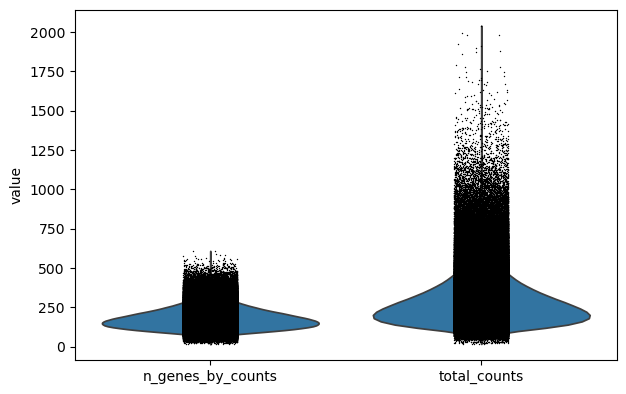

In [ ]:
sc.pl.violin(cell_by_tf, ["n_genes_by_counts", "total_counts"])

In [ ]:
print(f"shape before removing genes with zero expression: {cell_by_tf.shape}")
cell_by_tf = cell_by_tf[:, cell_by_tf.X.sum(axis=0) > 0]
cell_by_tf = cell_by_tf.copy()
print(f"shape after: {cell_by_tf.shape}")

shape before removing genes with zero expression: (628136, 1610)
shape after: (628136, 1590)


Of the 1610 TFs that were knocked out in the dataset, only 1590 are expressed in the single-TF-KO and NTC subset.

## PCA, Neighbors, and UMAP

Now we will perform PCA to reduce dimensionality of the data.

In [ ]:
rsc.pp.pca(cell_by_tf)

W will generate an elbow plot to inspect the contribution of single principal components (PCs) to the total variance in the data. This gives us information on how many PCs to consider in future analysis.

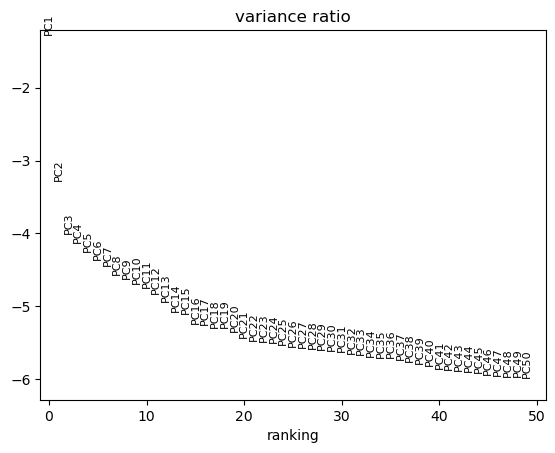

In [ ]:
sc.pl.pca_variance_ratio(cell_by_tf, n_pcs=50, log=True)

We will also visualize the first 10 PCs.

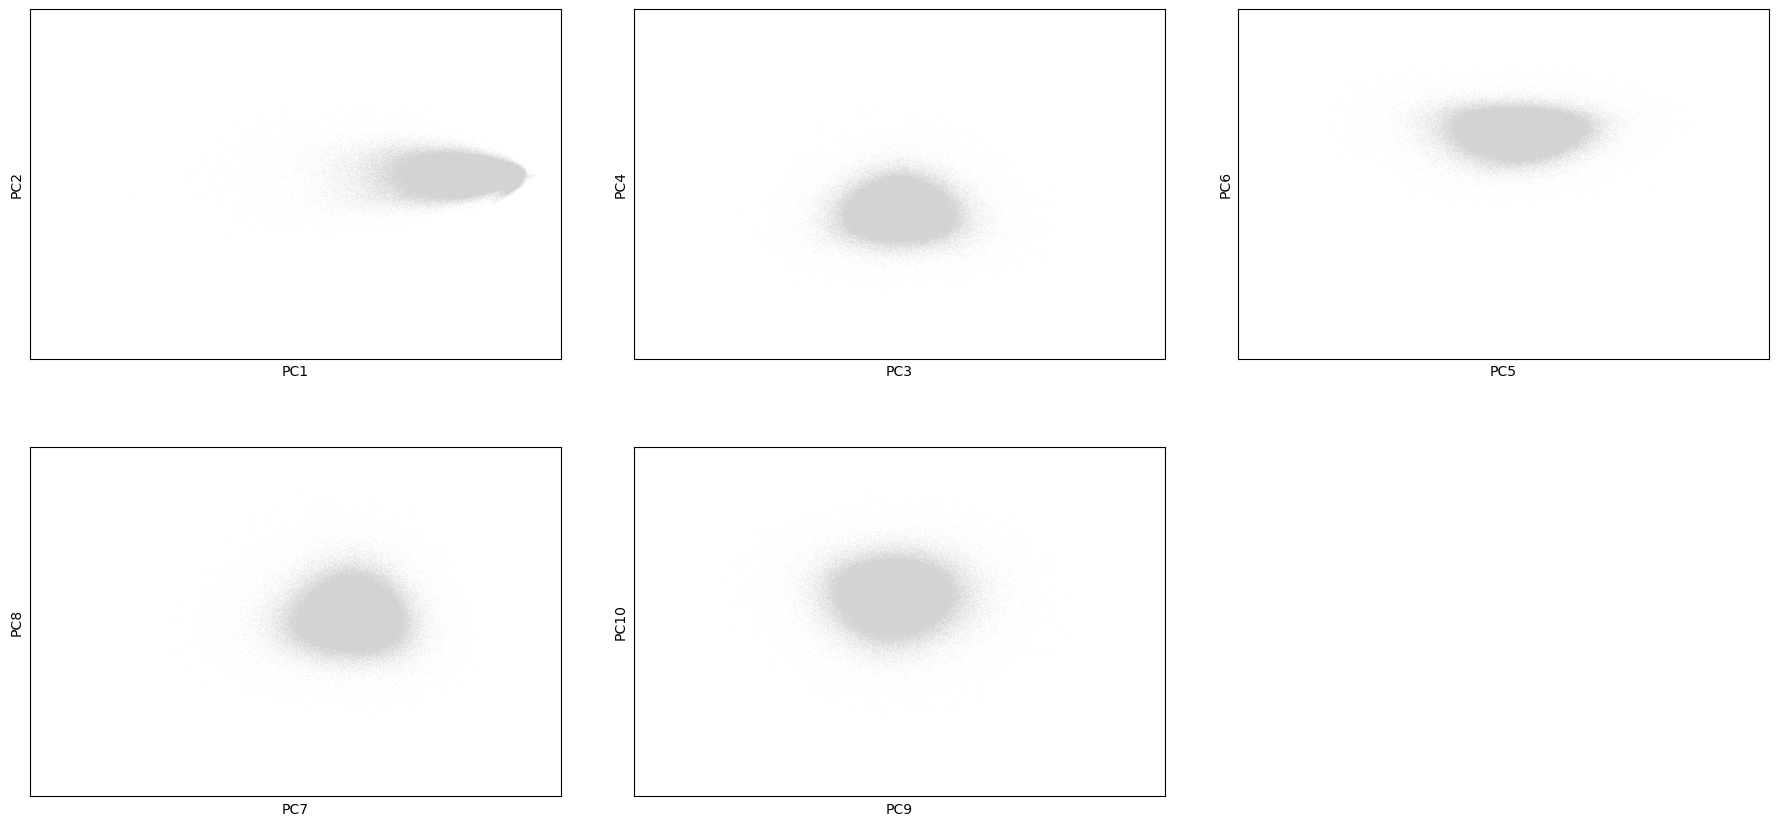

In [ ]:
sc.pl.pca(cell_by_tf, dimensions=[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)], ncols = 3)

Now that we have performed PCA, we will compute the neighborhood graph of the cell-by-TF matrix.

In [ ]:
rsc.pp.neighbors(cell_by_tf)

Next, we will embed the neighborhood graph for UMAP visualization. Based on the PCA elbow plot, we will use 20 principal components for UMAP.

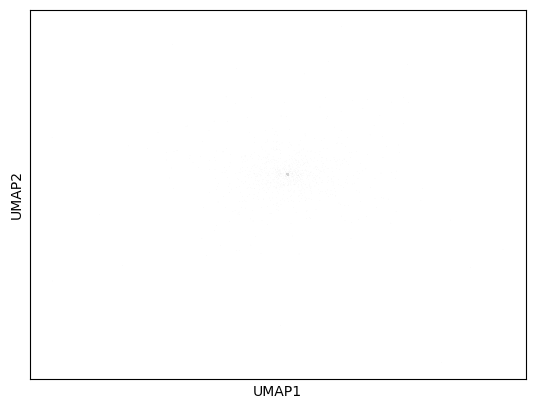

In [ ]:
rsc.tl.umap(cell_by_tf, n_components=20)
sc.pl.umap(cell_by_tf)

We will try UMAP embedding and visualization again without specifying n_components.

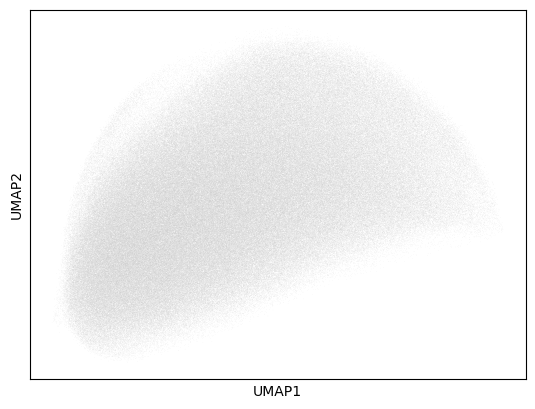

In [ ]:
rsc.tl.umap(cell_by_tf)
sc.pl.umap(cell_by_tf)

Perform Leiden clustering on the full UMAP.

In [ ]:
rsc.tl.leiden(cell_by_tf)

Visualize the UMAP after clustering.

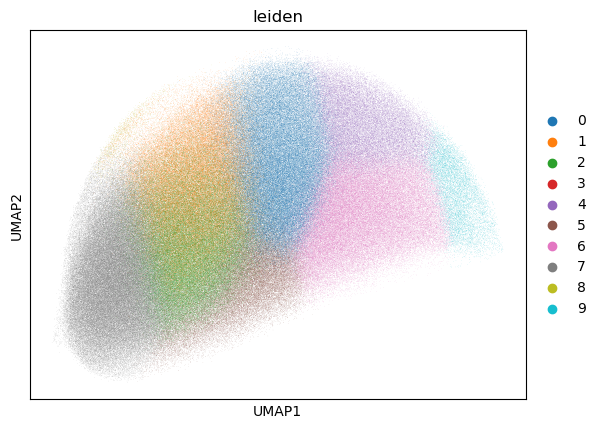

In [ ]:
sc.pl.umap(cell_by_tf, color=["leiden"])

We will now obtain the cluster-specific differentially expressed genes (DEGs). We will display 20 genes per cluster.

In [ ]:
rsc.tl.rank_genes_groups_logreg(cell_by_tf, groupby="leiden", n_genes=20)

[W] [16:52:52.156537] L-BFGS: max iterations reached
[W] [16:52:52.158238] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


## TF KO Differentially Expressed Genes

In this section, we will perform differential expression analysis to find the differentially expressed genes (DEGs) for each TF KO.

***
# QC tests

Note: A list of cell barcodes and genes that passed QC through step D was provided. However, the following discrepancies were noticed:
-  The number of genes in the list (38606) was equal to the number of genes in the original dataset, but greater than the actual number of genes that passed QC step C in Pan_Genome_Analysis.ipynb (37567)
-  The list of cells should only include perturbed cells and core NTC cells. The number of NTC cells in the list (38490) is greater than the number of core NTC cells in Pan_Genome_Analysis.ipynb (37433).

## OLD Filtering cells and genes that passed QC

The Mali lab provided a list of cell barcodes and genes that passed step D of the study workflow: QC, preprocessing, and isolation of core non-targeting control (NTC) cells. We will filter the RNA modality, `adata`, to include only the QC-passed cell barcodes and genes and save this as a `.h5ad` file for further analysis. This will be done instead of running the pipeline for the rest of step C and for step D.

Read in `AnnData` object with sgRNAs and metadata assigned:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Pan_Genome_Basic_QC.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Read in the lists of cell barcodes and genes that passed QC and preprocessing:

In [ ]:
# Get list of cell barcodes that passed QC and preprocessing
cells_file_path = "/home/ranwyl/data_tf_project/adata_QC_obs_names.txt"
with open(cells_file_path) as f:
    barcodes_qc = f.read().split()
barcodes_qc = barcodes_qc[1:]
print(barcodes_qc[:5])
print(f"Initial number of cells: {len(adata.obs)}")
print(f"Number of cells that passed QC + preprocessing: {len(barcodes_qc)}")

# Get list of genes that passed QC and preprocessing
genes_file_path = "/home/ranwyl/data_tf_project/adata_QC_var_names.txt"
with open(genes_file_path) as f:
    genes_qc = f.read().split()
genes_qc = genes_qc[1:]
print(genes_qc[:10])
print(f"Initial number of genes: {len(adata.var)}")
print(f"Number of genes that passed QC + preprocessing: {len(genes_qc)}")

['AAACCCAAGAGTGTTA-1', 'AAACCCAAGCAGGCTA-1', 'AAACCCAAGCAGGTCA-1', 'AAACCCAAGTTATGGA-1', 'AAACCCACAAAGCTAA-1']
Initial number of cells: 2735450
Number of cells that passed QC + preprocessing: 2622329
['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599']
Initial number of genes: 38606
Number of genes that passed QC + preprocessing: 38606


The `Pan_Genome_Analysis.ipynb` notebook says that 1039 genes were removed that were not expressed in any cells, so we will run the `general_qc()` to remove these genes.

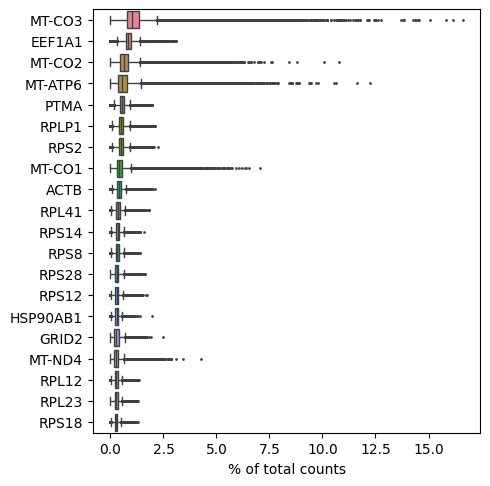

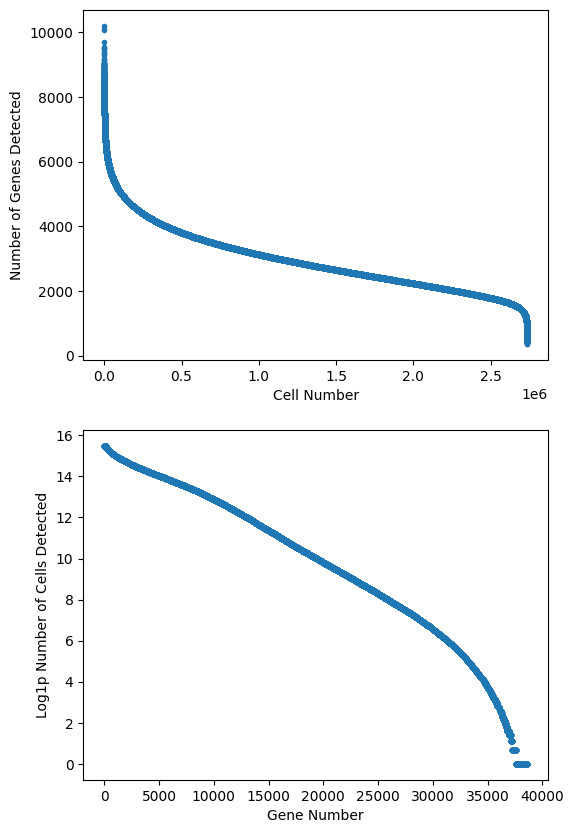

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

Now we will filter the cell barcodes. First, we will add a "QC" column to `adata` indicating whether each cell barcode passed QC ("Pass") or not ("Fail"). Then we will filter for the cell barcodes that have "Pass" in the "QC" column.

In [ ]:
adata.obs["QC"] = np.where(adata.obs_names.isin(set(barcodes_qc)), "Pass", "Fail")
adata_filtered = adata[adata.obs["QC"] == "Pass"].copy()

/tmp/ipykernel_2683868/1081968684.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Add a `run` metadata column to `.obs`:

In [ ]:
adata_filtered.obs["run"] = [label.split('-')[0] for label in adata_filtered.obs.channel]

In [ ]:
adata_filtered

AnnData object with n_obs × n_vars = 2622329 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Save the QC-passed and metadata-annotated `AnnData` object:

In [ ]:
adata_filtered.write("/home/ranwyl/data_tf_project/adata_QC.h5ad")

Now that we have filtered the cells based on the list from the Mali lab and filtered the genes using a pipeline function, we want to complete steps E and F of the data analysis workflow, which will be performed on the subset of core NTC cells.
-  Step E: Isolate effective single guide RNA (sgRNA)
-  Step F: 1) Isolate sgRNA altering cell state 2) Isolate perturbed cells

Note: functions written in the `Pan_Genome_Analysis.ipynb` file from figshare have been pasted into a file `pan_genome_analysis_functions.py` that is imported as `qc2`

First, we need to take the `AnnData` object that is the output of step D and subset the NTC cells.

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/adata_QC.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 2622329 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

In [ ]:
adata[adata.obs.perturbed == "False"]

View of AnnData object with n_obs × n_vars = 38490 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

The number of NTC cells in `adata` (38490) is higher than the number of core NTC cells in `Pan_Genome_Analysis.ipynb` (37433). Due to this discrepancy, it would be best to run the pipeline myself.

## Cell-by-TF UMAP

After QC, preprocessing, and normalization have been performed, we will now generate the cell-by-TF UMAP. We will subset the genes that are in the list of TFs from Lambert et al (2018). Then we will carry out feature selection, scaling, PCA, and use the PCA "elbow plot" to determine which principal components to use for further analysis.

Experiment: do we subset TFs before feature selection and do feature selection with 1639 genes, then do PCA?
Or do we do feature selection with 2000 genes as normal (TFs should be in here), run PCA, and then subset the TFs?

In [ ]:
# Get list of 1639 Lambert TFs
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# Subset genes that are TFs
filtered_genes = adata.var.index.isin(tfs)
adata_cell_by_tf = adata[:, filtered_genes]


Now that we have determined the number of PCs to use, we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization, perform Leiden clustering, and visualize the UMAP.

***

# UMAP on QC-passed strong perturbation dataset

# UMAP code (old)

## UMAP of all strong perturbations, no LFC filter for DEGs

Now we want to visualize the UMAP embedding of the QC-passed dataset to see which KOs cluster together.

In [ ]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

The preprocessing steps of normalization (in this case, to the median UMI count of NTC cells) and log1p transformation have already been performed. The data has also been z-normalized as part of batch correction, so scaling does not need to be performed. We will perform feature selection using a pipeline function that implements batch-aware highly variable gene (HVG) selection. This function takes an `AnnData` object and a `DataFrame` of DEGs and returns a subset of the input `AnnData` object containing only the HVGs. By default, the function considers the top 20 upregulated and top 20 downregulated DEGs for each perturbation, and finds 2000 additional HVGs with the `scanpy` `highly_variable_genes` method.

In [ ]:
adata = qc2.create_HVG_set_top_n_degs(adata, deg_df)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Constructing a set of 5017 unique HVGs from 3521 unique DEGs and 2000 unique HVGs


In [ ]:
adata

AnnData object with n_obs × n_vars = 111902 × 5017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

View and save the perturbation-associated DEGs:

In [ ]:
pert_assoc_degs = adata.var.index.tolist()
print(len(pert_assoc_degs))
print(pert_assoc_degs[:10])

5017
['PUSL1', 'AURKAIP1', 'CCNL2', 'MRPL20', 'SSU72', 'GNB1', 'CFAP74', 'SKI', 'HES5', 'ENSG00000272235']


In [ ]:
with open("/home/ranwyl/results_tf_project/perturbation_associated_DEGs.txt", "w") as f:
    for deg in pert_assoc_degs:
        f.write(f"{deg}\n")

Now we will perform PCA and visualize the elbow plot to determine how many PCs to use for k-nearest neighbors computation.

computing PCA
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


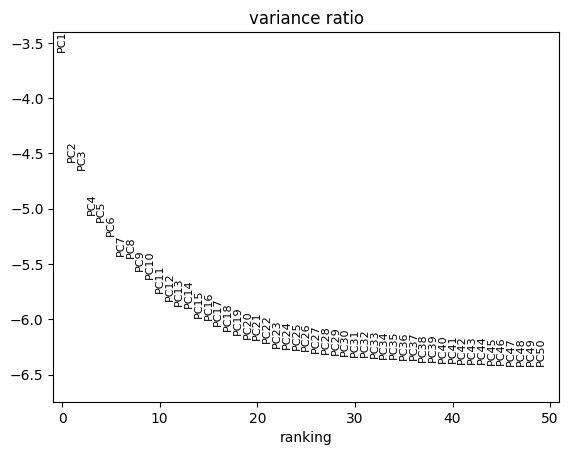

In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True) #Elbow plot

Based on the elbow plot, we will use the first 30 PCs to compute the neighborhood. Now we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization.

In [ ]:
num_pcs = 30 # Change this to desired number of principal components
sc.pp.neighbors(adata, n_pcs=num_pcs)
sc.tl.umap(adata)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:31)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:09)


We will perform Leiden clustering at a few different resolutions and see how many clusters there are at each resolution. Ideally we would have about 10 clusters with a reasonable amount of TF KOs per cluster and a reasonable count for each TF KO.

In [ ]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:03)


Visualize the UMAP for each resolution:

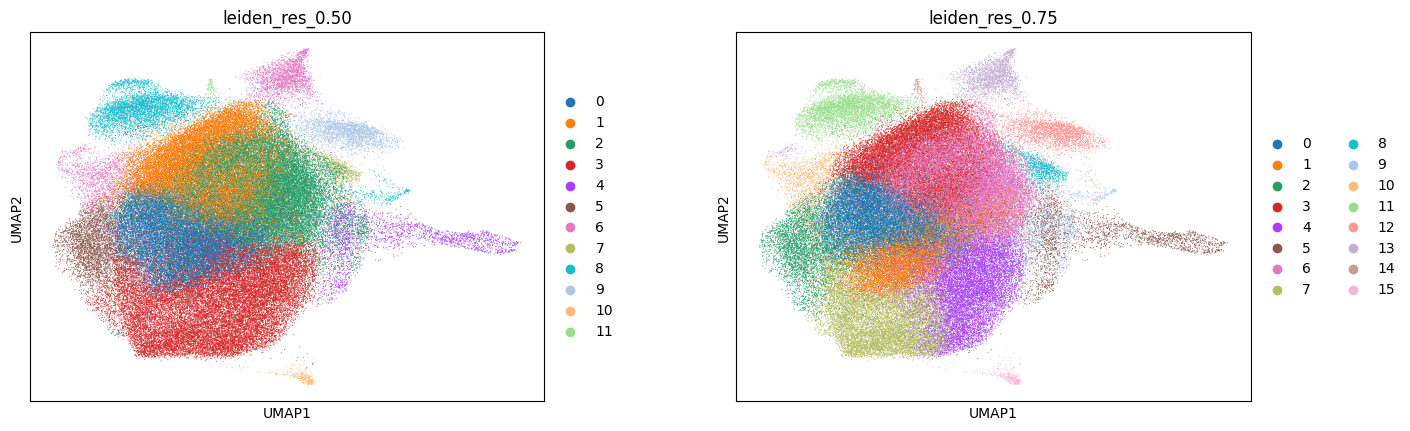

In [ ]:
sc.pl.umap(adata, color=["leiden_res_0.50", "leiden_res_0.75"], wspace=0.25, size=2)

We will also perform Leiden clustering with lower resolutions of 0.40 and 0.45 and see how many clusters there are.

In [ ]:
for res in [0.40, 0.45]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.45', the cluster labels (adata.obs, categorical) (0:00:03)


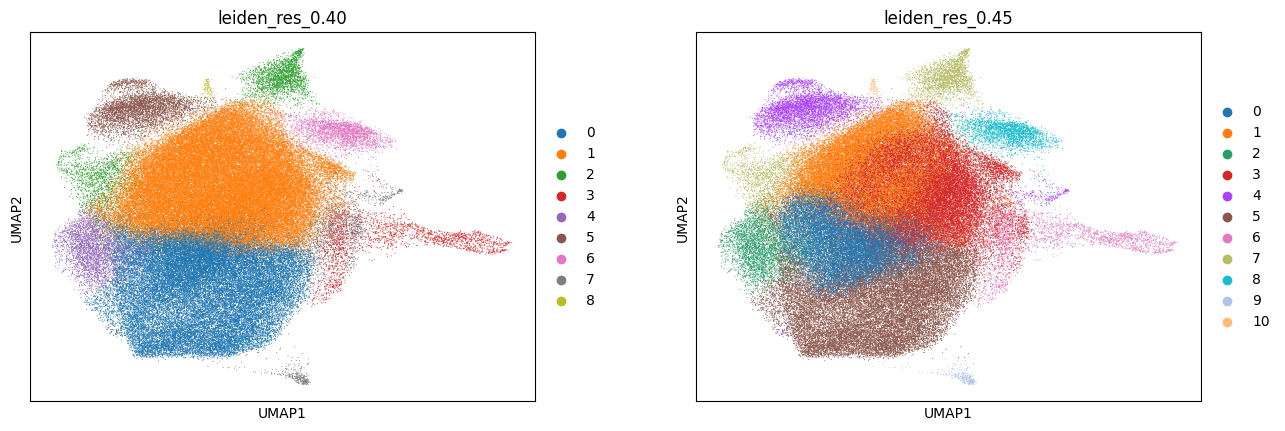

In [ ]:
sc.pl.umap(adata, color=["leiden_res_0.40", "leiden_res_0.45"], wspace=0.2, size=2)

We will continue with the UMAP with 12 clusters (Leiden clustering resolution 0.5) and see if the number of unique TF KOs per cluster is reasonable. View which perturbations cluster together:

In [ ]:
cluster_summary_05 = cluster_summary_df(adata, "leiden_res_0.50")
cluster_summary_05.head()

gene_target      AAAS  ABCD4  ABCF1  ABHD17A  ABI2  ACBD4  ACCS  ACIN1  ACLY  \
leiden_res_0.50                                                                
0                   9      3      6        5     8      4     3      4     4   
1                  12     10      6        9     7      5     6      5    10   
2                  18     19     13       11    17     11     7      9     9   
3                  20     13      2        6     7      9     6      9     5   
4                   2      0      0        3     0      0     1      1     1   

gene_target      ACOT8  ...  ZNF780A  ZNF783  ZNF823  ZNF844  ZNF888  ZNRF1  \
leiden_res_0.50         ...                                                   
0                    8  ...        5       4       5       9       4      3   
1                   27  ...       10      10      14      28      12      5   
2                   36  ...        2       7       5      20       8      6   
3                   22  ...        5      11       5      10       7     10   
4                    3  ...        1       0       1       1       1      1   

gene_target      ZSCAN18  ZSCAN25  ZSCAN32  ZYX  
leiden_res_0.50                                  
0                     10        3        6    4  
1                     23        9       17    7  
2                      6        4        3    8  
3                      9        7        9    4  
4                      1        0        1    0  

[5 rows x 1354 columns]

Generate a DataFrame with the TF KOs in each cluster and the number of occurrences of each TF KO in that cluster

In [ ]:
cluster_05_cluster_by_tf_ko = cluster_summary_tf_ko_df(cluster_summary_05)
cluster_05_cluster_by_tf_ko

gene_target      AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
leiden_res_0.50                                                                 
0                     6       6        25      6      4      2     10       8   
1                     6      14        49     20     17      8     20      13   
2                    15       5        23      6      5      7     11      10   
3                     8       4        47      9     15      6     15      12   
4                     1       1         3      1      0      0      3       0   
5                     3       1         8      0      0      1      4       1   
6                     2       5        12      4      1      2      4       2   
7                     2       0         4      0      0      0      0       1   
8                     1       3         8      0      4      2      4       1   
9                     1       1         3      2      1      2      4       5   
10                    0       0         4      0      0      0      0       2   
11                    0       0         0      0      0      1      0       0   

gene_target      BARX1  BHLHA9  ...  ZNF732  ZNF735  ZNF780A  ZNF783  ZNF823  \
leiden_res_0.50                 ...                                            
0                   10       9  ...       4       5        5       4       5   
1                   22      25  ...      18       8       10      10      14   
2                   16      12  ...       5       7        2       7       5   
3                   16      19  ...       7      12        5      11       5   
4                    1       1  ...       0       0        1       0       1   
5                    0       1  ...       0       0        3       0       0   
6                    8       1  ...       5       6        1       3       0   
7                    2       1  ...       0       0        0       0       0   
8                    4       8  ...       1       2        4       1       1   
9                    5       2  ...       2       2        2       1       0   
10                   0       0  ...       0       0        0       0       0   
11                   0       0  ...       0       0        0       0       0   

gene_target      ZNF844  ZNF888  ZSCAN18  ZSCAN25  ZSCAN32  
leiden_res_0.50                                             
0                     9       4       10        3        6  
1                    28      12       23        9       17  
2                    20       8        6        4        3  
3                    10       7        9        7        9  
4                     1       1        1        0        1  
5                     1       1        4        2        1  
6                     2       3        1        1        2  
7                     0       0        1        0        0  
8                     4       1        3        0        2  
9                     3       1        0        1        1  
10                    0       0        1        0        1  
11                    0       0        0        0        0  

[12 rows x 229 columns]

Now we want to find which TF KOs occur most frequently in each cluster. First, we will create a DataFrame with the 20 most frequent TF KOs per cluster and the number of occurrences of each TF KO.

In [ ]:
num_tf_kos_per_cluster = 20
cluster_05_tf_kos_counts_df = tf_ko_cluster_df(cluster_05_cluster_by_tf_ko, num_tf_kos_per_cluster)
cluster_05_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    28    CHAMP1    54     ZFP41    52  ARHGAP35    47    POU5F1   
1   ARHGAP35    25     ZFP41    53     FOXH1    26     ZFP41    42    ZNF521   
2      FOXH1    24  ARHGAP35    49  ARHGAP35    23   ZNF354A    40     PHF20   
3    ZNF354A    21   ZNF354A    41     NANOG    23     SHOX2    30    POU3F2   
4     ZNF205    19    ZNF462    39   MSANTD4    22      ETS1    29   POU5F1B   
5     CHAMP1    18     NFIL3    37    ZNF75D    21     DOT1L    28    ZNF396   
6     ZBTB22    18      ETS1    33    ZNF844    20      SHOX    27    HOXD13   
7    NEUROD4    17      HES6    33      ZFP1    19     FOXJ2    26     NANOG   
8     ZFP69B    17     SHOX2    32     FOXS1    18     PCGF6    26    PRDM14   
9       ETV1    16      SOX4    32   ZNF354A    18    ZNF383    26      PURG   
10      PURG    16   NEUROD4    31    ZNF383    18      E2F4    25   NANOGP8   
11      SOX4    16    ZNF219    31      PURG    17    ZBTB22    25      RBPJ   
12     FOXS1    15     TBX20    30    THAP12    17    ZFP69B    25    ZNF418   
13      ZFP1    15    ZFP69B    30    ZBTB22    17    ZNF219    24    SETDB2   
14    ZNF219    15    ZNF394    30     ZFP30    17    CHAMP1    23      ESR1   
15      MTF2    14     TBX18    29     BARX1    16    ZNF75D    23   NEUROD4   
16    SETDB1    14     TIGD2    29      ESR1    16      SOX4    22     TIGD2   
17     TBX20    14      ZFP1    29     FOXK2    16    ZNF420    22    ZNF75D   
18     PITX3    13     PCGF6    28     PCGF6    16    MTERF4    21    ZNF701   
19     SHOX2    13    ZBTB22    28     SHOX2    16    SETDB1    21     ESRRA   

          ... cluster 7       cluster 8       cluster 9       cluster 10  \
   count  ...     TF KO count     TF KO count     TF KO count      TF KO   
0     93  ...  ARHGAP35     4     SALL4    13       DR1     6   ARHGAP35   
1     58  ...     PCGF6     3     THAP6    11      E2F4     6     CHAMP1   
2     45  ...     ZFP41     3     ESRRA     9     ZFP41     6      NFIL3   
3     44  ...    AKAP8L     2      MAFG     9    ZNF420     6     BARHL1   
4     44  ...     BARX1     2  ARHGAP35     8    BARHL1     5      DMRT2   
5     39  ...      FOSB     2    BHLHA9     8     BARX1     5       EBF2   
6     35  ...     FOXJ2     2     FOXS1     8     PCGF6     5       ESR1   
7     23  ...    ZBTB42     2     SNAI1     8     PITX3     5    FOXD4L5   
8     15  ...    ZNF462     2      PHF1     7      SOX4     5      FOXE3   
9      9  ...    ZNF573     2     SMAD4     7     TIGD2     5      FOXK1   
10     7  ...    BARHL1     1     TBX20     7    ZNF383     5      FOXS1   
11     7  ...    BHLHA9     1     ZFP41     7    ZNF462     5       HES6   
12     7  ...      CBX2     1   ZNF354A     7     ATOH1     4     PRDM12   
13     6  ...    CREBL2     1    ZNF418     7      ETV1     4      TCF12   
14     5  ...      CREM     1      HES7     6     FOXJ2     4      TIGD6   
15     5  ...     DMRT2     1      JRKL     6     GATA5     4     ZBTB22   
16     5  ...     DNMT1     1    MTERF3     6     NANOG     4      ZFP30   
17     5  ...      DUXA     1   NEUROD4     6     PRDM8     4      ZFP41   
18     5  ...      ETS1     1    NKX2-4     6      PURG     4     ZNF75D   
19     4  ...     FOXK2     1    POU2F1     6    ZNF219     4    ZNF354A   

         cluster 11        
   count      TF KO count  
0      4      DNMT1   113  
1      4     SETDB1    11  
2      3     CHAMP1    10  
3      2      PITX3     4  
4      2        VDR     4  
5      2      ATMIN     1  
6      2      DOT1L     1  
7      2       ETS2     1  
8      2      FOXJ2     1  
9      2       TCF3     1  
10     2      TIGD2     1  
11     2      TIGD6     1  
12     2     ZNF706     1  
13     2                   
14     2                   
15     2                   
16     2                   
17     2                   
18     2 

We want to visualize the TF KOs and counts per cluster in an informative way so that we can decide which Leiden clustering resolution is optimal. We will try a stacked bar chart where each bar corresponds to a cluster; each horizontal line in the cluster represents a TF KO with a vertical width representing the number of cells corresponding to that TF KO.

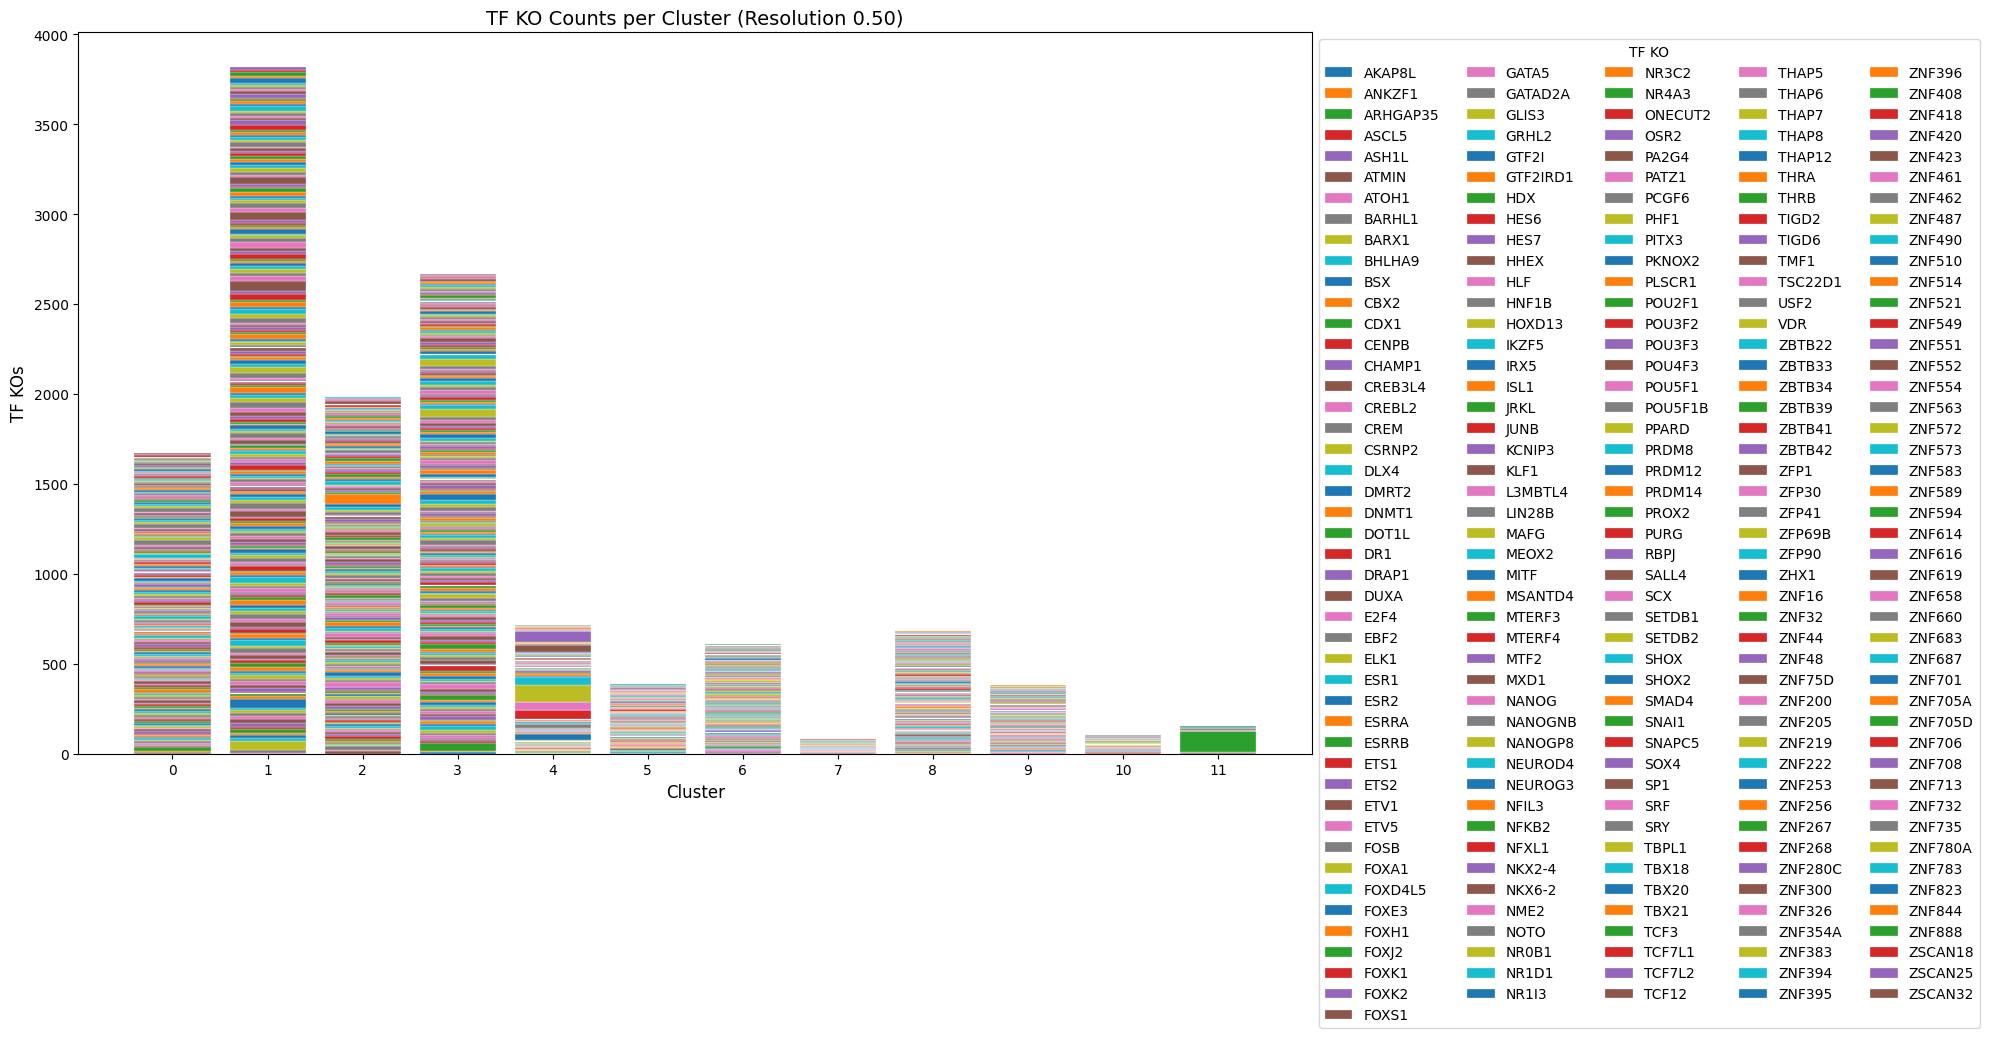

In [ ]:
cluster_tf_kos_05 = cluster_summary_tf_ko_df(cluster_summary_df(adata, "leiden_res_0.50"))
sns_stacked_bar_lines(cluster_tf_kos_05, title="TF KO Counts per Cluster (Resolution 0.50)")

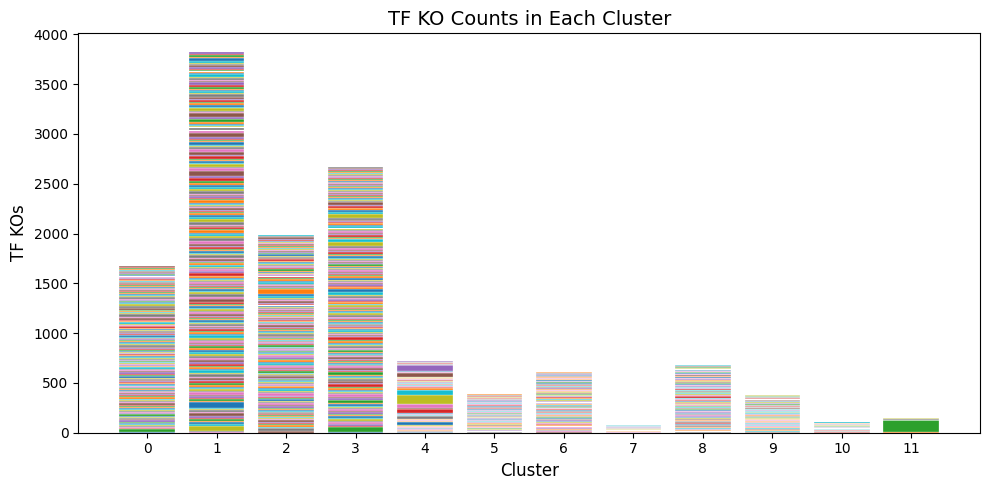

In [ ]:
sns_stacked_bar_lines(cluster_tf_kos_05, legend=False)

We will try with the resolution of 0.40:

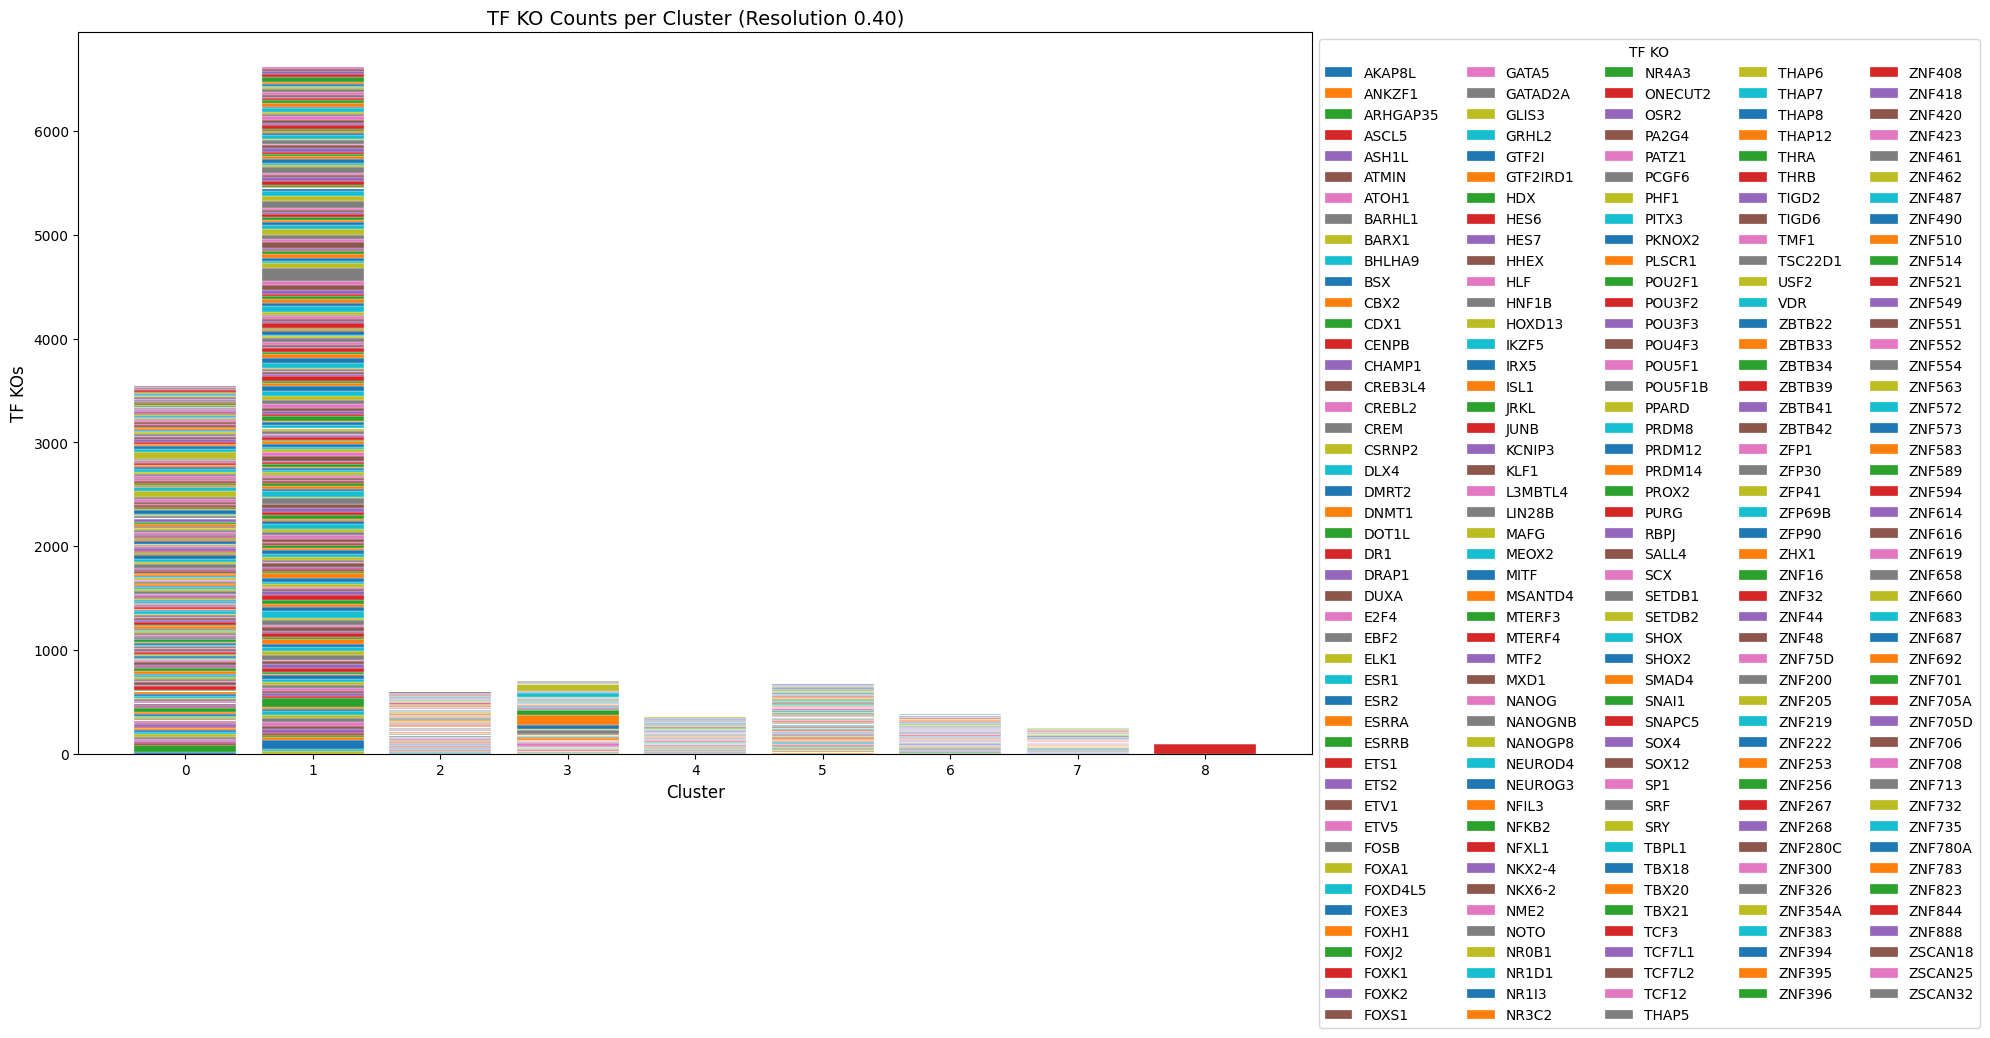

In [ ]:
cluster_tf_kos_04 = cluster_summary_tf_ko_df(cluster_summary_df(adata, "leiden_res_0.40"))
sns_stacked_bar_lines(cluster_tf_kos_04, legend=True, title="TF KO Counts per Cluster (Resolution 0.40)")

And with a resolution of 0.75:

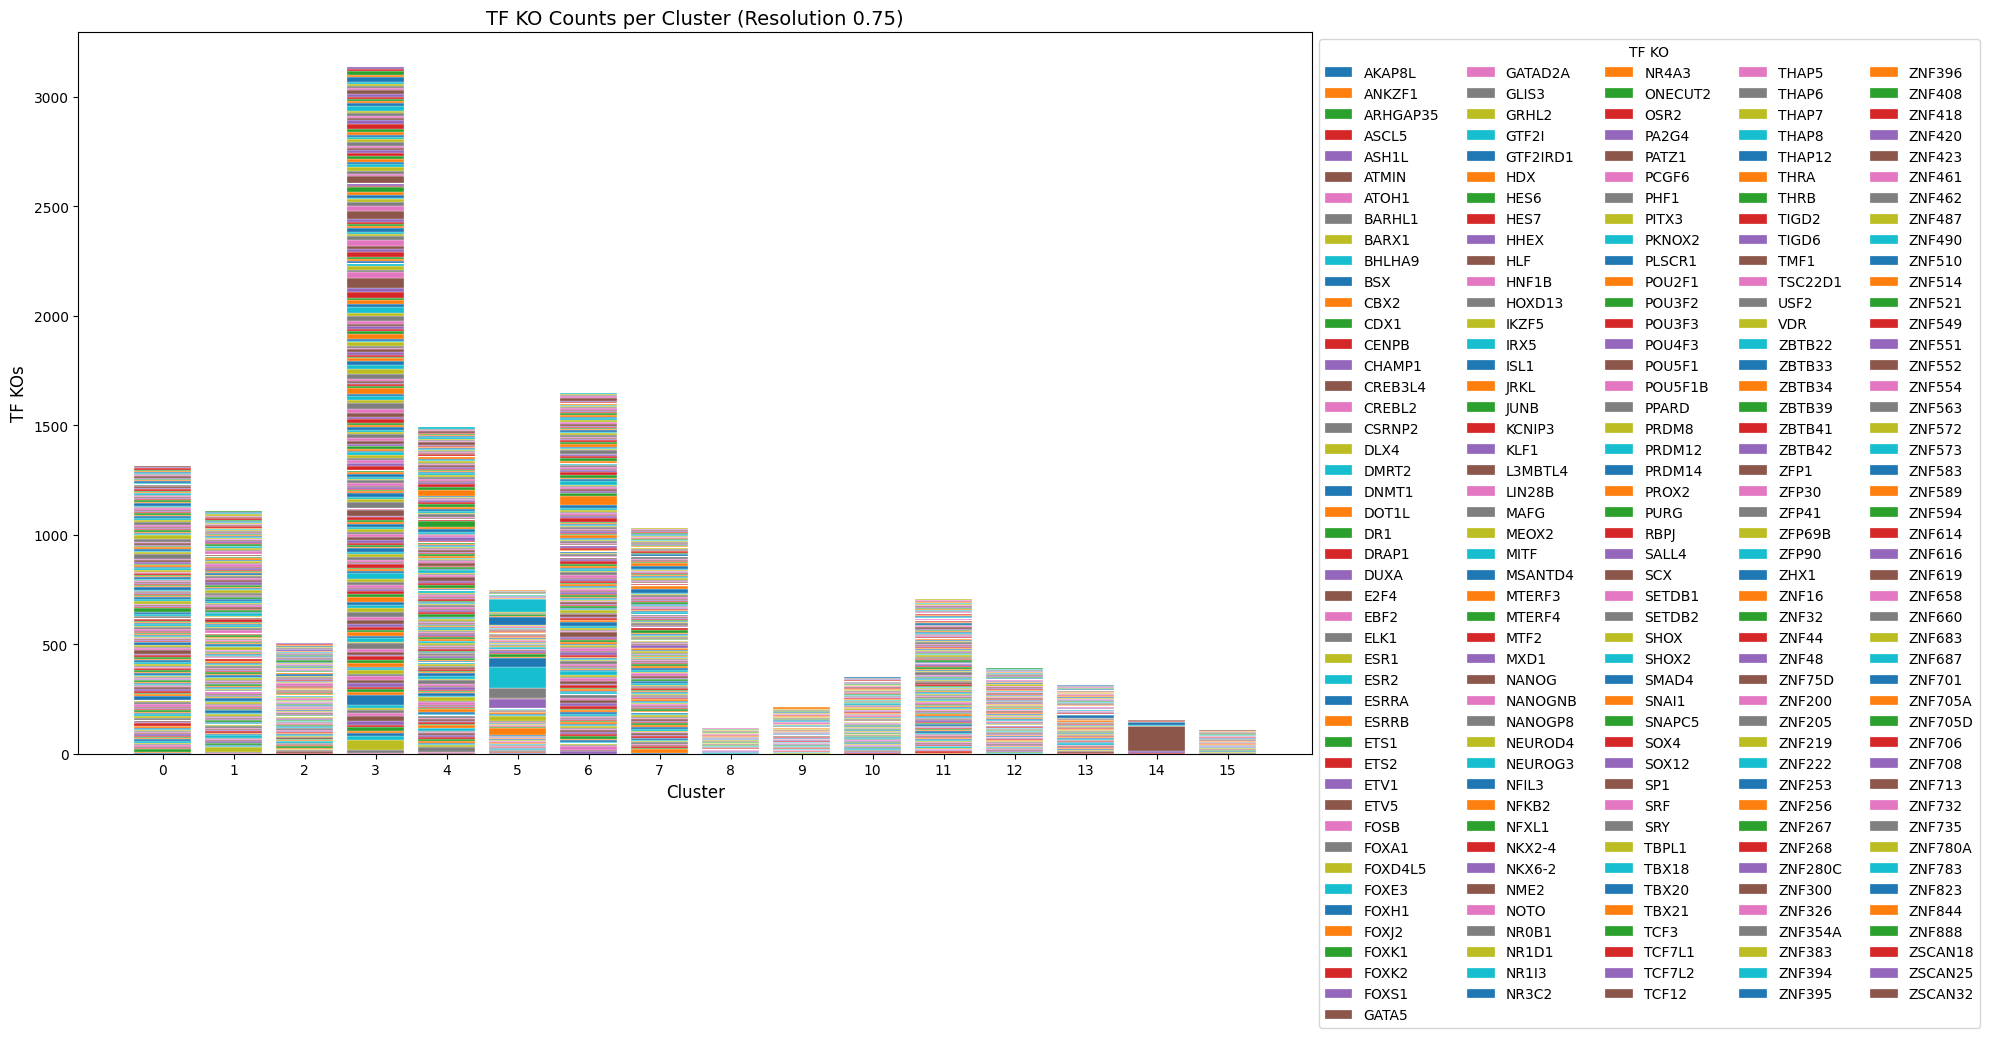

In [ ]:
cluster_tf_kos_075 = cluster_summary_tf_ko_df(cluster_summary_df(adata, "leiden_res_0.75"))
sns_stacked_bar_lines(cluster_tf_kos_075, legend=True, title="TF KO Counts per Cluster (Resolution 0.75)")

### Visualizing TF KOs and their counts per cluster - other graphs

In [ ]:
def sns_heatmap(df_pivot):
    sns.heatmap(df_pivot, cmap="Blues", annot=False, fmt="d", linewidths=0.5)
    plt.xlabel("Cluster")
    plt.ylabel("TF KO")
    plt.title("TF KO Distribution Across Clusters")
    plt.show()

In [ ]:
cluster_summary_05_tf_ko_by_cluster = cluster_05_cluster_by_tf_ko.T
cluster_summary_05_tf_ko_by_cluster.head()

leiden_res_0.50   0   1   2   3  4  5   6  7  8  9  10  11
gene_target                                               
AKAP8L            6   6  15   8  1  3   2  2  1  1   0   0
ANKZF1            6  14   5   4  1  1   5  0  3  1   0   0
ARHGAP35         25  49  23  47  3  8  12  4  8  3   4   0
ASCL5             6  20   6   9  1  0   4  0  0  2   0   0
ASH1L             4  17   5  15  0  0   1  0  4  1   0   0

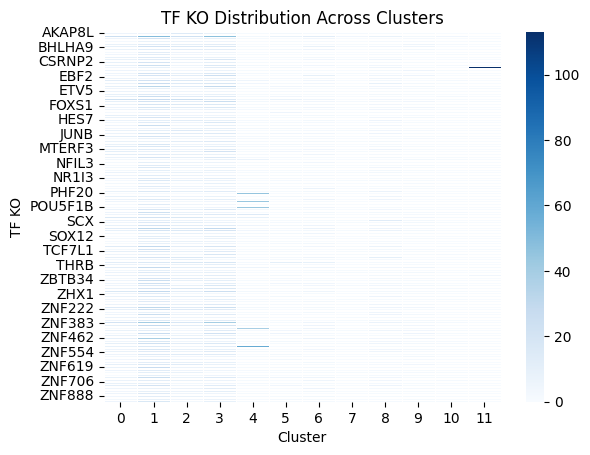

In [ ]:
sns_heatmap(cluster_05_cluster_by_tf_ko.T)

In [ ]:
def sns_stacked_bar(df_pivot):
    # Plot a stacked bar plot
    df_pivot.plot(kind='bar', stacked=True, figsize=(15, 6), cmap="rainbow")

    # Add labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Number of Cells')
    plt.title('Number of TF Knockouts per Cluster')
    plt.legend(bbox_to_anchor=(1,1), ncols=10)

    # Show the plot
    plt.show()

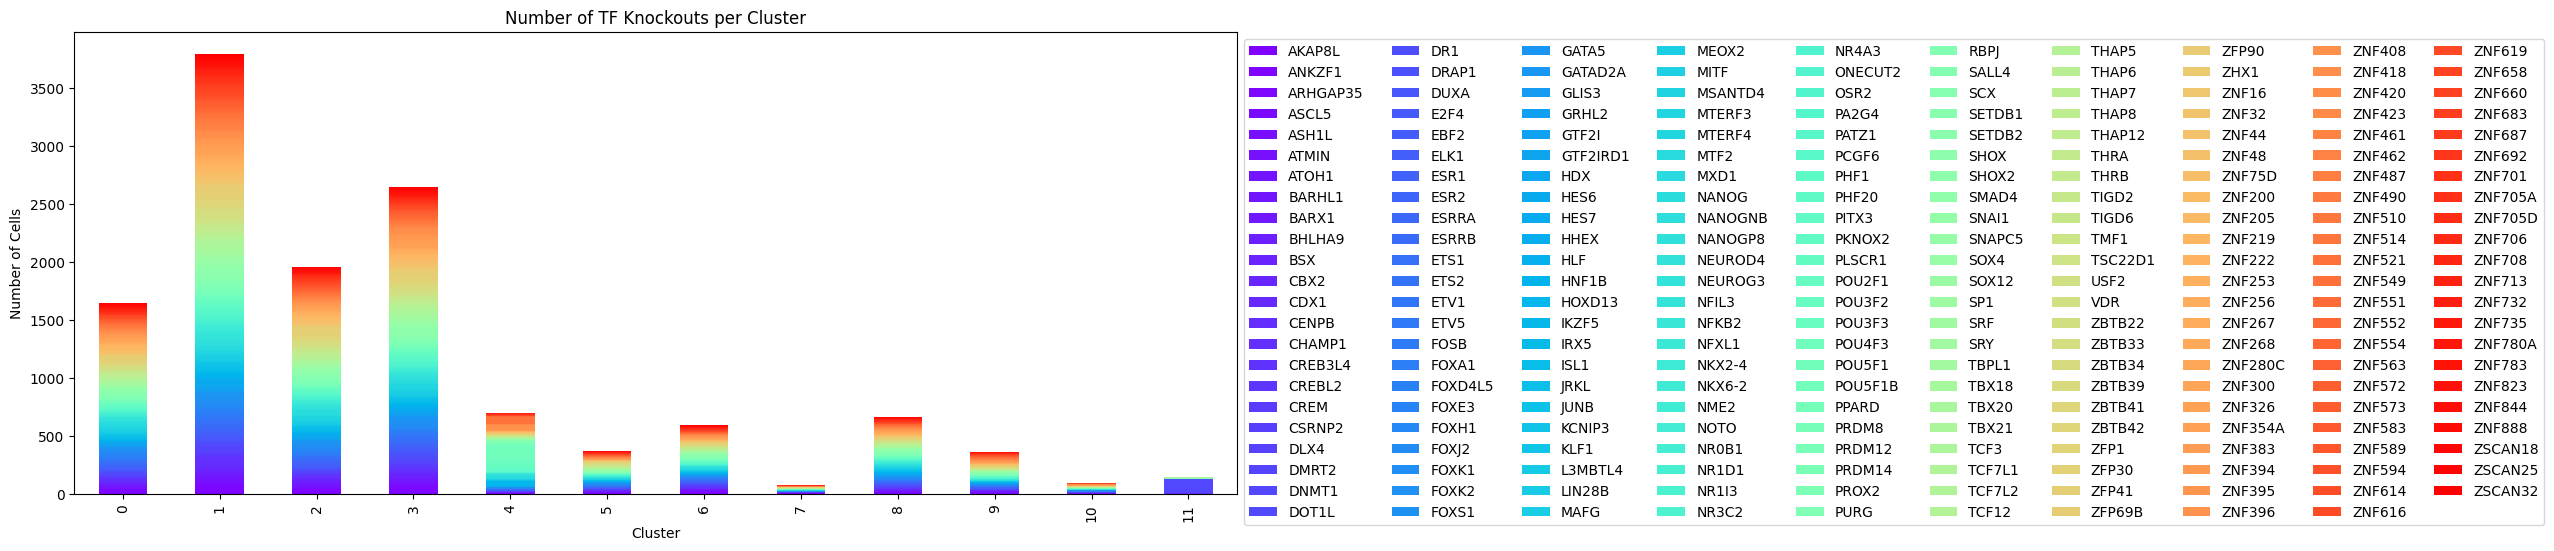

In [ ]:
sns_stacked_bar(cluster_05_cluster_by_tf_ko)

Now we will write some functions to turn the data into "long" data and plot the long data:

In [ ]:
def df_single_header(df_cluster_by_tf_ko):
    reset = df_cluster_by_tf_ko.reset_index()
    reset.columns.name = None
    reset.rename(columns={reset.columns[0]: "Cluster"}, inplace=True)
    return reset

def df_long(df_single_header):
    return df_single_header.melt(id_vars='Cluster', var_name='TF_KO', value_name='Count')

In [ ]:
df_single_header_05 = df_single_header(cluster_05_cluster_by_tf_ko)
df_single_header_05

Cluster  AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
0        0       6       6        25      6      4      2     10       8   
1        1       6      14        49     20     17      8     20      13   
2        2      15       5        23      6      5      7     11      10   
3        3       8       4        47      9     15      6     15      12   
4        4       1       1         3      1      0      0      3       0   
5        5       3       1         8      0      0      1      4       1   
6        6       2       5        12      4      1      2      4       2   
7        7       2       0         4      0      0      0      0       1   
8        8       1       3         8      0      4      2      4       1   
9        9       1       1         3      2      1      2      4       5   
10      10       0       0         4      0      0      0      0       2   
11      11       0       0         0      0      0      1      0       0   

    BARX1  ...  ZNF732  ZNF735  ZNF780A  ZNF783  ZNF823  ZNF844  ZNF888  \
0      10  ...       4       5        5       4       5       9       4   
1      22  ...      18       8       10      10      14      28      12   
2      16  ...       5       7        2       7       5      20       8   
3      16  ...       7      12        5      11       5      10       7   
4       1  ...       0       0        1       0       1       1       1   
5       0  ...       0       0        3       0       0       1       1   
6       8  ...       5       6        1       3       0       2       3   
7       2  ...       0       0        0       0       0       0       0   
8       4  ...       1       2        4       1       1       4       1   
9       5  ...       2       2        2       1       0       3       1   
10      0  ...       0       0        0       0       0       0       0   
11      0  ...       0       0        0       0       0       0       0   

    ZSCAN18  ZSCAN25  ZSCAN32  
0        10        3        6  
1        23        9       17  
2         6        4        3  
3         9        7        9  
4         1        0        1  
5         4        2        1  
6         1        1        2  
7         1        0        0  
8         3        0        2  
9         0        1        1  
10        1        0        1  
11        0        0        0  

[12 rows x 230 columns]

In [ ]:
df_long(df_single_header_05)

Cluster    TF_KO  Count
0          0   AKAP8L      6
1          1   AKAP8L      6
2          2   AKAP8L     15
3          3   AKAP8L      8
4          4   AKAP8L      1
...      ...      ...    ...
2743       7  ZSCAN32      0
2744       8  ZSCAN32      2
2745       9  ZSCAN32      1
2746      10  ZSCAN32      1
2747      11  ZSCAN32      0

[2748 rows x 3 columns]

In [ ]:
def sns_dotplot(df_long):
    # Create the dot plot
    sns.scatterplot(data=df_long, x="Cluster", y="TF_KO", size="Count", hue="Count", palette="viridis", edgecolor="black")

    # Rotate x-axis labels if needed for better readability
    plt.xticks(rotation=90)

    # Add labels and title
    plt.xlabel("Cluster")
    plt.ylabel("Transcription Factor Knockout (TF_KO)")
    plt.title("Transcription Factor Knockouts per Cluster")

    # Show the plot
    plt.show()

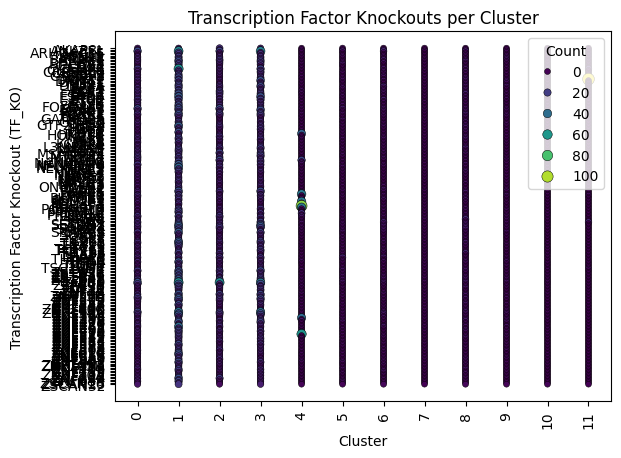

In [ ]:
sns_dotplot(df_long(df_single_header_05))

In [ ]:
def sns_multi_histogram(df_long):
    # Step 1: Pivot the dataframe so that rows represent clusters, columns represent TF_KOs, and values are the number of cells per TF KO
    df_pivot = df_long.pivot_table(index='Cluster', columns='TF_KO', values='Count', aggfunc='sum', fill_value=0)

    # Step 2: For each cluster, count how many TF KOs appear in 1 cell, 2 cells, etc.
    # This will give us a distribution for each cluster: how many TF KOs are in exactly 1 cell, 2 cells, etc.
    cell_counts = df_pivot.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

    # Step 3: Set up the subplots
    n_clusters = len(cell_counts)
    fig, axes = plt.subplots(n_clusters, 1, figsize=(8, 4 * n_clusters), sharex=True, sharey=False)

    # Step 4: Loop through each cluster and plot a histogram
    for i, cluster in enumerate(cell_counts.index):
        # Get the counts of TF KOs in 1, 2, 3, etc. cells for the current cluster
        cluster_counts = cell_counts.loc[cluster]

        # Filter out TF KOs with 0 cells in the cluster
        cluster_counts = cluster_counts[cluster_counts > 0]

        # Plot the histogram for the current cluster if there are any non-zero counts
        if len(cluster_counts) > 0:
            axes[i].bar(cluster_counts.index, cluster_counts.values, width=0.8, color='skyblue', edgecolor='black')

            # Set dynamic limits for the x-axis to "zoom in" based on the actual values for the current cluster
            axes[i].set_xlim(-1, max(cluster_counts.index) + 0.5)

            # Set dynamic limits for the y-axis to "zoom in" based on the actual counts for the current cluster
            axes[i].set_ylim(0, max(cluster_counts.values) * 1.1)  # Add a little space above the highest bar

            # Customize the plot for the current cluster
            axes[i].set_title(f'Cluster {cluster}')
            axes[i].set_xlabel('Number of Cells per TF KO')
            axes[i].set_ylabel('Number of TF KOs')
            plt.xticks()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [1]:
# sns_multi_histogram(df_long(df_single_header_05))

With the Leiden clustering resolution of 0.5, some of the 11 clusters have a low numbers or occurrences of TF KOs. We will generate the same tables with a lower resolution of 0.40 that resulted in 9 clusters.

In [ ]:
cluster_9_tf_kos = cluster_summary_tf_ko_df(cluster_summary_df("leiden_res_0.40"))
cluster_9_tf_kos_counts_df = tf_ko_cluster_df(cluster_9_tf_kos, 50)
cluster_9_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0   ARHGAP35    69     ZFP41   119  ARHGAP35    11    POU5F1    94     ZFP41   
1    ZNF354A    58  ARHGAP35    82    SETDB1    11    ZNF521    60    THAP12   
2      ZFP41    55    CHAMP1    82      E2F4    10     PHF20    45     FOXH1   
3      SHOX2    37     FOXH1    64    THAP12     9    POU3F2    44     GRHL2   
4     ZBTB22    36   ZNF354A    59     BARX1     8   POU5F1B    44      CBX2   
5      DOT1L    35     SHOX2    57      ETV1     8    ZNF396    39  ARHGAP35   
6       ETS1    35    ZNF219    57     PATZ1     7    HOXD13    35    MTERF4   
7     ZFP69B    34     NFIL3    56    SETDB2     7     NANOG    22    ZBTB22   
8     ZNF383    34    ZNF462    56     SHOX2     7    PRDM14    14      CREM   
9     CHAMP1    32    ZNF75D    54    ZNF383     7      PURG     8     DOT1L   
10     FOXJ2    31     FOXS1    53    ZNF462     7   NANOGP8     7      EBF2   
11    SETDB1    31     TBX20    53    CHAMP1     6      RBPJ     7      ETS1   
12      ETV1    30   NEUROD4    52      DLX4     6    SETDB2     6     FOXS1   
13     PCGF6    30      SOX4    52     DOT1L     6    ZNF418     6      MTF2   
14      SHOX    30    ZBTB22    52    POU2F1     6      ESR1     5     NFIL3   
15    ZNF75D    30      ZFP1    52     SNAI1     6   NEUROD4     5     PCGF6   
16     FOXH1    29      ETS1    51      SOX4     6     TIGD2     5    POU3F3   
17      SOX4    28     PCGF6    51      ZFP1     6     ESRRA     4      SHOX   
18      ZFP1    28    ZFP69B    49     ZFP41     6     SMAD4     4      SOX4   
19    ZNF219    28    ZNF394    49    ZNF394     6    ZBTB22     4    ZBTB41   
20    MTERF4    27    ZNF844    49    ZNF735     6      ZHX1     4      ZFP1   
21    THAP12    27    ZNF383    48       BSX     5    ZNF75D     4    ZNF408   
22     BARX1    26     ESRRA    47      CREM     5    ZNF701     4    ZNF420   
23      E2F4    26      HES6    47     FOXH1     5  ARHGAP35     3    ZNF701   
24    ZNF394    26   FOXD4L5    46      MXD1     5     ATOH1     3    ZNF713   
25     FOXS1    25      PURG    45     PCGF6     5      CBX2     3   ZSCAN18   
26    BHLHA9    24     TIGD2    45    SNAPC5     5    CHAMP1     3     ATOH1   
27     PITX3    24    ZNF222    45     THAP6     5     FOXS1     3     DNMT1   
28    ZNF420    24      ESR1    44     TIGD2     5     IKZF5     3      FOSB   
29   NEUROD4    23      ETV1    43    ZFP69B     5      ISL1     3      HES6   
30     TBX18    23     TBX18    43   ZNF354A     5     PPARD     3      OSR2   
31     TBX20    23     FOXJ2    42    ZNF396     5    ZFP69B     3    PKNOX2   
32    ZNF205    23     NANOG    42    ZNF701     5    ZNF219     3     SMAD4   
33    ZNF418    23   MSANTD4    41    ANKZF1     4    ZNF487     3       SRF   
34    ZNF510    23     THAP6    41    CREBL2     4    ZNF658     3       VDR   
35     DMRT2    22     BARX1    40      EBF2     4    BHLHA9     2    ZBTB39   
36     DNMT1    22    BHLHA9    40      ESR1     4     DMRT2     2     ZNF16   
37      RBPJ    22     SMAD4    40      ESR2     4      DUXA     2    ZNF383   
38     SMAD4    22     ZFP30    40     FOXJ2     4      ESR2     2    ZNF395   
39     ZFP30    22    ZNF418    40     FOXK1     4      FOSB     2    ZNF490   
40     ATOH1    21      FOSB    39     GATA5     4     FOXH1     2    ZNF563   
41    CREBL2    21     FOXK2    39      HES6     4     FOXJ2     2    ZNF583   
42      EBF2    21    ZNF701    39      HES7     4   GATAD2A     2   ZNF780A   
43     ESRRA    21      DUXA    38      ISL1     4      HES7     2    AKAP8L   
44      JRKL    21      MTF2    38      JRKL     4       HLF     2       BSX   
45    ZNF701    21      SHOX    38   MSANTD4     4      JRKL     2      ELK1   
46      MAFG    20     DOT1L    37    MTERF3     4    KCNIP3     2      ETS2   
47   MSANTD4    20    THAP12    37     NANOG     4   L3MBTL4     2     FOXJ2   
48 

Visualize the UMAP for this resolution

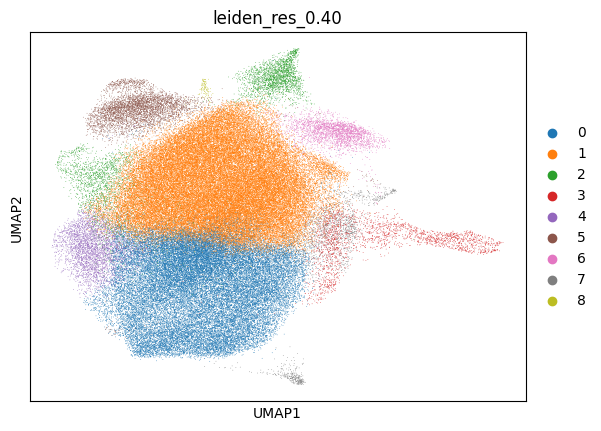

In [ ]:
sc.pl.umap(adata, color="leiden_res_0.40")

## UMAP helper functions and variables

Variables for UMAP section of notebook

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# DEGs from study pipeline
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs.xlsx", index_col=0)

Helper functions and variables for UMAP section of notebook

In [ ]:
def cluster_summary_df(adata, leiden_res: str):
    """
    Create DataFrame of perturbations in each Leiden cluster at the given resolution.
    """
    # Extract cluster assignments and perturbation labels
    cluster_data = adata.obs[[leiden_res, "gene_target"]]
    # Count occurrences of each perturbation in each cluster
    return cluster_data.groupby([leiden_res, "gene_target"]).size().unstack(fill_value=0)

def cluster_summary_tf_ko_df(cluster_summary_df):
    """
    Filter perturbations-per-cluster DataFrame to show only TF KOs.
    """
    return cluster_summary_df.loc[:, cluster_summary_df.columns.isin(tfs)]

def tf_ko_cluster_df(cluster_summary, n_tf_kos):
    """
    Create DataFrame of TF KOs per cluster and their occurrences.
    """
    n_clusters = cluster_summary.index.nunique()
    cluster_tf_ko_dict = dict()
    for i in range(0, n_clusters*2, 2):
        idx = int(i/2)
        freq_tf_kos = cluster_summary.iloc[idx].nlargest(n_tf_kos).index.tolist()
        tf_ko_counts = cluster_summary.iloc[idx].nlargest(n_tf_kos).tolist()
        # If there are fewer than n_tf_kos TF KOs in cluster
        nonzeros = sum(1 for x in tf_ko_counts if x != 0)
        if nonzeros != n_clusters:
            blanks = ["" for _ in range(n_tf_kos - nonzeros)]
            freq_tf_kos = freq_tf_kos[:nonzeros] + blanks
            tf_ko_counts = tf_ko_counts[:nonzeros] + blanks
        cluster_tf_ko_dict[i] = freq_tf_kos
        cluster_tf_ko_dict[i+1] = tf_ko_counts
    cluster_tf_kos = pd.DataFrame.from_dict(cluster_tf_ko_dict)
    # Add header rows
    header1 = [f"cluster {int(i/2)}" if i % 2 == 0 else "" for i in range(n_clusters*2)]
    header2 = ["TF KO", "count"]*n_clusters
    cluster_tf_kos.columns = pd.MultiIndex.from_tuples(list(zip(header1, header2)))
    return cluster_tf_kos

def tf_ko_cluster_df_from_adata(adata, leiden_res: str, n_tf_kos):
    """
    Given an AnnData object, a Leiden clustering resolution, and a number of TF KOs to display per cluster,
    create a DataFrame of TF KOs per cluster and their occurrences.
    """
    return tf_ko_cluster_df(cluster_summary_tf_ko_df(cluster_summary_df(adata, leiden_res)), n_tf_kos)

def tf_ko_only_cluster_df(cluster_tf_ko_df):
    """
    Filter DataFrame of TF KOs per cluster and their occurrences to show only TF KOs per cluster without counts.
    """
    cluster_tf_kos = cluster_tf_ko_df.copy()
    new_header = cluster_tf_kos.columns.values.tolist()
    new_header = [new_header[i][0] for i in range(len(new_header))]
    cluster_tf_kos = cluster_tf_kos.set_axis(new_header, axis=1)
    cluster_tf_kos = cluster_tf_kos.loc[:, cluster_tf_kos.columns != ""].copy()
    return cluster_tf_kos

Functions for plotting in the UMAP section of the notebook

In [ ]:
def sns_stacked_bar_lines(pivot_df, legend=True, title=None):
    # Create the figure and axes
    if legend:
        _, ax = plt.subplots(figsize=(20, 10))
    else:
        _, ax = plt.subplots(figsize=(10, 5))

    # Plot each cluster as a group of vertical bars
    bar_width = 0.8  # Bar width
    spacing = 0.1  # Spacing between vertical bars

    # Loop through each cluster and plot the vertical bars for each TF KO
    for i, cluster in enumerate(pivot_df.index):
        # Initialize the bottom of the bars (start from 0 for each cluster)
        bottom = 0
        for j, tf_ko in enumerate(pivot_df.columns):
            count = pivot_df.loc[cluster, tf_ko]
            
            if count > 0:  # Only plot TF KOs that have at least 1 cell in the cluster
                ax.bar(x=i, height=count, width=bar_width, bottom=bottom, label=tf_ko if i == 0 else "", 
                    edgecolor="white", linewidth=0.2)
                bottom += count + spacing  # Update the bottom to stack the next bar

    # Customize the plot
    if not title:
        ax.set_title("TF KO Counts in Each Cluster", fontsize=14)
    else:
        ax.set_title(title, fontsize=14)
    ax.set_ylabel("TF KOs", fontsize=12)
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_xticks(np.arange(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, fontsize=10)
    if legend:
        ax.legend(title="TF KO", bbox_to_anchor=(1, 1), ncols=5)

    plt.tight_layout()  # To ensure everything fits within the plot area
    plt.show()

## TF KO by gene with LFC above threshold UMAP

# UMAP with LFC filter for DEGs

For this UMAP, we will filter for DEGs with a |LFC| > 0.25 

In [ ]:
adata_filt = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata_filt

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Write a feature selection function to only consider DEGs with |LFC| > 0.25, modifying the pipeline function:

In [ ]:
def extract_degs_lfc_threshold(combined_df, up_degs, down_degs):
    up_down_degs = set()
    perturbations = [col.split('_DEGs')[0] for col in combined_df.columns if '_DEGs' in col]
    
    for perturbation in perturbations:
        # Select the DEGs and L2FC columns for the perturbation
        degs_col = f'{perturbation}_DEGs'
        l2fc_col = f'{perturbation}_L2FC'
        
        # Create a DataFrame for the perturbation
        perturbation_df = combined_df[[degs_col, l2fc_col]].dropna()
        
        # Extract top x upregulated DEGs
        upregulated_df = perturbation_df[perturbation_df[l2fc_col] > 0.25].sort_values(by=l2fc_col, ascending=False).head(up_degs)
        top_upregulated = upregulated_df[degs_col].tolist()
        
        # Extract top y downregulated DEGs
        downregulated_df = perturbation_df[perturbation_df[l2fc_col] < 0.25].sort_values(by=l2fc_col, ascending=True).head(down_degs)
        top_downregulated = downregulated_df[degs_col].tolist()
        
        # Combine the results
        up_down_degs.update(top_upregulated + top_downregulated)
    
    # Return the subset of adata containing only the DEGs
    return up_down_degs


def feature_selection_lfc_threshold(adata, DEG_df, up_DEGs=20, down_DEGs=20):
    # Select top_n_DEGs for each perturbation, or the maximum possible if fewer than top_n_DEGs
    top_DEGs = extract_degs_lfc_threshold(DEG_df, up_DEGs, down_DEGs)
    
    # Filter out any None or NaN values that may have been introduced
    deg_values = [gene for gene in top_DEGs if pd.notnull(gene)]
    unique_degs = set(deg_values)
    print(f"Found {len(unique_degs)} DEGs with |LFC| > 0.25")

    # Return the subset of adata containing only the HVGs
    return adata[:, adata.var.index.isin(unique_degs)].copy()

Now we will filter HVGs with |LFC| > 0.25

In [ ]:
adata_filtered = feature_selection_lfc_threshold(adata_filt, deg_df)

Found 3521 DEGs with |LFC| > 0.25


In [ ]:
adata_filtered

AnnData object with n_obs × n_vars = 111902 × 3521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Run PCA and plot elbow plot:

computing PCA
    with n_comps=50
    finished (0:00:11)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


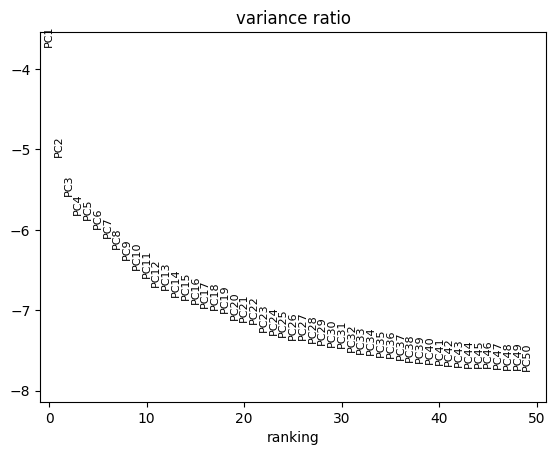

In [ ]:
sc.tl.pca(adata_filtered)
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=50, log=True) #Elbow plot

We will use the top 30 PCs for the neighborhood graph:

In [ ]:
num_pcs = 30
sc.pp.neighbors(adata_filtered, n_pcs=num_pcs)
sc.tl.umap(adata_filtered)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:12)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:06)


We will perform Leiden clustering with 3 different resolutions:

In [ ]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:03)


For the resolution = 0.75 condition, visualize the UMAP and TF KO table:

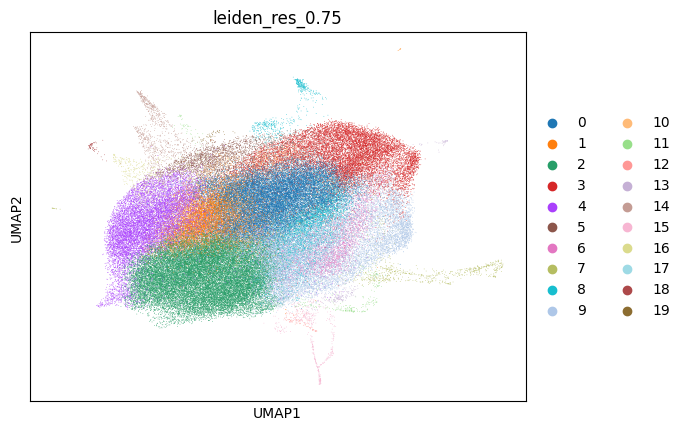

In [ ]:
sc.pl.umap(adata_filtered, color="leiden_res_0.75")

In [ ]:
cluster_filt_075_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.75", 20)
cluster_filt_075_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0   ARHGAP35    40     ZFP41    35     ZFP41    66     ZFP41    37   MSANTD4   
1      ZFP41    37     FOXH1    33  ARHGAP35    50  ARHGAP35    32    AKAP8L   
2    ZNF354A    37    CHAMP1    30    CHAMP1    45   ZNF354A    27    MTERF4   
3    NEUROD4    29    SETDB1    26    ZNF462    42    ZFP69B    23    SNAPC5   
4     ZNF383    29   ZNF354A    26      HES6    36     SHOX2    22     ZFP41   
5     SETDB1    28  ARHGAP35    25    ZNF219    36      ETS1    21    ZNF687   
6      FOXH1    27     NFIL3    25    ZBTB22    33      E2F4    20      FOSB   
7      FOXS1    27      ZFP1    24    ZNF75D    33     PCGF6    20     FOXS1   
8      DOT1L    24      ETS1    23    ZNF701    33    SETDB1    19      PHF1   
9     ZNF75D    24     SHOX2    23     ESRRA    31    ZBTB22    19    ZFP69B   
10      ETS1    22      SOX4    23     PCGF6    31    ZNF75D    19   ZNF354A   
11    ZNF205    22     TBX20    22     SHOX2    31    CHAMP1    18    ZNF614   
12     PCGF6    21    THAP12    22     FOXH1    30      SOX4    18  ARHGAP35   
13     TIGD2    21      ETV1    21     FOXJ2    30    ZNF394    18     BARX1   
14      ZFP1    21     FOXS1    21    NKX2-4    30    CREBL2    16    CHAMP1   
15    CHAMP1    20    ZNF383    21     SMAD4    30     DOT1L    16      ETS1   
16     PITX3    20    SETDB2    20      SOX4    30      ETV1    16      ETS2   
17    ZBTB22    20   NEUROD4    19    ZNF844    30     FOXJ2    16      HES7   
18    ZNF219    20    ZNF200    19    BHLHA9    29      MAFG    16    MTERF3   
19      RBPJ    19     ATOH1    18    ZNF222    29     NANOG    16      MXD1   

          ... cluster 15       cluster 16       cluster 17       cluster 18  \
   count  ...      TF KO count      TF KO count      TF KO count      TF KO   
0     16  ...      DNMT1   144     AKAP8L     2   ARHGAP35     6       ETV1   
1      7  ...     CSRNP2     5     MTERF4     2       ISL1     6   ARHGAP35   
2      7  ...     CHAMP1     3     SNAPC5     2     SETDB2     6     CHAMP1   
3      6  ...      FOXS1     3    MSANTD4     1     CHAMP1     5     POU3F2   
4      4  ...     SETDB1     3       PURG     1      PATZ1     5    POU5F1B   
5      4  ...       SHOX     3      TBX20     1       SOX4     5      ASCL5   
6      3  ...      SHOX2     3       THRA     1     ZNF383     5        BSX   
7      3  ...    TSC22D1     3     ZBTB34     1       CREM     4     CREBL2   
8      3  ...        VDR     3     ZNF408     1       ETV1     4      DOT1L   
9      3  ...     ZBTB33     3     ZNF783     1      NANOG     4       E2F4   
10     3  ...     ZNF200     3                       NFIL3     4      FOXJ2   
11     3  ...     ZNF552     3                       PRDM8     4      FOXK2   
12     2  ...     BHLHA9     2                     ZNF354A     4      GATA5   
13     2  ...     CREBL2     2                      ZNF462     4        HDX   
14     2  ...       FOSB     2                      ZNF732     4      IKZF5   
15     2  ...    FOXD4L5     2                      ZNF783     4     KCNIP3   
16     2  ...      FOXJ2     2                       BARX1     3       MITF   
17     2  ...      HNF1B     2                       DOT1L     3     NKX2-4   
18     2  ...       IRX5     2                        HES6     3      NR1I3   
19     2  ...       JRKL     2                       PCGF6     3     POU5F1   

         cluster 19        
   count      TF KO count  
0      3       CBX2     2  
1      2       FOSB     2  
2      2      GATA5     2  
3      2   GTF2IRD1     2  
4      2      PPARD     2  
5      1      ZFP41     2  
6      1      ASCL5     1  
7      1        BSX     1  
8      1     CREBL2     1  
9      1      DOT1L     1  
10     1      DRAP1     1  
11     1      ESRRA     1  
12     1      FOXK2     1  
13     1      MEOX2     1  
14     1       MITF     1  
15     1     PKNOX2     1  

Leiden clustering with resolution = 0.5 yielded 9 clusters. Visualize this UMAP:

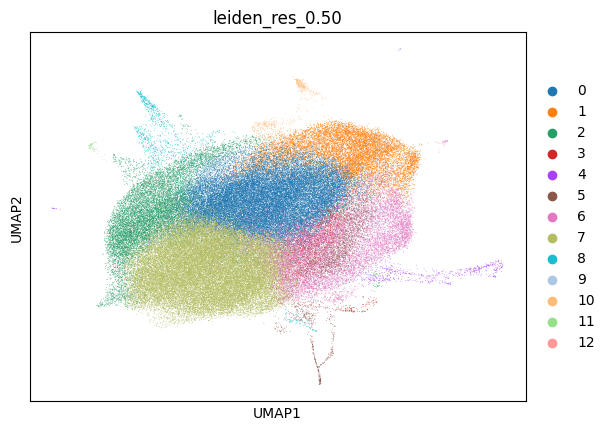

In [ ]:
sc.pl.umap(adata_filtered, color="leiden_res_0.50")

Generate TF KO table:

In [ ]:
cluster_filt_9_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.50", 20)
cluster_filt_9_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    36  ARHGAP35    38  ARHGAP35    12  ARHGAP35    26     DNMT1   
1      DNMT1    30     ZFP41    38    ZNF383    10     ZFP41    24     ZFP41   
2   ARHGAP35    29   ZNF354A    33     ZFP41     8   ZNF354A    22  ARHGAP35   
3     CHAMP1    28     FOXH1    29    CHAMP1     6    ZFP69B    20    CHAMP1   
4     ZBTB22    26    THAP12    29      EBF2     6    SETDB1    18    ZNF462   
5      FOXH1    25     DNMT1    28      ESR1     6     PCGF6    17     NANOG   
6     SETDB1    24    CHAMP1    24     DMRT2     5      E2F4    16    ZBTB22   
7    ZNF354A    23      ZFP1    24     FOXS1     5      ETS1    15     DOT1L   
8      FOXS1    22     FOXK2    23     TBX20     5      ETV1    15   ZNF354A   
9       SOX4    19     DOT1L    22    ZNF521     5     SHOX2    15      ETV1   
10    ZNF205    19     FOXS1    22    BARHL1     4     SMAD4    15     PCGF6   
11    ZNF219    19   NEUROD4    22      ETS1     4     NANOG    14      E2F4   
12    ZNF383    19     PCGF6    22      MITF     4    ZNF75D    14     ESRRA   
13     ATOH1    18      ETS1    21     NFIL3     4    ZBTB22    13     TIGD2   
14      ZFP1    18      ETV1    21    PRDM12     4    ZNF462    13    ZNF219   
15      RBPJ    17     PITX3    21    SETDB1     4    BHLHA9    12    ZNF383   
16    ZNF75D    17      PURG    21    ZBTB22     4    CREBL2    12    ZNF418   
17     BARX1    16    SETDB1    21    ZNF75D     4     DOT1L    12     NFIL3   
18      ETS1    16     SHOX2    21   ZNF354A     4     FOXH1    12      SOX4   
19    THAP12    16      SOX4    21    AKAP8L     3    MTERF4    12     FOXH1   

         cluster 5       cluster 6       cluster 7       cluster 8        
   count     TF KO count     TF KO count     TF KO count     TF KO count  
0     69     ZFP41    61     ZFP41     3    POU5F1    93     ATOH1     3  
1     36  ARHGAP35    44      ESR1     2    ZNF521    52      E2F4     3  
2     33     SHOX2    38     FOXK1     2     PHF20    45     FOXH1     3  
3     31    CHAMP1    35      HES6     2    POU3F2    43     ZNF32     3  
4     30    ZNF844    32      HES7     2   POU5F1B    43      CBX2     2  
5     27     THAP6    30      MTF2     2    ZNF396    38   CREB3L4     2  
6     26    ZFP69B    30     TIGD6     2    HOXD13    35      MXD1     2  
7     25     ESRRA    29    ZFP69B     2     NANOG    15   NEUROD4     2  
8     24      HES6    29    ZNF75D     2    PRDM14    12    SETDB2     2  
9     23   ZNF354A    29   ZNF354A     2      PURG    12       SRF     2  
10    23     NFIL3    28    ZNF383     2      RBPJ     6      ZHX1     2  
11    22     PCGF6    28    ZNF614     2     FOXS1     5  ARHGAP35     1  
12    22     TBX20    28    ZNF692     2   NANOGP8     5     ASH1L     1  
13    22      ZFP1    28    AKAP8L     1   NEUROD4     4     BARX1     1  
14    22    ZNF219    28    BARHL1     1    SETDB2     4    BHLHA9     1  
15    21    ZNF510    28     BARX1     1      ZHX1     4      EBF2     1  
16    20      ETS1    27       BSX     1    ZNF418     4      ELK1     1  
17    19     FOXH1    27     CENPB     1  ARHGAP35     3      ESR1     1  
18    19   NEUROD4    27    CREBL2     1     ATOH1     3      ETS1     1  
19    18    ZNF394    27     DOT1L     1      CBX2     3     FOXK2     1

Some clusters still have few TFs, so we will run Leiden clustering again at lower resolutions:

In [ ]:
for res in [0.2, 0.3, 0.4]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res_0.20', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res_0.30', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res_0.40', the cluster labels (adata.obs, categorical) (0:00:03)


Display the TF KO table for the resolution=0.20 condition

In [ ]:
cluster_filt_03_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.30", 20)
cluster_filt_03_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0   ARHGAP35    67     ZFP41    99  ARHGAP35    40     ESRRB     1  ARHGAP35   
1      ZFP41    64     DNMT1    77     ZFP41    40     SNAI1     1    CHAMP1   
2      DNMT1    55  ARHGAP35    70   ZNF354A    37     TIGD6     1      ESR1   
3      FOXH1    48    CHAMP1    65     NANOG    29    ZBTB42     1     ZFP41   
4     CHAMP1    46   ZNF354A    55      SHOX    26    ZNF844     1    ZNF383   
5     SETDB1    44    ZNF462    53      ETS1    25                    AKAP8L   
6    ZNF354A    44     SHOX2    51    ZFP69B    25                    BARHL1   
7     ZBTB22    43      HES6    49     SHOX2    24                     DMRT2   
8      DOT1L    40    ZNF219    48    SETDB1    23                      EBF2   
9       ZFP1    40     ESRRA    47    ZNF75D    23                     NFIL3   
10    ZNF383    40     FOXH1    45    ZNF394    23                   FOXD4L5   
11     FOXS1    37     NFIL3    45      ETV1    22                     FOXE3   
12     PCGF6    37    ZNF383    45     SMAD4    22                     FOXH1   
13      SOX4    37      ETS1    44      E2F4    21                     FOXK1   
14    THAP12    37      SOX4    44     PCGF6    21                     FOXS1   
15    ZNF75D    35     TBX20    44    CHAMP1    20                      HES6   
16   NEUROD4    33    ZNF844    44     FOXS1    20                    KCNIP3   
17     TBX20    33     FOXJ2    43    ZBTB22    20                    MTERF4   
18     SHOX2    32    ZFP69B    43    CREBL2    19                    PRDM12   
19    ZNF205    32     PCGF6    42     DOT1L    19                       SCX   

         cluster 5       cluster 6        
   count     TF KO count     TF KO count  
0      5    POU5F1    92     ATOH1     3  
1      4    ZNF521    52      E2F4     3  
2      4     PHF20    45     FOXH1     3  
3      4    POU3F2    43     ZNF32     3  
4      4   POU5F1B    43      CBX2     2  
5      3    ZNF396    37   CREB3L4     2  
6      3    HOXD13    35      MXD1     2  
7      3     NANOG     8   NEUROD4     2  
8      3    PRDM14     6    SETDB2     2  
9      3      RBPJ     6       SRF     2  
10     2   NEUROD4     4      ZHX1     2  
11     2      ZHX1     4  ARHGAP35     1  
12     2    ZNF418     4     ASH1L     1  
13     2  ARHGAP35     3     BARX1     1  
14     2     ATOH1     3    BHLHA9     1  
15     2      CBX2     3      EBF2     1  
16     2     FOXS1     3      ELK1     1  
17     2     NR1D1     3      ESR1     1  
18     2      PURG     3      ETS1     1  
19     2    SETDB2     3     FOXK2     1

Continue to run clustering with lower resolutions until we get a reasonable number of TF KOs per cluster:

In [ ]:
for res in [0.05, 0.08, 0.1]:
    sc.tl.leiden(adata_filtered, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.05', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.08', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res_0.10', the cluster labels (adata.obs, categorical) (0:00:03)


In [ ]:
cluster_filt_01_tf_kos_counts_df = tf_ko_cluster_df_from_adata(adata_filtered, "leiden_res_0.10", 20)
cluster_filt_01_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3      
       TF KO count     TF KO count     TF KO count     TF KO count
0      ZFP41   206     ATOH1     3    POU5F1    90  ARHGAP35     4
1   ARHGAP35   179      E2F4     3    ZNF521    46    CHAMP1     4
2      DNMT1   150     FOXH1     3     PHF20    44     NFIL3     3
3    ZNF354A   136     ZNF32     3   POU5F1B    42    ZNF383     3
4     CHAMP1   131      CBX2     2    POU3F2    41    BARHL1     2
5      FOXH1   112   CREB3L4     2    ZNF396    36     DMRT2     2
6      SHOX2   109      MXD1     2    HOXD13    32      EBF2     2
7     ZBTB22   105   NEUROD4     2      RBPJ     5      ESR1     2
8     ZNF383   102    SETDB2     2   NEUROD4     4   FOXD4L5     2
9       ETS1   100       SRF     2     ATOH1     3     FOXE3     2
10     PCGF6   100      ZHX1     2     FOXS1     3     FOXK1     2
11    ZNF75D   100  ARHGAP35     1      ZHX1     3     FOXS1     2
12    ZNF219    99     ASH1L     1  ARHGAP35     2      HES6     2
13      SOX4    98     BARX1     1     IKZF5     2    PRDM12     2
14      ZFP1    98    BHLHA9     1      ISL1     2     TCF12     2
15     FOXS1    97      EBF2     1     MEOX2     2     TIGD6     2
16    ZFP69B    97      ELK1     1      MXD1     2    ZBTB22     2
17    ZNF462    95      ESR1     1    SETDB2     2     ZFP30     2
18     NANOG    92      ETS1     1     SMAD4     2     ZFP41     2
19     DOT1L    91     FOXK2     1    TCF7L2     2    ZNF75D     2

### Generate UMAPs

Now we want to subset the cells that are TF KOs and the genes that display a |LFC| > 0.25 in at least one cell. Read in the data:

In [ ]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

There are 4104/3 = 1368 unique strong perturbations in the dataset, which is close to the 1332 strong perturbations found in the Mali lab paper

Filter `deg_df` to only show DEGs for TF KOs

In [ ]:
deg_df[[col for col in deg_df.columns if col.split("_")[0] in tfs]]

POU5F1_DEGs  POU5F1_L2FC  POU5F1_Adj_P PHF20_DEGs  PHF20_L2FC  \
0                DGKB    -6.076206      0.020763   SLC22A23   -4.365596   
1               AP3B2    -5.457997      0.046913     ATG101   -4.360231   
2               TRNP1    -5.160944      0.004823      ORAI1   -4.315618   
3     ENSG00000259048    -5.015852      0.000079     SUCLG1   -3.572351   
4              SYNPO2    -4.207629      0.040667     ZNF581   -3.460301   
...               ...          ...           ...        ...         ...   
1833  ENSG00000254202     8.638068      0.000195        NaN         NaN   
1834             DLX5     8.798191      0.000137        NaN         NaN   
1835            MEIS2     9.215727      0.000053        NaN         NaN   
1836             DLK1     9.618622      0.000020        NaN         NaN   
1837             SIX3     9.650722      0.000019        NaN         NaN   

      PHF20_Adj_P      POU3F2_DEGs  POU3F2_L2FC  POU3F2_Adj_P  \
0        0.002348              MYC    -3.849306      0.004563   
1        0.044251             OCLN    -3.215691      0.026427   
2        0.048677           DBNDD2    -3.139128      0.006128   
3        0.003897  ENSG00000289399    -3.050469      0.002413   
4        0.037650             PEX7    -2.853733      0.021551   
...           ...              ...          ...           ...   
1833          NaN              NaN          NaN           NaN   
1834          NaN              NaN          NaN           NaN   
1835          NaN              NaN          NaN           NaN   
1836          NaN              NaN          NaN           NaN   
1837          NaN              NaN          NaN           NaN   

         POU5F1B_DEGs  ...  GRHL2_Adj_P  ETS1_DEGs ETS1_L2FC  ETS1_Adj_P  \
0     ENSG00000289399  ...     0.026750     TMSB10 -0.455466    0.048759   
1              ZNF134  ...     0.002374      ROBO2 -0.430676    0.048759   
2                STC2  ...     0.000007      RPS13 -0.315417    0.048759   
3               LIN7A  ...     0.002192       PTMA -0.204787    0.048759   
4               DISC1  ...     0.004888     LARGE1  0.445472    0.048759   
...               ...  ...          ...        ...       ...         ...   
1833              NaN  ...          NaN        NaN       NaN         NaN   
1834              NaN  ...          NaN        NaN       NaN         NaN   
1835              NaN  ...          NaN        NaN       NaN         NaN   
1836              NaN  ...          NaN        NaN       NaN         NaN   
1837              NaN  ...          NaN        NaN       NaN         NaN   

      ZFP90_DEGs ZFP90_L2FC  ZFP90_Adj_P  PRDM12_DEGs PRDM12_L2FC  \
0          RPL36  -0.737517     0.017758        VPS35   -2.742694   
1          RPS4X  -0.589254     0.025551       COX7A2   -0.953482   
2          PRDX1  -0.568617     0.019436       LIN28A   -0.661256   
3          RPL41  -0.426725     0.015435        RPL39   -0.377708   
4          RPS14  -0.397393     0.034280        GRID2    0.378888   
...          ...        ...          ...          ...         ...   
1833         NaN        NaN          NaN          NaN         NaN   
1834         NaN        NaN          NaN          NaN         NaN   
1835         NaN        NaN          NaN          NaN         NaN   
1836         NaN        NaN          NaN          NaN         NaN   
1837         NaN        NaN          NaN          NaN         NaN   

      PRDM12_Adj_P  
0         0.019544  
1         0.028350  
2         0.028941  
3         0.010679  
4         0.000166  
...            ...  
1833           NaN  
1834           NaN  
1835           NaN  
1836           NaN  
1837           NaN  

[1838 rows x 687 columns]

There are 687/3 = 229 unique TF KOs in the dataset.

Write function to get the set of DEGs with a |LFC| > a given threshold

In [ ]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25):
    # Subset TF KOs in DataFrame
    deg_df = deg_df[[col for col in deg_df.columns if col.split("_")[0] in tfs]]
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for tf in tfs:
        deg_col = f"{tf}_DEGs"
        l2fc_col = f"{tf}_L2FC"
        if deg_col in deg_df.columns and l2fc_col in deg_df.columns:
            lfc_degs.update(deg_df.loc[deg_df[l2fc_col].abs() > lfc_threshold, deg_col])
    return lfc_degs

We want to filter the dataset and keep DEGs that have a |LFC| > 0.25 in any TF KO cell.

In [ ]:
# Filter DEGs
degs_lfc_filt = filter_degs_lfc(deg_df)
# Display number of DEGs
print(f"Number of DEGs with |LFC| > 0.25: {len(degs_lfc_filt)}")
# Display first 5 DEGs in set
first_5 = list()
count = 0
for item in degs_lfc_filt:
    first_5.append(item)
    count += 1
    if count >= 5:
        break
print(f"Print 5 DEGs in filtered set: {first_5}")

Number of DEGs with |LFC| > 0.25: 3254
Print 5 DEGs in filtered set: ['UBE2I', 'QKI', 'CCT2', 'ENSG00000260126', 'DEPDC1']


Filter `adata` to only include rows (cells) = TF KOs and columns (genes) = DEGs with |LFC| > 0.25 in any cell

In [ ]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_filt = adata[adata.obs["gene_target"].isin(tfs)]
print(f"number of cells after filtering: {adata_filt.obs.shape[0]}")
print(f"number of genes before filtering: {len(adata_filt.var)}")
adata_filt = adata_filt[:, adata_filt.var_names.isin(degs_lfc_filt)].copy()
print(f"number of genes after filtering: {len(adata_filt.var)}")
adata_filt

number of cells before filtering: 111902
number of cells after filtering: 13064
number of genes before filtering: 37567


number of genes after filtering: 3254


AnnData object with n_obs × n_vars = 13064 × 3254
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

The preprocessing steps of normalization (in this case, to the median UMI count of NTC cells) and log1p transformation have already been performed. The data has also been z-normalized as part of batch correction, so scaling does not need to be performed. 

Now we will perform PCA and visualize the elbow plot to determine how many PCs to use for k-nearest neighbors computation.

computing PCA
    with n_comps=50
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


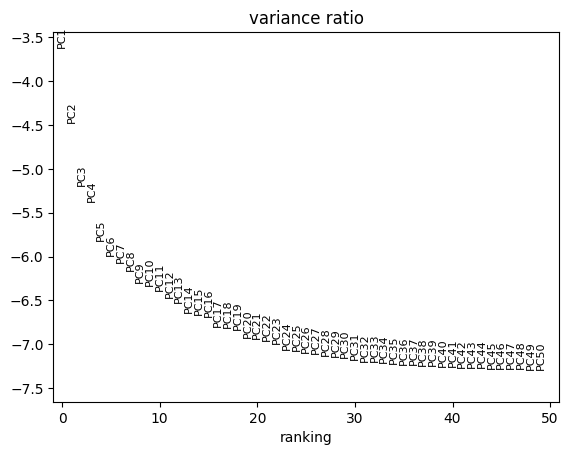

In [ ]:
sc.tl.pca(adata_filt)
sc.pl.pca_variance_ratio(adata_filt, n_pcs=50, log=True) #Elbow plot

Based on the elbow plot, we will use the first 30 PCs to compute the neighborhood. Now we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization.

In [ ]:
num_pcs = 30 # Change this to desired number of principal components
sc.pp.neighbors(adata_filt, n_pcs=num_pcs)
sc.tl.umap(adata_filt)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:20)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


We will perform Leiden clustering at a few different resolutions:

In [ ]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata_filt, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:00)


Save:

In [ ]:
#adata_filt.write_h5ad("/home/ranwyl/data_tf_project/tf_ko_by_deg.h5ad")

Visualize the UMAPs

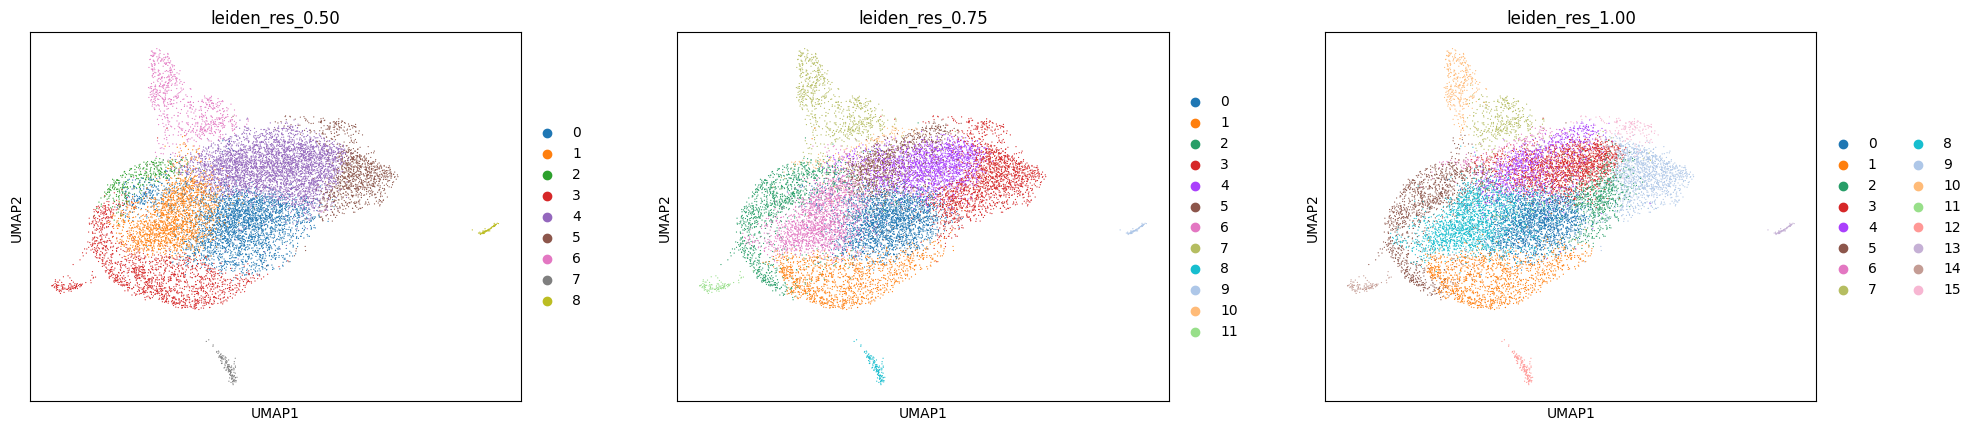

In [ ]:
sc.pl.umap(adata_filt, color=["leiden_res_0.50", "leiden_res_0.75", "leiden_res_1.00"], wspace=0.2, size=3)

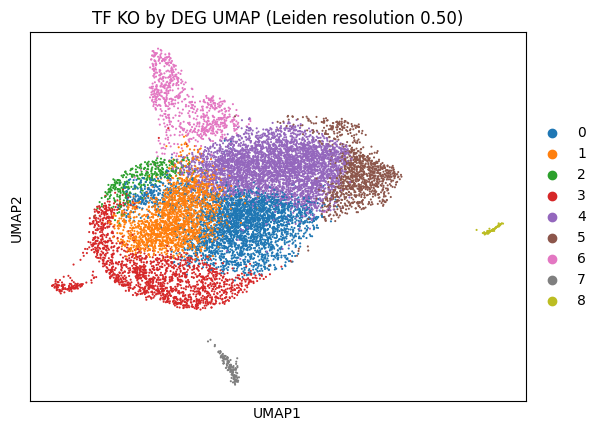

In [ ]:
sc.pl.umap(adata_filt, color="leiden_res_0.50", title="TF KO by DEG UMAP (Leiden resolution 0.50)")

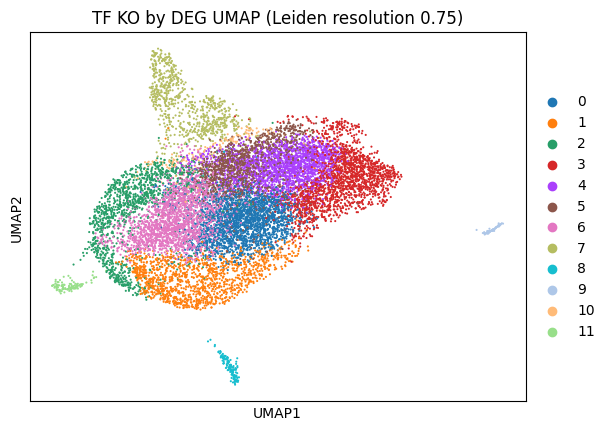

In [ ]:
sc.pl.umap(adata_filt, color="leiden_res_0.75", title="TF KO by DEG UMAP (Leiden resolution 0.75)")

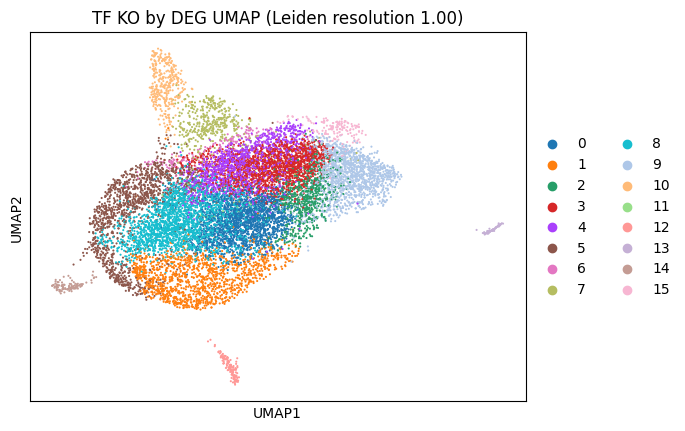

In [ ]:
sc.pl.umap(adata_filt, color="leiden_res_1.00", title="TF KO by DEG UMAP (Leiden resolution 1.00)")

### Summary stats

View TFs and occurrences per cluster for resolution 1:

In [ ]:
cluster_tf_kos_1 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_1.00"))
cluster_tf_kos_1

gene_target      AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
leiden_res_1.00                                                                 
0                     3      15        28      7      5      5     15       4   
1                     3       2        24      7      6      3      5       4   
2                     4       4         5      8      3      1      3       2   
3                     8       7        23      9      6      4      8       9   
4                     8       3        15      3      6      2      7       3   
5                     5       1        24      4      6      2     12       9   
6                     0       0         4      2      0      2      1       2   
7                     1       1         5      0      0      0      3       1   
8                    10       3        33      4      9     11      9      10   
9                     2       4        18      4      5      1      8       8   
10                    0       0         0      0      0      0      0       0   
11                    0       0         0      0      0      0      0       0   
12                    0       0         0      0      0      0      0       0   
13                    0       0         1      0      1      0      3       0   
14                    0       0         5      0      0      0      0       2   
15                    1       0         1      0      0      0      1       1   

gene_target      BARX1  BHLHA9  ...  ZNF732  ZNF735  ZNF780A  ZNF783  ZNF823  \
leiden_res_1.00                 ...                                            
0                   14      16  ...       9       6        5       2       5   
1                    6       7  ...       1       6        2       5       2   
2                    3       3  ...       3       2        2       2       3   
3                   11      13  ...      12       7        8       4       7   
4                    7       7  ...       2       2        2       3       5   
5                   10       9  ...       2       4        2       2       3   
6                    3       0  ...       0       1        0       4       0   
7                    0       1  ...       1       0        1       1       0   
8                   17      12  ...       7       8        5       9       2   
9                   10       9  ...       5       6        6       5       4   
10                   0       0  ...       0       0        0       0       0   
11                   0       0  ...       0       0        0       0       0   
12                   0       0  ...       0       0        0       0       0   
13                   1       1  ...       0       0        0       0       0   
14                   0       0  ...       0       0        0       0       0   
15                   2       1  ...       0       0        0       0       0   

gene_target      ZNF844  ZNF888  ZSCAN18  ZSCAN25  ZSCAN32  
leiden_res_1.00                                             
0                    15       6        7        8        4  
1                     6       5        3        3        4  
2                     6       1        3        3        6  
3                    10       8       12        5        6  
4                     9       1        5        1        3  
5                     3       4        9        2        7  
6                     0       0        0        0        1  
7                     2       1        1        0        2  
8                    13       4        9        3        4  
9                    10       5        8        2        5  
10                    0       0        0        0        0  
11                    0       0        0        0        0  
12                    0       0        0        0        0  
13                    1       0        1        0        0  
14                    0       0        1        0        1  
15                    3       3        0        0        0  

[

In [ ]:
def cluster_tf_ko_summary_stats(cluster_tf_ko_df):
    cells_per_cluster = np.sum(cluster_tf_ko_df, axis=1).tolist()
    tf_kos_per_cluster = np.count_nonzero(cluster_tf_ko_df, axis=1).tolist()
    df = pd.DataFrame(
        {"Cluster":[i for i in range(cluster_tf_ko_df.shape[0])],
        "Cells per cluster": cells_per_cluster,
        "TF KOs per cluster": tf_kos_per_cluster
        })
    return df

def plot_cluster_info(df, title=None):
    fig, axes = plt.subplots(2, 1, figsize=(4, 6))
    sns.barplot(data=df, x="Cluster", y="Cells per cluster", legend=None, ax=axes[0])
    axes[0].set_title(f"Cells per cluster: {title}")
    sns.barplot(data=df, x="Cluster", y="TF KOs per cluster", legend=None, ax=axes[1])
    axes[1].set_title(f"TF KOs per cluster: {title}")
    plt.tight_layout()

In [ ]:
cluster_tf_kos_1_stats = cluster_tf_ko_summary_stats(cluster_tf_kos_1)

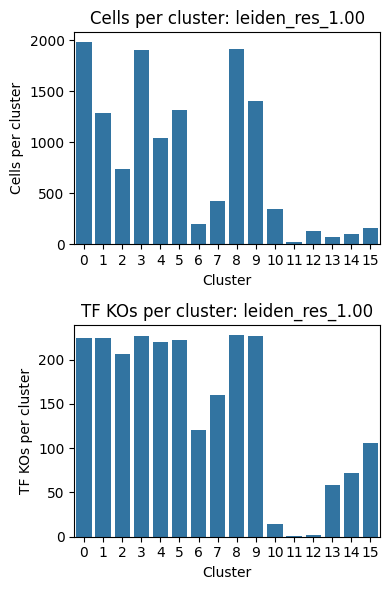

In [ ]:
plot_cluster_info(cluster_tf_kos_1_stats, title="leiden_res_1.00")

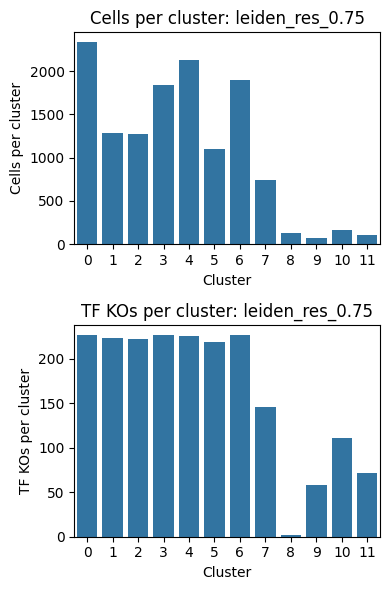

In [ ]:
cluster_tf_kos_075 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_0.75"))
cluster_tf_kos_075_stats = cluster_tf_ko_summary_stats(cluster_tf_kos_075)
plot_cluster_info(cluster_tf_kos_075_stats, title="leiden_res_0.75")

In [ ]:
cluster_tf_kos_05 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_0.50"))
cluster_tf_kos_05_stats = cluster_tf_ko_summary_stats(cluster_tf_kos_05)
plot_cluster_info(cluster_tf_kos_05_stats, title="leiden_res_0.50")

NameError: name 'cluster_tf_ko_summary_stats' is not defined

In [ ]:
cluster_1_tf_kos_counts_df = tf_ko_cluster_df(cluster_tf_kos_1, 20)
cluster_1_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    32  ARHGAP35    24     ZFP41    13     ZFP41    26     ZFP41   
1   ARHGAP35    28      ETS1    18   MSANTD4    12    CHAMP1    25  ARHGAP35   
2    ZNF354A    27     ZFP41    17    ZNF514    11    ZNF219    25    ZNF462   
3       SOX4    26   ZNF354A    17     SMAD4    10  ARHGAP35    23     ESRRA   
4      FOXH1    25      ETV1    15   ZNF354A    10   ZNF354A    21    ZNF383   
5     CHAMP1    24     PCGF6    15      ETS1     9    ZNF462    21     DOT1L   
6      SHOX2    22    SETDB1    14     TBX20     9      ZFP1    19      ESR2   
7      NFIL3    21      E2F4    12     ASCL5     8      E2F4    18      IRX5   
8      FOXS1    20     ESRRA    11     FOXJ2     8     FOXH1    18    THAP12   
9       ETS1    19      SHOX    11     SHOX2     8      SHOX    18    ZNF510   
10      ETV1    17      ZFP1    11    CHAMP1     7     SMAD4    18    CHAMP1   
11     THAP6    17    ZFP69B    11     GATA5     7      SOX4    18      ETV1   
12    ZBTB22    17    ZNF75D    11      MTF2     7    ZBTB22    16     FOXK2   
13    ZFP69B    17    CHAMP1    10   NEUROD4     7    ZNF75D    16      HES6   
14    ZNF394    17    CREBL2    10     NFIL3     7      FOSB    15      JUNB   
15    BHLHA9    16     PITX3    10     NR0B1     7      HES6    15     TBX18   
16      ZFP1    16     SMAD4    10     TIGD2     7     NFIL3    15    ZNF563   
17    ZNF383    16     TBX18    10     ZFP30     7    ZNF383    15    ZNF844   
18    ANKZF1    15     TBX20    10    ZFP69B     7      EBF2    14    AKAP8L   
19     ATOH1    15     TCF12    10      ZHX1     7     THAP6    14      E2F4   

          ... cluster 11       cluster 12       cluster 13       cluster 14  \
   count  ...      TF KO count      TF KO count      TF KO count      TF KO   
0     25  ...     SETDB1    22      DNMT1   133      ATOH1     3   ARHGAP35   
1     15  ...                       TIGD2     1       E2F4     3     CHAMP1   
2     14  ...                                        FOXH1     3      NFIL3   
3     13  ...                                        ZNF32     3     BARHL1   
4     12  ...                                         CBX2     2      DMRT2   
5     11  ...                                      CREB3L4     2       EBF2   
6     11  ...                                         MXD1     2       ESR1   
7     10  ...                                      NEUROD4     2    FOXD4L5   
8     10  ...                                       SETDB2     2      FOXE3   
9     10  ...                                          SRF     2      FOXK1   
10     9  ...                                         ZHX1     2      FOXS1   
11     9  ...                                     ARHGAP35     1       HES6   
12     9  ...                                        ASH1L     1     PRDM12   
13     9  ...                                        BARX1     1      TCF12   
14     9  ...                                       BHLHA9     1      TIGD6   
15     9  ...                                         EBF2     1     ZBTB22   
16     9  ...                                         ELK1     1      ZFP30   
17     9  ...                                         ESR1     1      ZFP41   
18     8  ...                                         ETS1     1     ZNF75D   
19     8  ...                                        FOXK2     1    ZNF354A   

         cluster 15        
   count      TF KO count  
0      5      ZFP41     7  
1      4      IKZF5     4  
2      3     NKX2-4     4  
3      2       ESR2     3  
4      2      ESRRA     3  
5      2      GATA5     3  
6      2       IRX5     3  
7      2      TBPL1     3  
8      2     ZNF594     3  
9      2     ZNF844     3  
10     2     ZNF888     3  
11     2      BARX1     2  
12     2     CHAMP1     2  
13     2      DNMT1     2  
14     2      DOT1L     2  
15     2       ELK1     2  

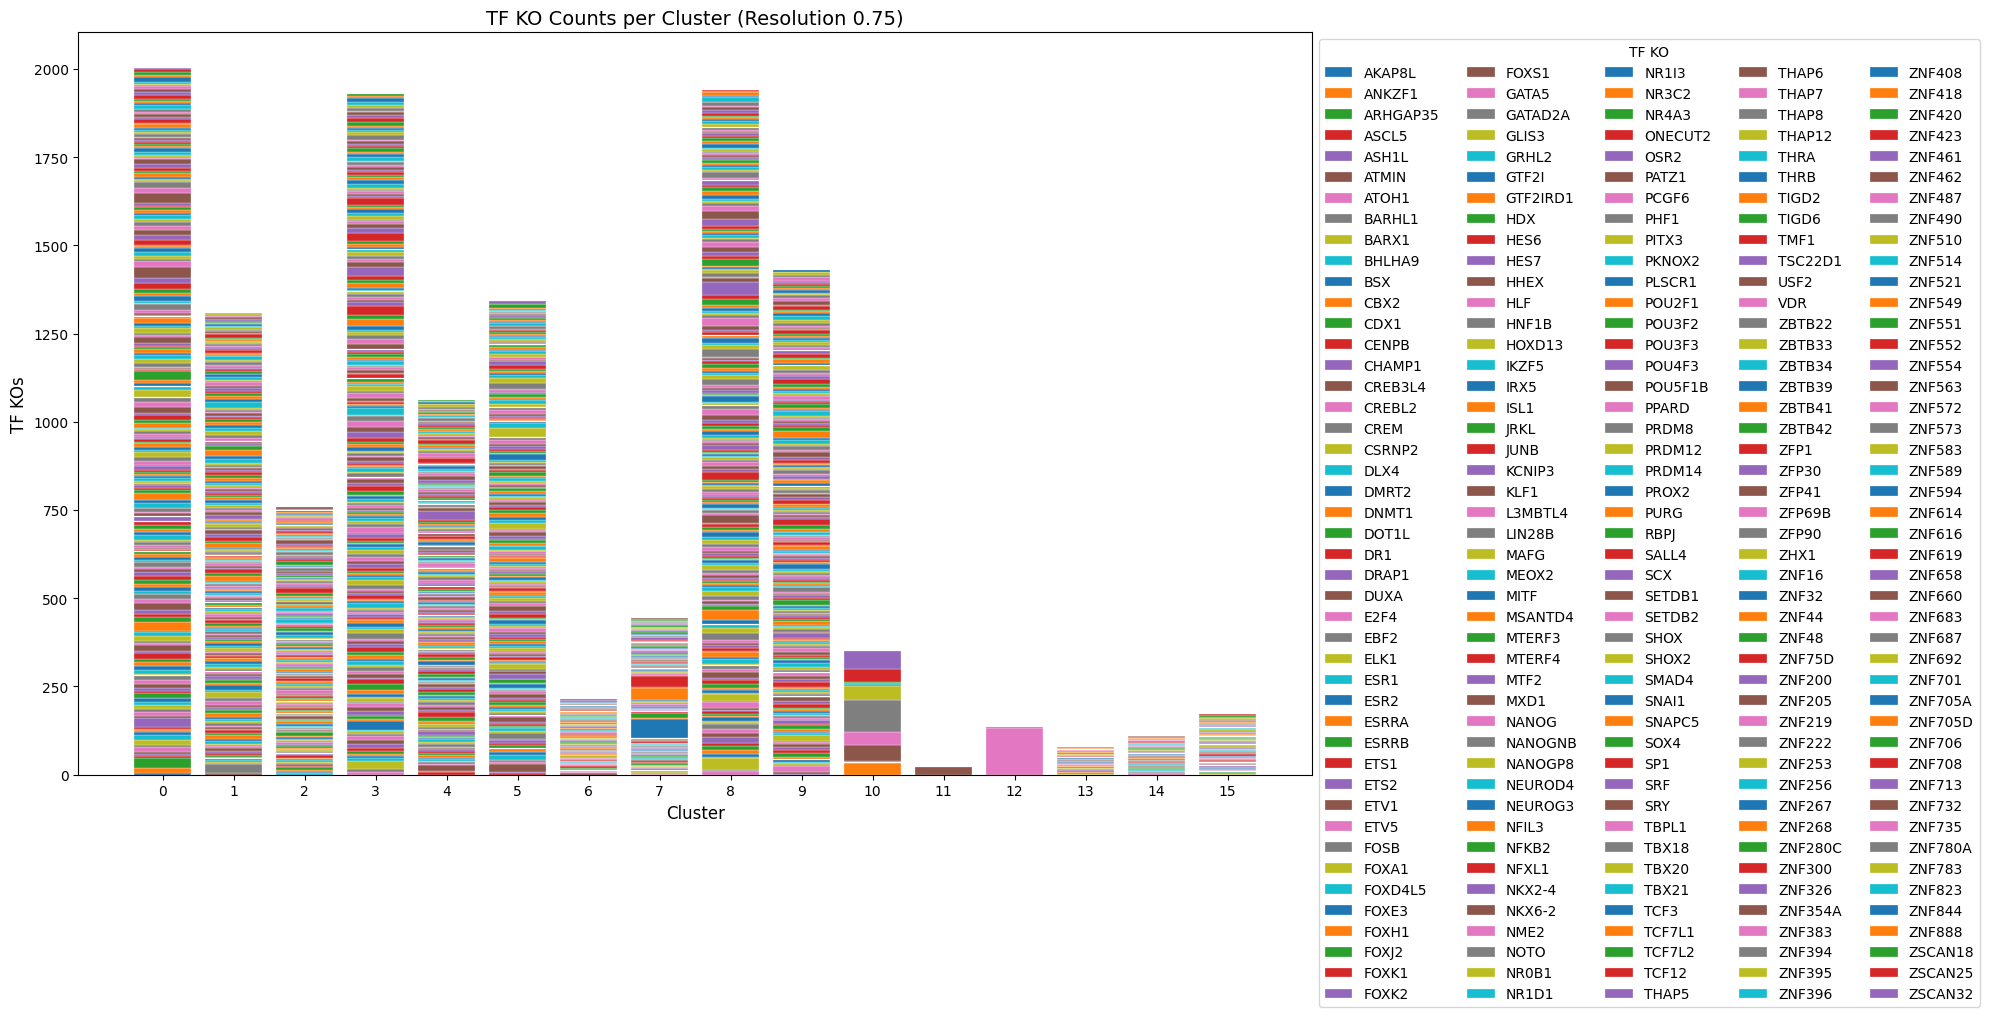

In [ ]:
sns_stacked_bar_lines(cluster_tf_kos_1, title="TF KO Counts per Cluster (Resolution 1.00)")

For resolution 0.75:

In [ ]:
num_tf_kos_per_cluster = 20
cluster_tf_kos_075 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_0.75"))
cluster_075_tf_kos_counts_df = tf_ko_cluster_df(cluster_tf_kos_075, num_tf_kos_per_cluster)
cluster_075_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      FOXH1    33  ARHGAP35    26    SETDB1    40     ZFP41    33     ZFP41   
1      ZFP41    33     ZFP41    20     ZFP41    24    CHAMP1    22    ZNF219   
2   ARHGAP35    32     PCGF6    17  ARHGAP35    23     SHOX2    21    CHAMP1   
3    ZNF354A    31   ZNF354A    17   ZNF354A    17  ARHGAP35    19  ARHGAP35   
4     CHAMP1    28      ETV1    16    CHAMP1    15     GATA5    18    ZNF462   
5       SOX4    28      ETS1    15     DOT1L    15     ESRRA    17      SOX4   
6      FOXS1    25    SETDB1    15    MTERF4    14   NEUROD4    17   ZNF354A   
7      SHOX2    24     ESRRA    12      ZFP1    14     PCGF6    17    ZNF383   
8       ETS1    23     SMAD4    12     FOXH1    13     FOXJ2    16     FOXH1   
9      NFIL3    23    CHAMP1    11     FOXS1    13    NKX2-4    16      HES6   
10    ZFP69B    22    CREBL2    11    THAP12    13     TBX20    16      ZFP1   
11    ZBTB22    21      E2F4    11    ZFP69B    13    ZBTB34    16      E2F4   
12      ZFP1    21     TBX20    11    ZNF219    13    ZFP69B    16      SHOX   
13      ETV1    20    ZFP69B    11    ZNF383    13    ZNF75D    16      EBF2   
14   NEUROD4    20    ZNF75D    11     ATOH1    12    ZNF394    16     SHOX2   
15     FOXJ2    19      SHOX    10      FOSB    12      ETS1    15     SMAD4   
16    ZNF75D    19      SOX4    10      MAFG    12     FOXS1    15    ZBTB22   
17    ZNF383    19     TBX18    10     SHOX2    12      ZFP1    15    ZNF267   
18    BHLHA9    18     TCF12    10    ZBTB22    12    ZNF420    15    ZNF701   
19      SHOX    18    ZBTB22    10    KCNIP3    11    ZNF844    15     DOT1L   

          ... cluster 7       cluster 8       cluster 9       cluster 10  \
   count  ...     TF KO count     TF KO count     TF KO count      TF KO   
0     31  ...    POU5F1    92     DNMT1   132     ATOH1     3     CHAMP1   
1     28  ...    ZNF521    58     TIGD2     1      E2F4     3   ARHGAP35   
2     27  ...     NANOG    57                     FOXH1     3       ETV1   
3     26  ...     PHF20    45                     ZNF32     3      PATZ1   
4     25  ...    POU3F2    42                      CBX2     2    ZNF354A   
5     22  ...   POU5F1B    42                   CREB3L4     2     ZNF783   
6     22  ...    ZNF396    39                      MXD1     2      BARX1   
7     21  ...    PRDM14    38                   NEUROD4     2       ISL1   
8     20  ...    HOXD13    35                    SETDB2     2      NFIL3   
9     20  ...      PURG    32                       SRF     2      PCGF6   
10    19  ...   NANOGP8    17                      ZHX1     2      PRDM8   
11    18  ...      RBPJ     9                  ARHGAP35     1      TBX20   
12    18  ...    ZNF418     7                     ASH1L     1      ASCL5   
13    17  ...  ARHGAP35     5                     BARX1     1      ATMIN   
14    17  ...     FOXS1     5                    BHLHA9     1        BSX   
15    17  ...    SETDB2     5                      EBF2     1     CREBL2   
16    17  ...     ESRRA     4                      ELK1     1       CREM   
17    17  ...   NEUROD4     4                      ESR1     1      DOT1L   
18    17  ...     NR1D1     4                      ETS1     1       E2F4   
19    16  ...     PITX3     4                     FOXK2     1       ESR1   

         cluster 11        
   count      TF KO count  
0      6   ARHGAP35     5  
1      4     CHAMP1     4  
2      4      NFIL3     3  
3      4     BARHL1     2  
4      4      DMRT2     2  
5      4       EBF2     2  
6      3       ESR1     2  
7      3    FOXD4L5     2  
8      3      FOXE3     2  
9      3      FOXK1     2  
10     3      FOXS1     2  
11     3       HES6     2  
12     2     PRDM12     2  
13     2      TCF12     2  
14     2      TIGD6     2  
15     2     ZBTB22     2  
16     2      ZFP30     2  
17     2      ZFP41     2  
18     2 

Plot all TF KOs and occurrences in a cluster:

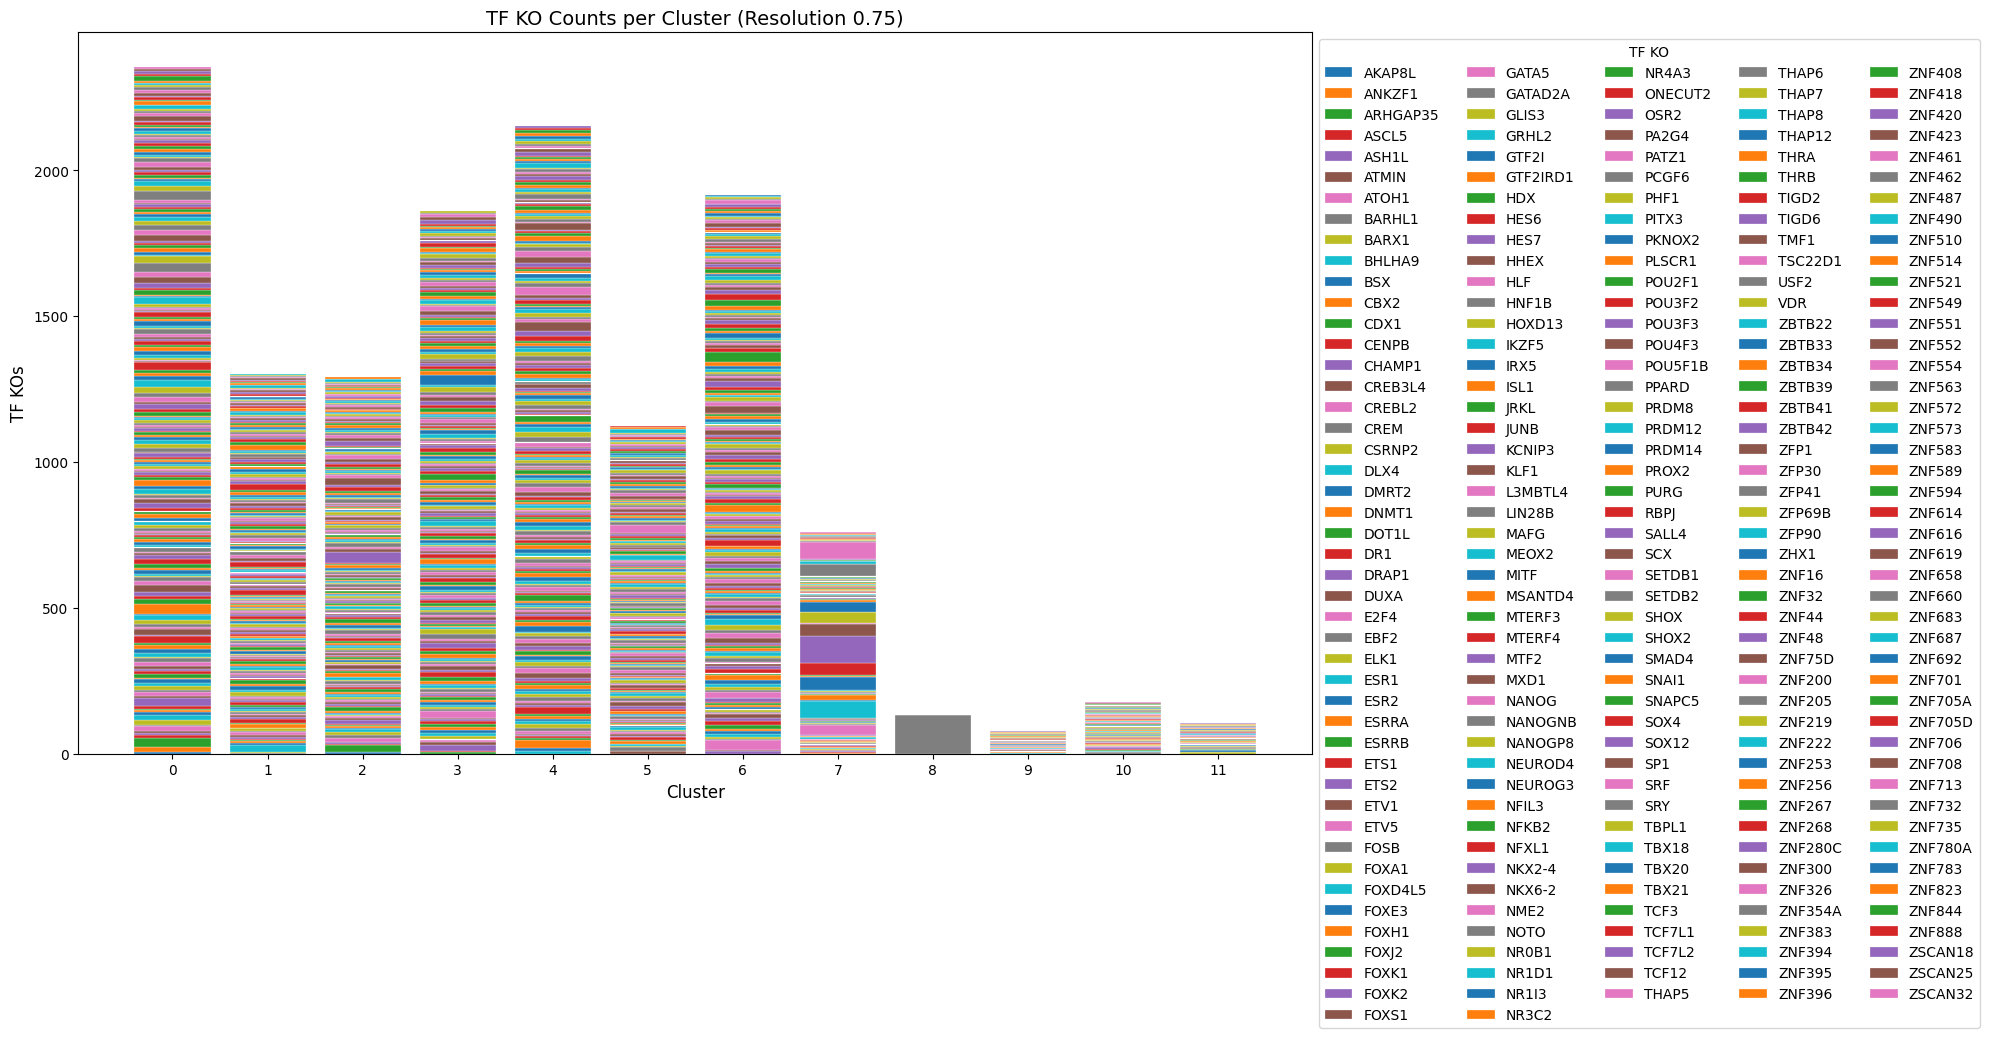

In [ ]:
sns_stacked_bar_lines(cluster_tf_kos_075, title="TF KO Counts per Cluster (Resolution 0.75)")

In [ ]:
num_tf_kos_per_cluster = 20
cluster_tf_kos_05 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_0.50"))
cluster_05_tf_kos_counts_df = tf_ko_cluster_df(cluster_tf_kos_05, num_tf_kos_per_cluster)
cluster_05_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0     SETDB1    53  ARHGAP35    41     ZFP41    15  ARHGAP35    37     ZFP41   
1      ZFP41    48     ZFP41    32     ESRRB     7     ZFP41    28    CHAMP1   
2    ZNF354A    42     FOXS1    25  ARHGAP35     6   ZNF354A    25  ARHGAP35   
3      FOXH1    37    THAP12    25      ISL1     6    SETDB1    19    ZNF462   
4   ARHGAP35    35   ZNF354A    24     ATOH1     5    CHAMP1    18    ZNF219   
5     CHAMP1    33     PCGF6    23   CREB3L4     5      ETS1    18   ZNF354A   
6      FOXS1    32     DOT1L    22     DOT1L     5    ZFP69B    18     FOXH1   
7       SOX4    32   NEUROD4    22    MTERF3     5     PCGF6    16    ZNF383   
8      SHOX2    31    ZBTB22    22     TBX20     5    ZNF75D    16     PCGF6   
9     ZNF383    31    ZNF383    20    ZBTB22     5     DOT1L    15      ZFP1   
10      ZFP1    30     FOXH1    19    ZNF205     5      E2F4    15    ZBTB22   
11      ETS1    28     BARX1    17     ESRRA     4     SHOX2    15     ESRRA   
12     NFIL3    28    ZNF75D    17     FOXH1     4     ESRRA    14      HES6   
13    ZBTB22    27     PPARD    16     IKZF5     4      ETV1    14    ZFP69B   
14    ZNF75D    26     SHOX2    16      MXD1     4     FOXS1    14      ETV1   
15      ETV1    25      SOX4    16    POU3F3     4      MAFG    14     FOXJ2   
16     TIGD2    25     TIGD2    16      RBPJ     4    ZBTB42    14      SHOX   
17    ZFP69B    25    ZNF219    16      SOX4     4     DMRT2    13     SMAD4   
18    ZNF205    25    CHAMP1    15    THAP12     4      FOSB    13    ZNF75D   
19     FOXJ2    24      ETS1    15   ZNF354A     4   FOXD4L5    13     DOT1L   

         cluster 5       cluster 6       cluster 7       cluster 8        
   count     TF KO count     TF KO count     TF KO count     TF KO count  
0     68  ARHGAP35    16    POU5F1    93     DNMT1   129     ATOH1     3  
1     49    ZBTB34    16    ZNF521    59     TIGD2     1      E2F4     3  
2     46     SHOX2    15     NANOG    56                     FOXH1     3  
3     42     ZFP41    15     PHF20    45                     ZNF32     3  
4     41    CHAMP1    14   POU5F1B    43                      CBX2     2  
5     36    NKX2-4    14    POU3F2    42                   CREB3L4     2  
6     35     ESRRA    12    ZNF396    39                      MXD1     2  
7     35   FOXD4L5    12    PRDM14    37                   NEUROD4     2  
8     34     PCGF6    11    HOXD13    35                    SETDB2     2  
9     34     TBX20    11      PURG    33                       SRF     2  
10    33    ZNF394    11   NANOGP8    18                      ZHX1     2  
11    32     GATA5    10      RBPJ     7                  ARHGAP35     1  
12    31   NEUROD4    10    ZNF418     7                     ASH1L     1  
13    31    ZNF75D    10     FOXS1     5                     BARX1     1  
14    30    ZNF510    10    SETDB2     5                    BHLHA9     1  
15    30    ZNF658    10      ZHX1     5                      EBF2     1  
16    30     BARX1     9  ARHGAP35     4                      ELK1     1  
17    30      ESR2     9     ESRRA     4                      ESR1     1  
18    30     FOXS1     9   NEUROD4     4                      ETS1     1  
19    29      HES6     9     NR1D1     4                     FOXK2     1

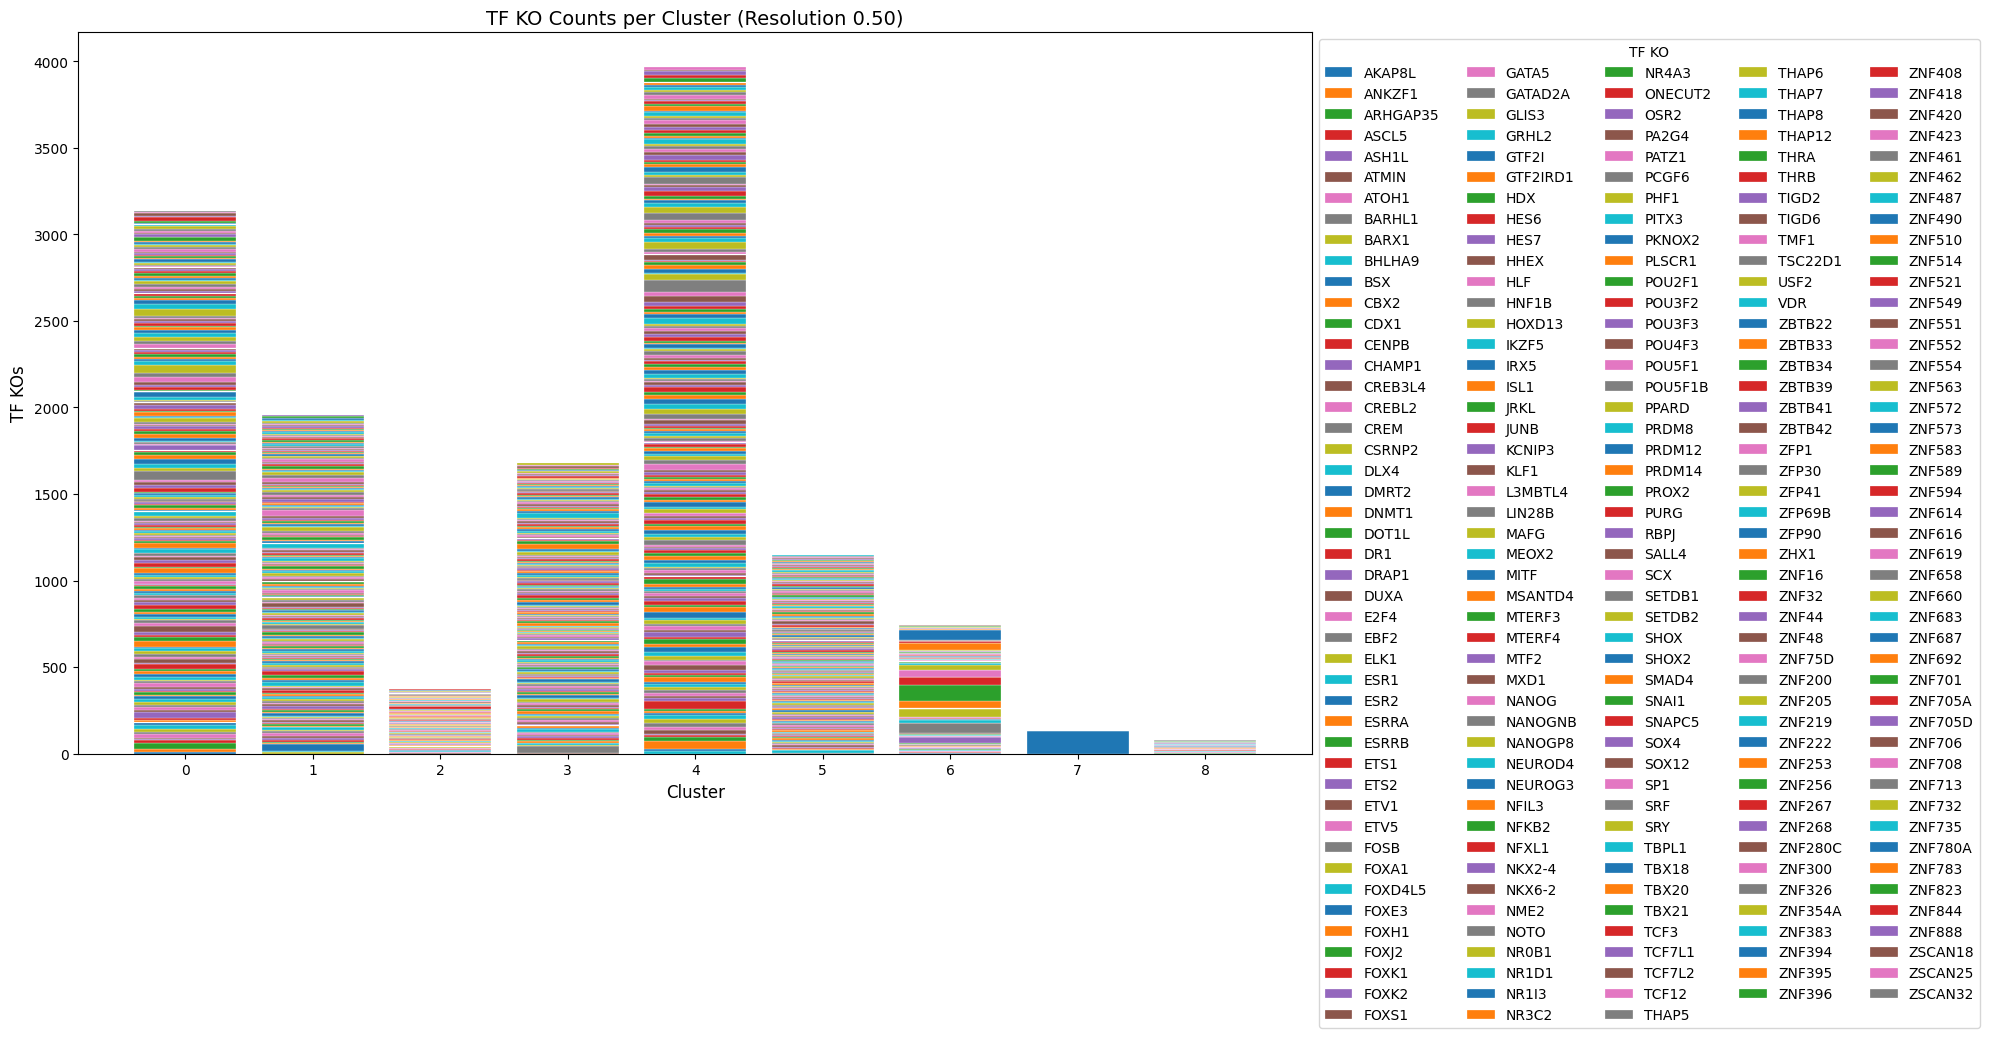

In [ ]:
sns_stacked_bar_lines(cluster_tf_kos_05, title="TF KO Counts per Cluster (Resolution 0.50)")

The preprocessing steps of normalization (in this case, to the median UMI count of NTC cells) and log1p transformation have already been performed. The data has also been z-normalized as part of batch correction, so scaling does not need to be performed. 

Now we will perform PCA and visualize the elbow plot to determine how many PCs to use for k-nearest neighbors computation.

computing PCA
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


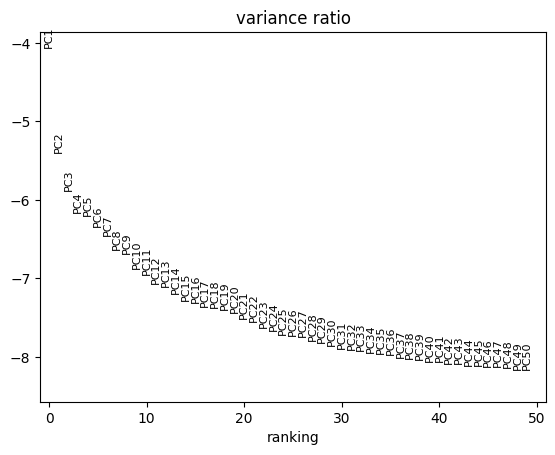

In [ ]:
sc.tl.pca(adata_filt)
sc.pl.pca_variance_ratio(adata_filt, n_pcs=50, log=True) #Elbow plot

Based on the elbow plot, we will use the first 30 PCs to compute the neighborhood. Now we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization.

In [ ]:
num_pcs = 30 # Change this to desired number of principal components
sc.pp.neighbors(adata_filt, n_pcs=num_pcs)
sc.tl.umap(adata_filt)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:31)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:08)


We will perform Leiden clustering at a few different resolutions:

In [ ]:
for res in [0.5, 0.75, 1]:
    sc.tl.leiden(adata_filt, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res_0.75', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:03)


Visualize the UMAPs

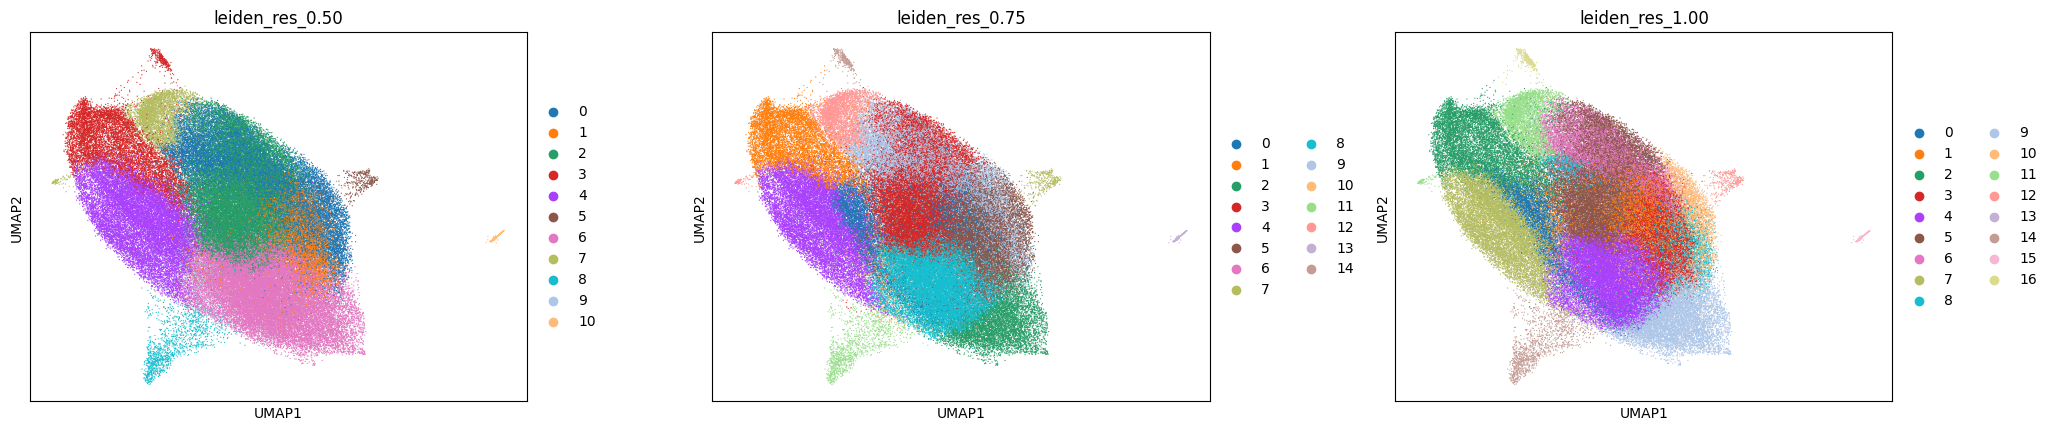

In [ ]:
sc.pl.umap(adata_filt, color=["leiden_res_0.50", "leiden_res_0.75", "leiden_res_1.00"], wspace=0.25, size=3)

Save file

In [ ]:
adata_filt.write_h5ad("/home/ranwyl/data_tf_project/strong_pert_by_lfc_deg.h5ad")

Read in file

In [ ]:
adata_filt = sc.read_h5ad("/home/ranwyl/data_tf_project/strong_pert_by_lfc_deg.h5ad")

Helper functions for plotting

In [ ]:
# Perturbations per cluster

def cluster_summary_df(adata, leiden_res: str):
    """
    Given an AnnData object, create a DataFrame of perturbations in each Leiden cluster 
    at the given resolution.
    """
    # Extract cluster assignments and perturbation labels
    perts_per_cluster_df = adata.obs[[leiden_res, "gene_target"]]
    # Count occurrences of each perturbation in each cluster
    return perts_per_cluster_df.groupby([leiden_res, "gene_target"]).size().unstack(fill_value=0) 

# TF KOs per cluster

def cluster_summary_tf_ko_df(perts_per_cluster_df):
    """
    Filter perturbations-per-cluster DataFrame to show only TF KOs.
    """
    return perts_per_cluster_df.loc[:, perts_per_cluster_df.columns.isin(tfs)]

# Plot number of cells per cluster

def cells_cluster_summary_df(perts_per_cluster_df):
    """
    Given a DataFrame representing perturbations per cluster, where columns are clusters 
    and rows are perturbations, create a DataFrame with the number of cells per cluster. 
    """
    cells_per_cluster = np.sum(perts_per_cluster_df, axis=1).tolist()
    cells_per_cluster_df = pd.DataFrame(
        {"Cluster":[i for i in range(perts_per_cluster_df.shape[0])],
        "Cells per cluster": cells_per_cluster})
    return cells_per_cluster_df

def plot_cells_per_cluster(df):
    """
    Plot a barplot of cells per cluster.
    """
    ax = sns.barplot(data=df, x="Cluster", y="Cells per cluster", legend=None)
    ax.bar_label(ax.containers[0], fontsize=9)

def plot_cells_per_cluster3(df1, df2, df3, title1, title2, title3):
    """
    Given 3 DataFrames of cells per cluster and their plot titles, generate barplots of cells per cluster.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(data=df1, x="Cluster", y="Cells per cluster", legend=None, ax=axes[0][0])
    axes[0][0].bar_label(axes[0][0].containers[0], fontsize=8)
    axes[0][0].set_title(f"Total cells per cluster: {title1}")

    sns.barplot(data=df2, x="Cluster", y="Cells per cluster", legend=None, ax=axes[0][1])
    axes[0][1].bar_label(axes[0][1].containers[0], fontsize=8)
    axes[0][1].set_title(f"Total cells per cluster: {title2}")

    sns.barplot(data=df3, x="Cluster", y="Cells per cluster", legend=None, ax=axes[1][0])
    axes[1][0].bar_label(axes[1][0].containers[0], fontsize=8)
    axes[1][0].set_title(f"Total cells per cluster: {title3}")

    axes[1][1].set_visible(False)
    plt.tight_layout()

# Plot number of TF KO cells per cluster

def tf_ko_cells_cluster_summary_df(perts_per_cluster_df):
   """
   Given a DataFrame representing perturbations per cluster, where columns are clusters 
   and rows are perturbations, create a DataFrame with the number of TF KO cells per cluster. 
   """
   tf_ko_cluster_summary_df = perts_per_cluster_df.loc[:, perts_per_cluster_df.columns.isin(tfs)]
   tf_ko_cells_per_cluster = np.sum(tf_ko_cluster_summary_df, axis=1).tolist()
   tf_ko_cells_per_cluster_df = pd.DataFrame({"Cluster":[i for i in range(tf_ko_cluster_summary_df.shape[0])],
                                              "TF KO cells per cluster": tf_ko_cells_per_cluster})
   return tf_ko_cells_per_cluster_df

def plot_tf_ko_cells_per_cluster3(df1, df2, df3, title1, title2, title3):
    """
    Given 3 DataFrames of TF KO cells per cluster and their plot titles, generate barplots of TF KO cells per cluster.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(data=df1, x="Cluster", y="TF KO cells per cluster", legend=None, ax=axes[0][0])
    axes[0][0].bar_label(axes[0][0].containers[0], fontsize=8)
    axes[0][0].set_title(f"TF KO cells per cluster: {title1}")

    sns.barplot(data=df2, x="Cluster", y="TF KO cells per cluster", legend=None, ax=axes[0][1])
    axes[0][1].bar_label(axes[0][1].containers[0], fontsize=8)
    axes[0][1].set_title(f"TF KO cells per cluster: {title2}")

    sns.barplot(data=df3, x="Cluster", y="TF KO cells per cluster", legend=None, ax=axes[1][0])
    axes[1][0].bar_label(axes[1][0].containers[0], fontsize=8)
    axes[1][0].set_title(f"TF KO cells per cluster: {title3}")

    axes[1][1].set_visible(False)
    plt.tight_layout()

def plot_tf_ko_cells_per_cluster(df, title):
    """
    Plot a barplot of cells per cluster.
    """
    ax = sns.barplot(data=df, x="Cluster", y="TF KO cells per cluster", legend=None)
    ax.bar_label(ax.containers[0], fontsize=9)
    ax.set_title(title)

# Plot number of unique TF KOs per cluster

def unique_tf_ko_cluster_summary_df(perts_per_cluster_df):
    """
    Given a DataFrame representing perturbations per cluster, where columns are clusters 
    and rows are perturbations, create a DataFrame with the number of unique TF KOs per cluster. 
    """
    tf_ko_cluster_summary_df = perts_per_cluster_df.loc[:, perts_per_cluster_df.columns.isin(tfs)]
    tf_kos_per_cluster = np.count_nonzero(tf_ko_cluster_summary_df, axis=1).tolist()
    df = pd.DataFrame({"Cluster":[i for i in range(tf_ko_cluster_summary_df.shape[0])],
        "Unique TF KOs per cluster": tf_kos_per_cluster})
    return df

def plot_unique_tf_kos_per_cluster3(df1, df2, df3, title1, title2, title3):
    """
    Given 3 DataFrames of unique TF KOs per cluster and their plot titles, generate barplots of the 
    number of unique TF KOs per cluster.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.barplot(data=df1, x="Cluster", y="Unique TF KOs per cluster", legend=None, ax=axes[0][0])
    axes[0][0].bar_label(axes[0][0].containers[0], fontsize=8)
    axes[0][0].set_title(f"Unique TF KOs per cluster: {title1}")

    sns.barplot(data=df2, x="Cluster", y="Unique TF KOs per cluster", legend=None, ax=axes[0][1])
    axes[0][1].bar_label(axes[0][1].containers[0], fontsize=8)
    axes[0][1].set_title(f"Unique TF KOs per cluster: {title2}")

    sns.barplot(data=df3, x="Cluster", y="Unique TF KOs per cluster", legend=None, ax=axes[1][0])
    axes[1][0].bar_label(axes[1][0].containers[0], fontsize=8)
    axes[1][0].set_title(f"Unique TF KOs per cluster: {title3}")

    axes[1][1].set_visible(False)
    plt.tight_layout()

In [ ]:
perts_per_cluster_1 = cluster_summary_df(adata_filt, "leiden_res_1.00")
cells_per_cluster_1 = cells_cluster_summary_df(perts_per_cluster_1)
tf_ko_cells_per_cluster_1 = tf_ko_cells_cluster_summary_df(perts_per_cluster_1)
unique_tf_kos_per_cluster_1 = unique_tf_ko_cluster_summary_df(perts_per_cluster_1)

perts_per_cluster_075 = cluster_summary_df(adata_filt, "leiden_res_0.75")
cells_per_cluster_075 = cells_cluster_summary_df(perts_per_cluster_075)
tf_ko_cells_per_cluster_075 = tf_ko_cells_cluster_summary_df(perts_per_cluster_075)
unique_tf_kos_per_cluster_075 = unique_tf_ko_cluster_summary_df(perts_per_cluster_075)

perts_per_cluster_05 = cluster_summary_df(adata_filt, "leiden_res_0.50")
cells_per_cluster_05 = cells_cluster_summary_df(perts_per_cluster_05)
tf_ko_cells_per_cluster_05 = tf_ko_cells_cluster_summary_df(perts_per_cluster_05)
unique_tf_kos_per_cluster_05 = unique_tf_ko_cluster_summary_df(perts_per_cluster_05)

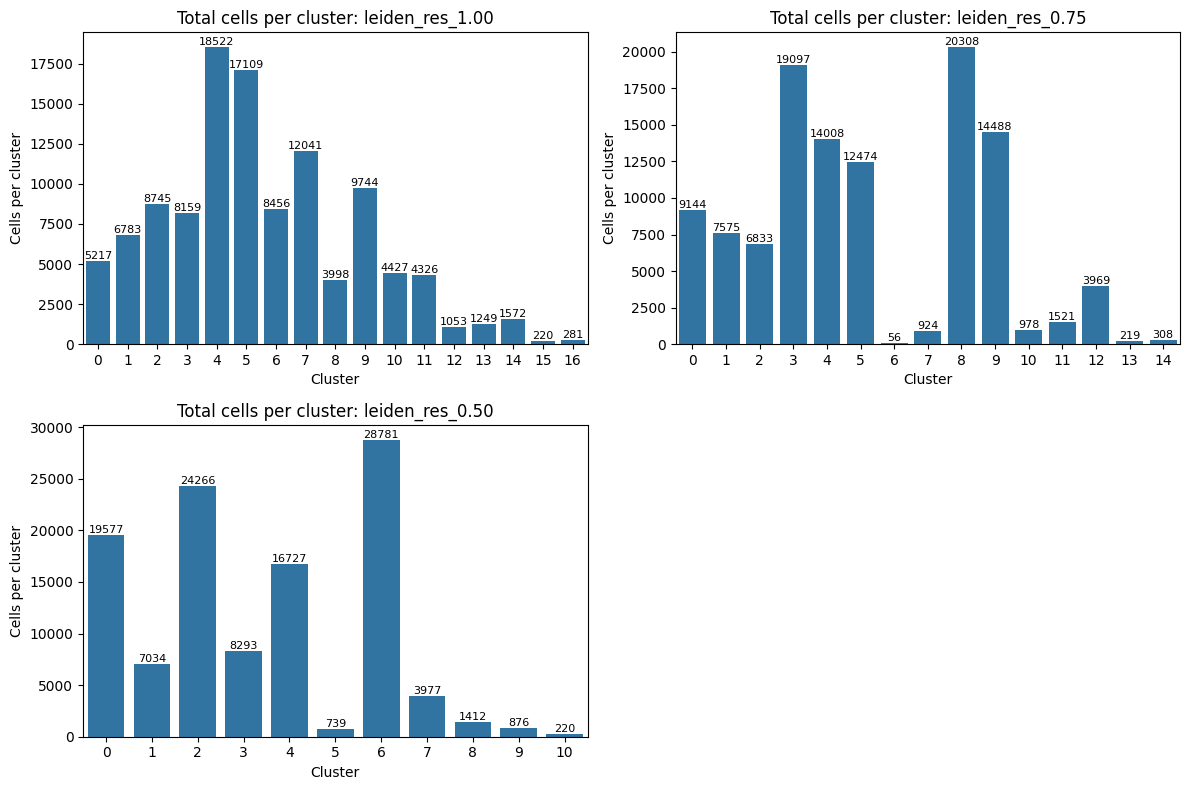

In [ ]:
p = plot_cells_per_cluster3(cells_per_cluster_1, cells_per_cluster_075, cells_per_cluster_05, "leiden_res_1.00", "leiden_res_0.75", "leiden_res_0.50")

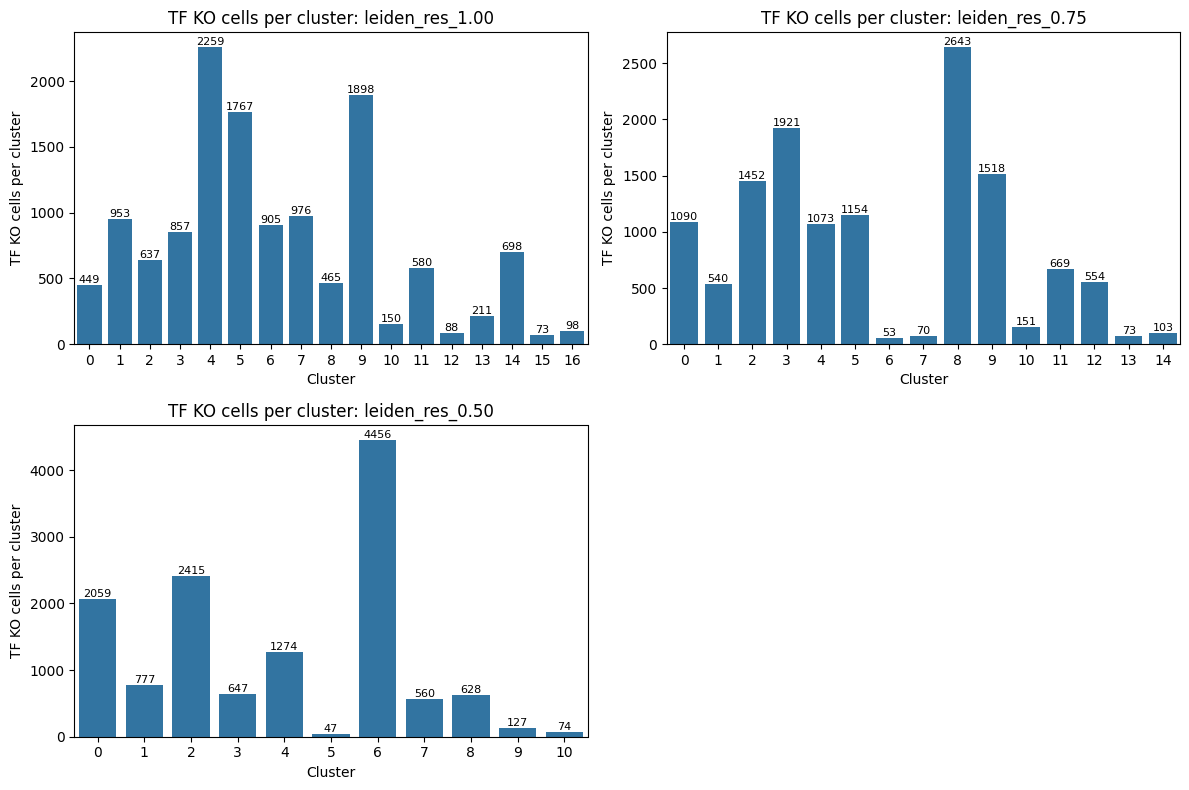

In [ ]:
p = plot_tf_ko_cells_per_cluster3(tf_ko_cells_per_cluster_1, tf_ko_cells_per_cluster_075, tf_ko_cells_per_cluster_05, "leiden_res_1.00", "leiden_res_0.75", "leiden_res_0.50")

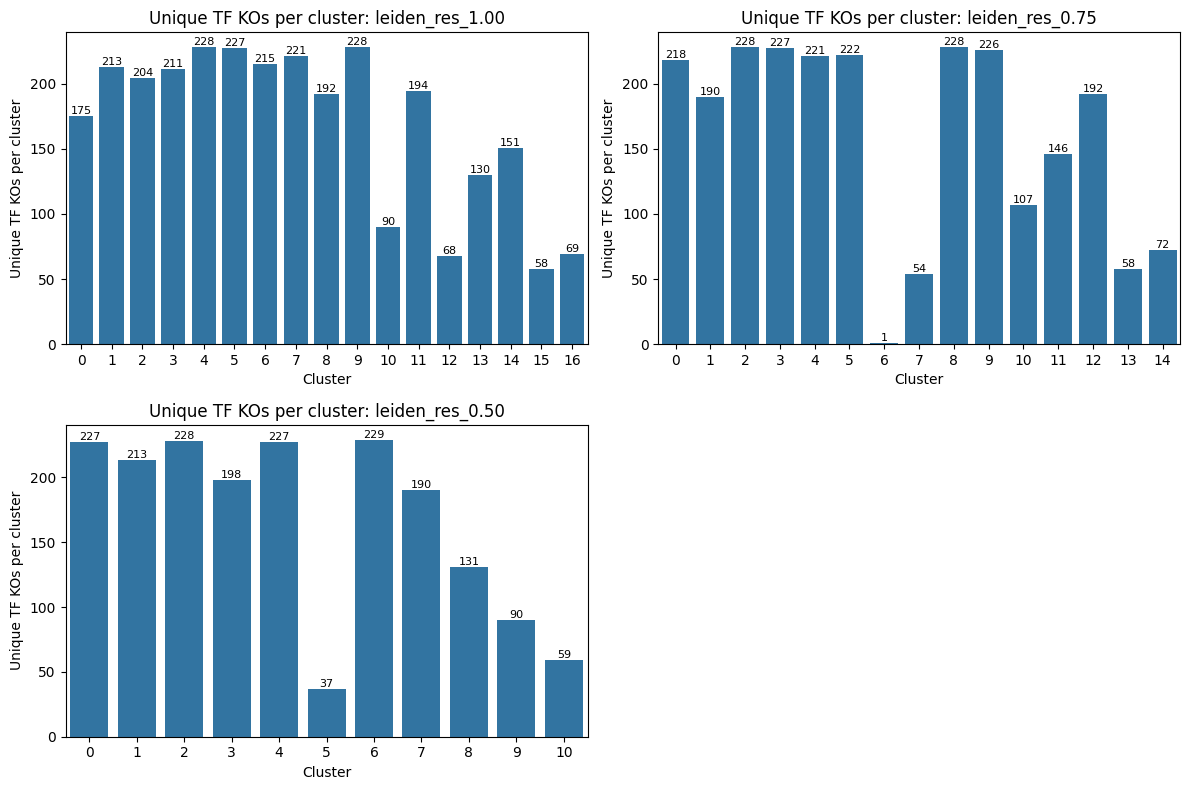

In [ ]:
p = plot_unique_tf_kos_per_cluster3(unique_tf_kos_per_cluster_1, unique_tf_kos_per_cluster_075, unique_tf_kos_per_cluster_05, "leiden_res_1.00", "leiden_res_0.75", "leiden_res_0.50")

In [ ]:
def tf_ko_cluster_df(cluster_summary, n_tf_kos):
    """
    Create DataFrame of TF KOs per cluster and their occurrences.
    """
    n_clusters = cluster_summary.index.nunique()
    cluster_tf_ko_dict = dict()
    for i in range(0, n_clusters*2, 2):
        idx = int(i/2)
        freq_tf_kos = cluster_summary.iloc[idx].nlargest(n_tf_kos).index.tolist()
        tf_ko_counts = cluster_summary.iloc[idx].nlargest(n_tf_kos).tolist()
        # If there are fewer than n_tf_kos TF KOs in cluster
        nonzeros = sum(1 for x in tf_ko_counts if x != 0)
        if nonzeros != n_clusters:
            blanks = ["" for _ in range(n_tf_kos - nonzeros)]
            freq_tf_kos = freq_tf_kos[:nonzeros] + blanks
            tf_ko_counts = tf_ko_counts[:nonzeros] + blanks
        cluster_tf_ko_dict[i] = freq_tf_kos
        cluster_tf_ko_dict[i+1] = tf_ko_counts
    cluster_tf_kos = pd.DataFrame.from_dict(cluster_tf_ko_dict)
    # Add header rows
    header1 = [f"cluster {int(i/2)}" if i % 2 == 0 else "" for i in range(n_clusters*2)]
    header2 = ["TF KO", "count"]*n_clusters
    cluster_tf_kos.columns = pd.MultiIndex.from_tuples(list(zip(header1, header2)))
    return cluster_tf_kos

def tf_ko_cluster_df_from_adata(adata, leiden_res: str, n_tf_kos):
    """
    Given an AnnData object, a Leiden clustering resolution, and a number of TF KOs to display per cluster,
    create a DataFrame of TF KOs per cluster and their occurrences.
    """
    return tf_ko_cluster_df(cluster_summary_tf_ko_df(cluster_summary_df(adata, leiden_res)), n_tf_kos)

def tf_ko_only_cluster_df(cluster_tf_ko_df):
    """
    Filter DataFrame of TF KOs per cluster and their occurrences to show only TF KOs per cluster without counts.
    """
    cluster_tf_kos = cluster_tf_ko_df.copy()
    new_header = cluster_tf_kos.columns.values.tolist()
    new_header = [new_header[i][0] for i in range(len(new_header))]
    cluster_tf_kos = cluster_tf_kos.set_axis(new_header, axis=1)
    cluster_tf_kos = cluster_tf_kos.loc[:, cluster_tf_kos.columns != ""].copy()
    return cluster_tf_kos

We will choose the Leiden clustering resolution of 1.00

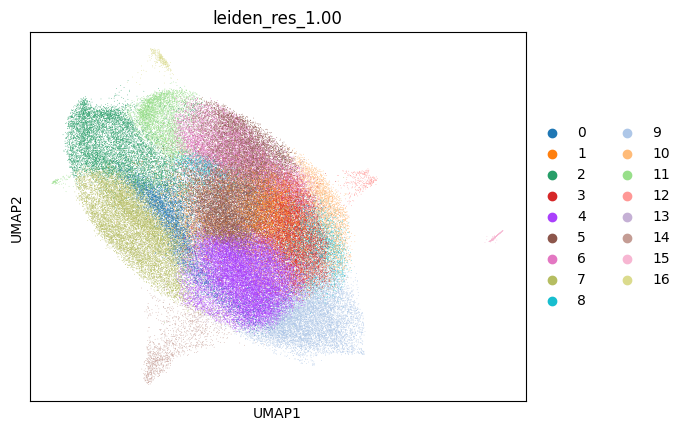

In [ ]:
sc.pl.umap(adata_filt, color="leiden_res_1.00")

In [ ]:
pd.set_option('display.max_columns', None)
cluster_tf_kos_1 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_1.00"))
cluster_1_tf_kos_counts_df = tf_ko_cluster_df(cluster_tf_kos_1, 20)
cluster_1_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      DNMT1    67     ZFP41    19  ARHGAP35    11     ZFP41    16     ZFP41   
1     CHAMP1     9    SETDB1    15    ZFP69B    11     FOXH1    12  ARHGAP35   
2      SALL4     8      ETS1    13   ZNF354A    11     NFIL3    12    CHAMP1   
3      SMAD4     6     FOXH1    13    MTERF4    10      SOX4    12    ZNF219   
4      ZFP41     6   ZNF354A    13    CHAMP1     9     TBX20    12    ZBTB22   
5     ZNF383     6      SOX4    12     SHOX2     9  ARHGAP35    11   ZNF354A   
6     ZNF394     6     DNMT1    11     ZFP41     9     SHOX2    11    ZNF462   
7      ATOH1     5    ZNF75D    11     DOT1L     8    SNAPC5    11      E2F4   
8      BARX1     5  ARHGAP35    10      MAFG     7   ZNF354A    11      SOX4   
9       PHF1     5    CHAMP1    10   MSANTD4     7     GATA5    10     FOXH1   
10   ZNF354A     5     FOXS1    10    ZNF219     7    ZNF844    10      HES6   
11    ZNF462     5   NEUROD4    10     DNMT1     6      ETS1     9     SMAD4   
12    ZNF701     5    ZFP69B    10      ESR2     6   GATAD2A     9    ZBTB33   
13     DMRT2     4     DOT1L     9     HNF1B     6       HDX     9      ETS1   
14      E2F4     4      HES7     9     NANOG     6     HNF1B     9      SHOX   
15      EBF2     4      MTF2     9     NFIL3     6    ZFP69B     9    ZNF383   
16      ETS1     4     THAP6     9     PPARD     6     ESRRA     8    ZNF418   
17     FOXJ2     4    ZBTB22     9    SETDB2     6      ETV1     8    ZNF510   
18      IRX5     4    ZNF205     9    SNAPC5     6    MTERF4     8    ZNF701   
19   MSANTD4     4    ANKZF1     8    ZNF75D     6      MTF2     8    BHLHA9   

         cluster 5       cluster 6       cluster 7       cluster 8        \
   count     TF KO count     TF KO count     TF KO count     TF KO count   
0     39  ARHGAP35    35      SHOX    13     ZFP41    25   ZNF354A    11   
1     31     ZFP41    26  ARHGAP35    12     DNMT1    18     SMAD4     8   
2     25     FOXS1    22      ETS1    11    CHAMP1    17    ZNF383     8   
3     23     PCGF6    22    ZNF219    11  ARHGAP35    14    ZBTB22     7   
4     22     DOT1L    20    BHLHA9    10    SETDB1    14    ZNF844     7   
5     22   NEUROD4    20    CHAMP1    10    THAP12    14    MTERF4     6   
6     22    ZNF383    19    CREBL2    10    ZBTB22    13     THAP6     6   
7     19     FOXH1    18     DOT1L    10     FOXH1    12     ZFP41     6   
8     19    ZNF75D    18      E2F4    10   ZNF354A    11    ZNF75D     6   
9     18     DNMT1    17     FOXK2    10     TBX20    10    ZNF708     6   
10    18    ZBTB22    17     ZFP41    10      ZFP1    10      ETV1     5   
11    18    THAP12    16   ZNF354A    10    ZNF205    10     FOXH1     5   
12    18     TIGD2    16     PITX3     9    ZNF418    10       HLF     5   
13    17      JRKL    15      ZFP1     9      RBPJ     9   MSANTD4     5   
14    17     TBX20    15     ATOH1     8     ATOH1     8     SHOX2     5   
15    17      ZFP1    15   FOXD4L5     8     BARX1     8    ZNF205     5   
16    17      CBX2    14     FOXS1     8     FOXJ2     8    ZNF514     5   
17    17     FOXJ2    14     PCGF6     8   NEUROD4     8    ZNF552     5   
18    17   ZNF354A    14     SHOX2     8    PRDM12     8     ASCL5     4   
19    16    ZNF844    14     TBX20     8    SETDB2     8    CHAMP1     4   

   cluster 9       cluster 10       cluster 11       cluster 12        \
       TF KO count      TF KO count      TF KO count      TF KO count   
0      ZFP41    28    MSANTD4     7   ARHGAP35    15      ZFP41     4   
1   ARHGAP35    26     MTERF4     6      ZFP41    11     AKAP8L     2   
2     CHAMP1    21     AKAP8L     4       ETS1     9     BARHL1     2   
3      SHOX2    21       HES6     4       ETV1     9       ESR2     2   
4     ZNF462    19      ZFP41     4     SETDB1     9      FOXK2     2   
5     NKX2-4    18     CHAMP1     3      PCGF6     8      

In [ ]:
cluster_tf_kos_1

gene_target      AKAP8L  ANKZF1  ARHGAP35  ASCL5  ASH1L  ATMIN  ATOH1  BARHL1  \
leiden_res_1.00                                                                 
0                     0       2         3      2      1      1      5       2   
1                     1       8        10      4      4      2      8       1   
2                     3       0        11      2      4      1      2       5   
3                     5       1        11      3      1      3      3       3   
4                     6       9        31      8      8      4     12       8   
5                     9       4        35      5      8      8     12       7   
6                     3       2        12      3      4      4      8       4   
7                     4       3        14      3      2      1      8       6   
8                     2       2         2      4      1      0      1       2   
9                     4       7        26      8      9      4      9       9   
10                    4       1         2      0      0      0      0       0   
11                    0       0        15      5      4      1      0       2   
12                    2       0         0      0      0      0      0       2   
13                    1       0         5      1      0      2      1       1   
14                    1       1         4      0      0      0      3       1   
15                    0       0         1      0      1      0      3       0   
16                    0       0         4      0      0      0      0       2   

gene_target      BARX1  BHLHA9  BSX  CBX2  CDX1  CENPB  CHAMP1  CREB3L4  \
leiden_res_1.00                                                           
0                    5       2    1     1     1      1       9        1   
1                    8       8    2     2     0      4      10        1   
2                    5       4    3     4     1      1       9        1   
3                    4       3    6     3     1      4       5        7   
4                   11      16   12    10     9      5      25       10   
5                   13      10   10    14     5      1       8        5   
6                    5      10    2     7     1      3      10        3   
7                    8       5    6     3     2      2      17        4   
8                    3       2    1     2     0      1       4        3   
9                   13      12    8    10     7      3      21        4   
10                   1       1    2     0     0      0       3        0   
11                   4       3    3     4     0      0       5        1   
12                   1       0    1     0     0      1       0        0   
13                   2       0    1     0     0      0       3        2   
14                   0       2    1     4     1      2       2        0   
15                   1       1    0     2     0      0       0        2   
16                   0       0    0     0     0      0       4        0   

gene_target      CREBL2  CREM  CSRNP2  DLX4  DMRT2  DNMT1  DOT1L  DR1  DRAP1  \
leiden_res_1.00                                                                
0                     2     0       1     0      4     67      2    2      0   
1                     8     5       6     4      1     11      9    3      2   
2                     3     3       2     2      4      6      8    1      4   
3                     2     1       1     6      4      2      3    6      2   
4                     9     5      13    11     12     11     14    3      8   
5                     3     8       8     5     12     17     20    7     12   
6                    10     4       5     3      6      4     10    1      4   
7                     3     2       2     2      6     18      7    2      5   
8                     3     3       2     2      2      1      1    0      1   
9                     7     8      12     5     11      6     10    7      4   
10                    0     0       0     0      1      2      0    0     

In [ ]:
cluster0_tf_indices = np.flatnonzero(cluster_tf_kos_1.iloc[[0]]).tolist()
cluster0_tf_names = [_ for _ in cluster_tf_kos_1.columns[cluster0_tf_indices]]
print(" ".join(cluster0_tf_names))

ANKZF1 ARHGAP35 ASCL5 ASH1L ATMIN ATOH1 BARHL1 BARX1 BHLHA9 BSX CBX2 CDX1 CENPB CHAMP1 CREB3L4 CREBL2 CSRNP2 DMRT2 DNMT1 DOT1L DR1 DUXA E2F4 EBF2 ELK1 ESR1 ESR2 ESRRA ESRRB ETS1 ETS2 ETV1 FOSB FOXA1 FOXD4L5 FOXE3 FOXH1 FOXJ2 FOXK1 FOXS1 GATA5 GATAD2A GRHL2 GTF2I GTF2IRD1 HDX HES6 HHEX HLF HNF1B HOXD13 IRX5 ISL1 JRKL JUNB KCNIP3 LIN28B MAFG MEOX2 MITF MSANTD4 MTERF3 MTERF4 MTF2 MXD1 NANOG NANOGNB NANOGP8 NEUROD4 NFIL3 NFKB2 NFXL1 NKX2-4 NME2 NOTO NR0B1 NR1I3 ONECUT2 OSR2 PATZ1 PCGF6 PHF1 PITX3 PLSCR1 POU2F1 POU3F2 POU3F3 POU4F3 POU5F1B PPARD PRDM12 PRDM14 PROX2 PURG RBPJ SALL4 SCX SETDB1 SETDB2 SHOX SHOX2 SMAD4 SNAI1 SNAPC5 SOX4 SRY TBPL1 TBX18 TBX20 TCF3 TCF7L1 TCF7L2 TCF12 THAP5 THAP6 THAP12 THRA THRB TIGD6 TSC22D1 USF2 ZBTB22 ZBTB39 ZBTB41 ZFP1 ZFP30 ZFP41 ZFP69B ZNF16 ZNF32 ZNF44 ZNF200 ZNF205 ZNF219 ZNF222 ZNF253 ZNF256 ZNF267 ZNF268 ZNF280C ZNF326 ZNF354A ZNF383 ZNF394 ZNF395 ZNF396 ZNF408 ZNF418 ZNF420 ZNF423 ZNF461 ZNF462 ZNF490 ZNF510 ZNF514 ZNF521 ZNF549 ZNF551 ZNF563 ZNF572 Z

In [ ]:
pd.set_option('display.max_columns', None)
cluster_tf_kos_05 = cluster_summary_tf_ko_df(cluster_summary_df(adata_filt, "leiden_res_0.50"))
cluster_05_tf_kos_counts_df = tf_ko_cluster_df(cluster_tf_kos_05, 20)
cluster_05_tf_kos_counts_df

cluster 0       cluster 1       cluster 2       cluster 3       cluster 4  \
       TF KO count     TF KO count     TF KO count     TF KO count     TF KO   
0      ZFP41    34     ZFP41    17  ARHGAP35    45  ARHGAP35    13     ZFP41   
1    ZNF354A    31   ZNF354A    13     ZFP41    34    CHAMP1    11    CHAMP1   
2       ETS1    23     FOXH1    11     PCGF6    29     ZFP41    11     DNMT1   
3   ARHGAP35    21      SOX4    11     FOXS1    28    MTERF4    10  ARHGAP35   
4       SHOX    21   NEUROD4    10     FOXH1    27    ZFP69B    10    SETDB1   
5     CHAMP1    20  ARHGAP35     9     DOT1L    25     DOT1L     9    ZBTB22   
6     ZBTB22    20    THAP12     9   ZNF354A    25   ZNF354A     9     FOXH1   
7     ZNF75D    20   CREB3L4     8    ZNF383    25     NFIL3     8     ATOH1   
8       ETV1    19   MSANTD4     8    ZBTB22    24     SHOX2     8    THAP12   
9     ZNF205    19     NFIL3     8   NEUROD4    22    ZNF75D     8   ZNF354A   
10    BHLHA9    18     SHOX2     8      SOX4    22    ZNF383     8    ZNF383   
11    CREBL2    18     TBX20     8     BARX1    21    BARHL1     7     FOXS1   
12     DOT1L    18     THAP6     8     DNMT1    21     DMRT2     7      RBPJ   
13     FOXS1    18    ZNF844     8    THAP12    21   MSANTD4     7      ZFP1   
14     PITX3    18    CHAMP1     7    ZNF844    20    SETDB2     7    ZNF205   
15     SHOX2    18      ESR2     7    SETDB1    19    ZNF394     7     SALL4   
16    ZNF219    18      ETV1     7     TBX20    19    ZNF573     7     SHOX2   
17    ZNF383    18     GATA5     7     TIGD2    19      E2F4     6     TBX20   
18     DNMT1    17     HNF1B     7    ZNF75D    19      ESR1     6    ZNF219   
19     FOXH1    17    MTERF4     7     SHOX2    18      ESR2     6    ZNF418   

         cluster 5       cluster 6       cluster 7       cluster 8        \
   count     TF KO count     TF KO count     TF KO count     TF KO count   
0     25     ZFP41     4     DNMT1    79  ARHGAP35    15    POU5F1    92   
1     24      MTF2     2     ZFP41    71     ZFP41    11    ZNF521    57   
2     24      NME2     2  ARHGAP35    56    SETDB1    10     PHF20    45   
3     19     TIGD6     2    CHAMP1    49      ETS1     9    POU3F2    44   
4     19    ZFP69B     2    ZNF462    41      ETV1     8   POU5F1B    43   
5     17    ZNF222     2     SHOX2    39     PCGF6     8    ZNF396    37   
6     16   ZNF354A     2    ZNF219    39     SMAD4     8    HOXD13    35   
7     15    ZNF614     2      ZFP1    38   ZNF354A     8     NANOG    32   
8     15     BARX1     1      HES6    37     TCF12     7      PURG    19   
9     15       BSX     1    ZNF418    37    ZNF462     7    PRDM14    18   
10    14     CENPB     1     ESRRA    36    CHAMP1     6   NANOGP8     8   
11    13    CREBL2     1      SHOX    36      E2F4     6      RBPJ     6   
12    12      ESR1     1    ZBTB22    36      MAFG     6     FOXS1     4   
13    12     ESRRA     1    ZNF75D    36     SHOX2     6     IKZF5     4   
14    12     ESRRB     1     TIGD2    35    ZBTB42     6   NEUROD4     4   
15    11      ETS2     1   ZNF354A    35    ZFP69B     6    SETDB2     4   
16    11     FOXK1     1    ZNF394    35      ZHX1     6     SMAD4     4   
17    11     GATA5     1      ETS1    34     ESRRA     5      ZHX1     4   
18    11      HES6     1     FOXH1    33      FOSB     5  ARHGAP35     3   
19    11    MTERF3     1     FOXJ2    33   L3MBTL4     5     ATOH1     3   

   cluster 9       cluster 10        
       TF KO count      TF KO count  
0       ETV1     5      ATOH1     3  
1   ARHGAP35     4       E2F4     3  
2       SOX4     4      FOXH1     3  
3     CHAMP1     3      ZNF32     3  
4       JRKL     3       CBX2     2  
5      PATZ1     3    CREB3L4     2  
6      ATMIN     2       MXD1     2  
7      BARX1     2    NEUROD4     2  
8    CREB3L4     2     SETDB2     2  
9       CREM     2        SRF     2  
10     DOT1L     2       ZHX1     2  
11     ESRRA     2   ARHGAP35     1  
12     FOXE3     2      ASH1L     1  

In [ ]:
tf_ko_only_1 = tf_ko_only_cluster_df(cluster_1_tf_kos_counts_df)
tf_ko_only_1

cluster 0 cluster 1 cluster 2 cluster 3 cluster 4 cluster 5 cluster 6  \
0      DNMT1     ZFP41  ARHGAP35     ZFP41     ZFP41  ARHGAP35      SHOX   
1     CHAMP1    SETDB1    ZFP69B     FOXH1  ARHGAP35     ZFP41  ARHGAP35   
2      SALL4      ETS1   ZNF354A     NFIL3    CHAMP1     FOXS1      ETS1   
3      SMAD4     FOXH1    MTERF4      SOX4    ZNF219     PCGF6    ZNF219   
4      ZFP41   ZNF354A    CHAMP1     TBX20    ZBTB22     DOT1L    BHLHA9   
5     ZNF383      SOX4     SHOX2  ARHGAP35   ZNF354A   NEUROD4    CHAMP1   
6     ZNF394     DNMT1     ZFP41     SHOX2    ZNF462    ZNF383    CREBL2   
7      ATOH1    ZNF75D     DOT1L    SNAPC5      E2F4     FOXH1     DOT1L   
8      BARX1  ARHGAP35      MAFG   ZNF354A      SOX4    ZNF75D      E2F4   
9       PHF1    CHAMP1   MSANTD4     GATA5     FOXH1     DNMT1     FOXK2   
10   ZNF354A     FOXS1    ZNF219    ZNF844      HES6    ZBTB22     ZFP41   
11    ZNF462   NEUROD4     DNMT1      ETS1     SMAD4    THAP12   ZNF354A   
12    ZNF701    ZFP69B      ESR2   GATAD2A    ZBTB33     TIGD2     PITX3   
13     DMRT2     DOT1L     HNF1B       HDX      ETS1      JRKL      ZFP1   
14      E2F4      HES7     NANOG     HNF1B      SHOX     TBX20     ATOH1   
15      EBF2      MTF2     NFIL3    ZFP69B    ZNF383      ZFP1   FOXD4L5   
16      ETS1     THAP6     PPARD     ESRRA    ZNF418      CBX2     FOXS1   
17     FOXJ2    ZBTB22    SETDB2      ETV1    ZNF510     FOXJ2     PCGF6   
18      IRX5    ZNF205    SNAPC5    MTERF4    ZNF701   ZNF354A     SHOX2   
19   MSANTD4    ANKZF1    ZNF75D      MTF2    BHLHA9    ZNF844     TBX20   

   cluster 7 cluster 8 cluster 9 cluster 10 cluster 11 cluster 12 cluster 13  \
0      ZFP41   ZNF354A     ZFP41    MSANTD4   ARHGAP35      ZFP41       ETV1   
1      DNMT1     SMAD4  ARHGAP35     MTERF4      ZFP41     AKAP8L       SOX4   
2     CHAMP1    ZNF383    CHAMP1     AKAP8L       ETS1     BARHL1   ARHGAP35   
3   ARHGAP35    ZBTB22     SHOX2       HES6       ETV1       ESR2      DOT1L   
4     SETDB1    ZNF844    ZNF462      ZFP41     SETDB1      FOXK2       JRKL   
5     THAP12    MTERF4    NKX2-4     CHAMP1      PCGF6      GATA5      PATZ1   
6     ZBTB22     THAP6    ZNF75D      FOXS1      SMAD4   GTF2IRD1     ZNF383   
7      FOXH1     ZFP41    ZNF844       SHOX    ZNF354A       HES6     ZNF462   
8    ZNF354A    ZNF75D     ESRRA       TCF3      TCF12       MTF2     CHAMP1   
9      TBX20    ZNF708    ZBTB34       ZFP1     ZNF462      NFXL1       CREM   
10      ZFP1      ETV1      ZFP1     ZFP69B       E2F4       NME2      FOXK2   
11    ZNF205     FOXH1    ZNF394   ARHGAP35       PHF1     THAP12       ISL1   
12    ZNF418       HLF     FOXS1        BSX      SHOX2      TIGD6      NFIL3   
13      RBPJ   MSANTD4   NEUROD4      DNMT1     THAP12     ZFP69B      PCGF6   
14     ATOH1     SHOX2     PCGF6       DUXA     ZBTB42     ZNF222      PRDM8   
15     BARX1    ZNF205    ZFP69B       EBF2     ZFP69B    ZNF354A     THAP12   
16     FOXJ2    ZNF514   FOXD4L5       ESR1       ZHX1     ZNF614     ZNF268   
17   NEUROD4    ZNF552      HES6       ESR2     ZNF267     ZNF692    ZNF354A   
18    PRDM12     ASCL5      SHOX       ETV1      ASCL5      BARX1      ATMIN   
19    SETDB2    CHAMP1    ZBTB22      FOXJ2     CHAMP1        BSX      BARX1   

   cluster 14 cluster 15 cluster 16  
0      POU5F1      ATOH1   ARHGAP35  
1      ZNF521       E2F4     CHAMP1  
2       PHF20      FOXH1      NFIL3  
3      POU3F2      ZNF32     ZNF383  
4     POU5F1B       CBX2     BARHL1  
5       NANOG    CREB3L4      DMRT2  
6      ZNF396       MXD1       EBF2  
7      HOXD13    NEUROD4       ESR1  
8      PRDM14     SETDB2    FOXD4L5  
9        PURG        SRF      FOXE3  
10    NANOGP8       ZHX1      FOXK1  
11       RBPJ   ARHGAP35      FOXS1  
12      PITX3      ASH1L       HES6  
13      TIGD2      BARX1     PRDM12  
14   ARHGAP35     BHLHA9      TCF12  
15       CBX2       EBF2      TIGD6  
16      ESRRA       ELK1     ZBTB22  
17      FOXS1       ESR1      ZFP30  
18 

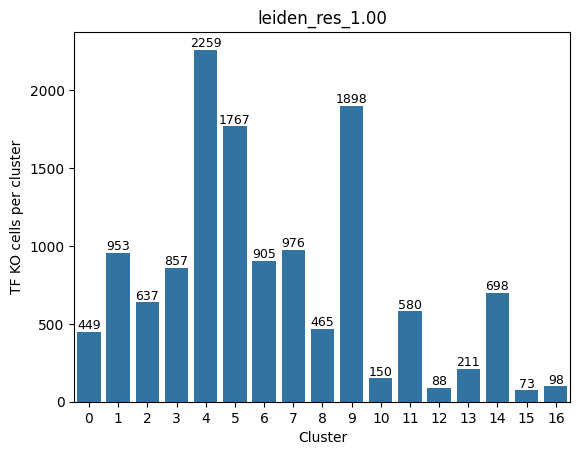

In [ ]:
p = plot_tf_ko_cells_per_cluster(tf_ko_cells_per_cluster_1, "leiden_res_1.00")

***
# More analysis on strong perturbation dataset (not UMAP)

## Downstream Analysis - data after filtering strong perturbations

Read in pipeline output dataset

In [ ]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Strong_Perturbations_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 111902 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Read in list of TFs

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Number of unique KOs

In [ ]:
no_ntc = adata[adata.obs["gene_target"] != "NTC", :]
unique_kos = no_ntc.obs["gene_target"].unique().tolist()
print(len(unique_kos))

1353


Number of cells per KO

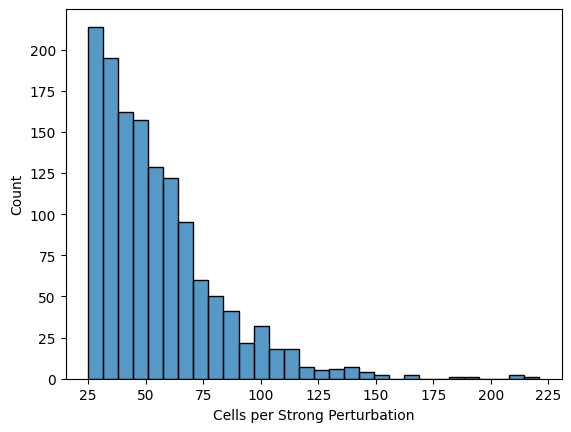

In [ ]:
cells_per_ko = no_ntc.obs['gene_target'].value_counts()
ax = sns.histplot(cells_per_ko.values, bins=30)
p = plt.xlabel("Cells per Strong Perturbation")

Number of unique TF KOs that are strong perturbations

In [ ]:
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

229


Number of cells per strong perturbation TF KO

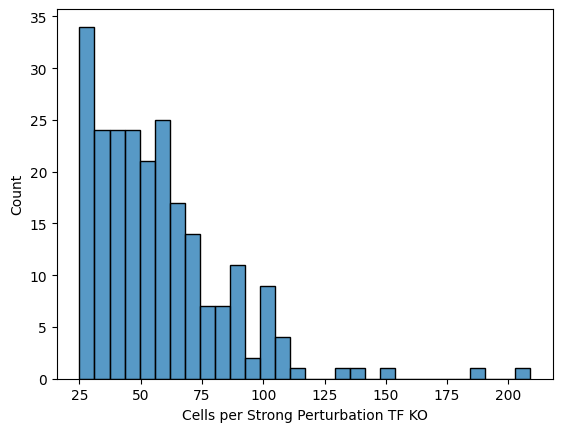

In [ ]:
cells_per_strong_tf_ko = adata_tfs.obs['gene_target'].value_counts()
ax = sns.histplot(cells_per_strong_tf_ko.values, bins=30)
p = plt.xlabel("Cells per Strong Perturbation TF KO")

### Filter DEGs with |LFC| > 0.25 for any perturbation

Read in data

Write function to get the set of DEGs with a |LFC| > a given threshold

In [ ]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25):
    # Get list of strong perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for pert in perts:
        deg_col = f"{pert}_DEGs"
        l2fc_col = f"{pert}_L2FC"
        if deg_col in deg_df.columns and l2fc_col in deg_df.columns:
            lfc_degs.update(deg_df.loc[deg_df[l2fc_col].abs() > lfc_threshold, deg_col])
    return lfc_degs

Get list of DEGs with |LFC| > 0.25

In [ ]:
degs_filt = filter_degs_lfc(deg_df)
# Print results
degs_filt_list = list(degs_filt)
print(degs_filt_list[:10])
print(len(degs_filt))

['TMED3', 'HEG1', 'MACROH2A2', 'MAP7', 'RPA3', 'SMURF2', 'ENSG00000251598', 'KAT7', 'FAM171A1', 'RC3H1']
5800


Filter dataset to only include these DEGs

In [ ]:
print(f"number of genes before filtering: {len(adata.var)}")
adata_filt = adata[:, adata.var_names.isin(degs_filt)].copy()
print(f"number of genes after filtering: {len(adata_filt.var)}")
adata_filt

number of genes before filtering: 37567


number of genes after filtering: 5800


AnnData object with n_obs × n_vars = 111902 × 5800
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

# Downstream Analysis (full dataset before filtering TF KOs or strong perturbations)

Read in list of TFs

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in processed list of DEGs (study output, with duplicates removed by me)

In [ ]:
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/Aggregate_DEGs_final.xlsx", index_col=0)

## Preprocessing and batch correction

Read in output from step F (filtering only perturbed cells and core NTC cells, but before filtering strong perturbations)

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

Look at cells per batch

In [ ]:
for run_adata, run_name in (adata_alpha, "ALPHA"), (adata_beta, "BETA"), (adata_gamma, "GAMMA"):
    print(f"Run {run_name} has {run_adata[run_adata.obs['gene_target'] == 'NTC'].shape[0]} NTC cells, "
          f"{run_adata[run_adata.obs['gene_target'].isin(tfs)].shape[0]} TF cells, "
          f"and {len(run_adata[run_adata.obs['gene_target'].isin(tfs)].obs['gene_target'].unique().tolist())} unique TF(s)")

Run ALPHA has 14108 NTC cells, 31321 TF cells, and 643 unique TF(s)
Run BETA has 13537 NTC cells, 422 TF cells, and 8 unique TF(s)
Run GAMMA has 9788 NTC cells, 65 TF cells, and 1 unique TF(s)


Concatenate 3 batches

In [ ]:
adata_combined = ad.concat([adata_alpha,adata_beta,adata_gamma])
adata_combined.X = adata_combined.layers["counts"].copy()

In [ ]:
adata_combined

AnnData object with n_obs × n_vars = 232504 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

Preprocessing

In [ ]:
median_NTC_UMIs = np.median(qc2._get_ntc_view(adata_combined).obs.n_UMI_counts)
sc.pp.normalize_total(adata_combined, target_sum=median_NTC_UMIs)
sc.pp.log1p(adata_combined)

normalizing counts per cell
    finished (0:00:01)


Batch correction

In [ ]:
a = adata_combined[adata_combined.obs.run == 'ALPHA'].copy()
b = adata_combined[adata_combined.obs.run == 'BETA'].copy()
c = adata_combined[adata_combined.obs.run == 'GAMMA'].copy()

In [ ]:
qc2.relative_z_normalization(a)
qc2.relative_z_normalization(b)
qc2.relative_z_normalization(c)
normalized_adata = ad.concat([a,b,c])

In [ ]:
normalized_adata.write("/home/ranwyl/data_tf_project/Aggregate_Core_Cells_Batch_Normalized.h5ad")

## Filter TF KOs

Read in batch corrected core cell dataset

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Core_Cells_Batch_Normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 232504 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
for run in "ALPHA", "BETA", "GAMMA":
    print(f"In full dataset, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

In full dataset, run ALPHA has 84485 cells
In full dataset, run BETA has 95535 cells
In full dataset, run GAMMA has 52484 cells


Filter TF KOs

In [ ]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
print(f"number of cells after filtering: {adata_tfs.obs.shape[0]}")

number of cells before filtering: 232504
number of cells after filtering: 31808


In [ ]:
for run in "ALPHA", "BETA", "GAMMA":
    print(f"In TF KO dataset, run {run} has {adata_tfs[adata_tfs.obs['run'] == run].shape[0]} cells")

In TF KO dataset, run ALPHA has 31321 cells
In TF KO dataset, run BETA has 422 cells
In TF KO dataset, run GAMMA has 65 cells


### Display TF KO info and plot histogram

Number of unique KOs

In [ ]:
unique_kos = adata.obs["gene_target"].unique().tolist()
print(len(unique_kos))

4228


Number of unique TF KOs

In [ ]:
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

652


Number of cells per TF KO

In [ ]:
cells_per_tf_ko = adata_tfs.obs['gene_target'].value_counts()

In [ ]:
print(cells_per_tf_ko[:5])

gene_target
ZFP41       209
ARHGAP35    186
DNMT1       150
ZNF354A     139
BHLHE40     139
Name: count, dtype: int64


In [1]:
# ax = sns.histplot(cells_per_tf_ko.values, bins=30)
# p = plt.xlabel("Cells per TF KO")

## Filter genes

### Get set of DEGs that pass LFC threshold in any TF KO

Write function to get set of DEGs that pass LFC threshold based on differential gene expression data

In [ ]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for pert in perts:
        deg_col = f"{pert}_DEGs"
        l2fc_col = f"{pert}_L2FC"
        if deg_col in deg_df.columns and l2fc_col in deg_df.columns:
            lfc_degs.update(deg_df.loc[deg_df[l2fc_col].abs() > lfc_threshold, deg_col])
    return lfc_degs

Generate set of DEGs

In [ ]:
degs_filt = filter_degs_lfc(deg_df)
# Print results
degs_filt_list = list(degs_filt)
print(degs_filt_list[:10])
print(len(degs_filt))

['SRSF10', 'RBM19', 'EIF3A', 'SRSF4', 'ADARB2', 'SYNE2', 'KLKB1', 'ENSG00000229618', 'MYH9', 'ZNF670']
5800


Filter out genes that are present in fewer than 25 cells, based on study pipeline

In [ ]:
sc.pp.filter_genes(adata_tfs, min_cells=25) # Filter for genes that are present in at least 25 cells
adata_tfs

filtered out 13046 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 31808 × 24521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Test different gene filtering approaches

Generate set of 2000 HVGs

In [ ]:
adata_tfs_2000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000_hvg, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_2000 = set(adata_tfs_2000_hvg[:, adata_tfs_2000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 3000 HVGs

In [ ]:
adata_tfs_3000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_3000_hvg, n_top_genes=3000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_3000 = set(adata_tfs_3000_hvg[:, adata_tfs_3000_hvg.var['highly_variable']].var.index)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 4000 HVGs

In [ ]:
adata_tfs_4000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_4000_hvg, n_top_genes=4000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_4000 = set(adata_tfs_4000_hvg[:, adata_tfs_4000_hvg.var['highly_variable']].var.index)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 5000 HVGs

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Take union of set of DEGs that pass LFC threshold and set of HVGs

In [ ]:
genes_union_2000 = list(degs_filt.union(unique_hvg_2000))
print(f"Number of genes in union of 5800 DEGs and 2000 HVGs: {len(genes_union_2000)}")
genes_union_3000 = list(degs_filt.union(unique_hvg_3000))
print(f"Number of genes in union of 5800 DEGs and 3000 HVGs: {len(genes_union_3000)}")
genes_union_4000 = list(degs_filt.union(unique_hvg_4000))
print(f"Number of genes in union of 5800 DEGs and 4000 HVGs: {len(genes_union_4000)}")
genes_union_5000 = list(degs_filt.union(unique_hvg_5000))
print(f"Number of genes in union of 5800 DEGs and 5000 HVGs: {len(genes_union_5000)}")

Number of genes in union of 5800 DEGs and 2000 HVGs: 7002
Number of genes in union of 5800 DEGs and 3000 HVGs: 7612
Number of genes in union of 5800 DEGs and 4000 HVGs: 8248
Number of genes in union of 5800 DEGs and 5000 HVGs: 8788


Take intersection of set of DEGs that pass LFC threshold and set of HVGs

In [ ]:
genes_intersec_2000 = list(degs_filt.intersection(unique_hvg_2000))
print(f"Number of genes in intersection of 5800 DEGs and 2000 HVGs: {len(genes_intersec_2000)}")
genes_intersec_3000 = list(degs_filt.intersection(unique_hvg_3000))
print(f"Number of genes in intersection of 5800 DEGs and 3000 HVGs: {len(genes_intersec_3000)}")
genes_intersec_4000 = list(degs_filt.intersection(unique_hvg_4000))
print(f"Number of genes in intersection of 5800 DEGs and 4000 HVGs: {len(genes_intersec_4000)}")
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
print(f"Number of genes in intersection of 5800 DEGs and 5000 HVGs: {len(genes_intersec_5000)}")

Number of genes in intersection of 5800 DEGs and 2000 HVGs: 798
Number of genes in intersection of 5800 DEGs and 3000 HVGs: 1188
Number of genes in intersection of 5800 DEGs and 4000 HVGs: 1552
Number of genes in intersection of 5800 DEGs and 5000 HVGs: 2012


Filter genes in TF-KO-by-gene dataset to the union of 5800 DEGs + 2000 HVGs (7002 genes)

In [ ]:
adata_tfs_union = adata_tfs[:, adata_tfs.var.index.isin(genes_union_2000)].copy()
adata_tfs_union

AnnData object with n_obs × n_vars = 31808 × 7000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Filter genes to the 5800 DEGs that pass LFC threshold

Filter genes in TF-KO-by-gene dataset to the 5800 DEGs that pass LFC threshold

In [ ]:
adata_tfs_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_filt)].copy()
adata_tfs_degs

AnnData object with n_obs × n_vars = 31808 × 5798
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs.write("/home/ranwyl/data_tf_project/tf_kos_by_5800_degs.h5ad")

### Filter genes to the intersection of 5800 DEGs that pass LFC threshold and 5000 HVGs (2012 genes total)

Filter genes in TF-KO-by-gene dataset to the intersection of 5800 DEGs + 5000 HVGs (2012 genes)

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
adata_tfs_intersec = adata_tfs[:, adata_tfs.var.index.isin(genes_intersec_5000)].copy()
adata_tfs_intersec

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 31808 × 2012
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_intersec.write("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

### Filter genes to 2000 HVGs

In [ ]:
adata_tfs_2000 = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
adata_tfs_2000

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

## Display cells per batch in a dataset

In [ ]:
def cells_per_batch(adata, dataset_name):
    for run in "ALPHA", "BETA", "GAMMA":
        print(f"In {dataset_name}, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

## Pairwise Pearson correlation matrix of mean profiles

### Modifying and testing code for plotting pairwise Pearson correlation matrix of mean profiles

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5800_degs.h5ad")

Write modified function for computing mean normalized profiles and generating pairwise Pearson correlation matrix that runs on a subset of the data

In [ ]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def test_create_corrmatrix(adata, n_gene_targets, n_jobs):
    # Subset gene targets for testing
    gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
    gene_targets = gene_target_list[:n_gene_targets]
    adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    print(f"Number of gene target groups: {len(gene_target_groups)}")

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    mean_profiles = np.array(mean_profiles)
    corr_matrix = np.corrcoef(mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_df = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_df,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_df, mean_profiles)

Measure RAM usage with different values of `gene_target_groups`

-  20 targets, 20 jobs: before 157Gb, after 163 Gb = 6 Gb used
-  50 targets, 50 jobs: before 163 Gb, after 171 Gb = 8 Gb used
-  100 targets, 25 jobs: before 96Gb, after 90Gb somehow
-  250 targets, 25 jobs: before 90Gb, after 92Gb
-  500 targets, 25 jobs: before 92Gb, after 89Gb
-  Very fast and should be no problem to run on full dataset

In [2]:
# ddf, mp = test_create_corrmatrix(adata, 500, 25)

### Pairwise Pearson correlation matrix of mean profiles - final function

In [ ]:
def create_corrmatrix_parallel(adata, n_jobs):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        adata_mean_profiles = Parallel(n_jobs=n_jobs)(delayed(qc2.compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

### Pairwise Pearson correlation matrix of mean profiles for 5800-gene dataset

In [ ]:
adata_5800 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5800_degs.h5ad")

In [3]:
# distance_df_5800, mean_profiles_5800 = create_corrmatrix_parallel(adata_5800, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2012-gene dataset

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

In [4]:
# distance_df_2012, mean_profiles_2012 = create_corrmatrix_parallel(adata_2012, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2000-gene dataset

In [ ]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [5]:
# distance_df_2000, mean_profiles_2000 = create_corrmatrix_parallel(adata_2000, 25)

## MDE

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points:
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

### Modifying and testing code for mean normalized expression profile pairwise Pearson correlation matrix + MDE

In [ ]:
# def compute_mean_normalized_profile(adata, group_indices):
#     mean_vector = adata[group_indices, :].X.mean(axis=0)
#     normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
#     return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

# def test_tf_compute_MDE(adata, n_gene_targets, n_jobs, leiden_neighbors=5, preserve='neighbors', spectral=False):
#     adata = adata.copy()

#     # Subset gene targets for testing
#     gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
#     gene_targets = gene_target_list[:n_gene_targets]
#     adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
#     gene_target_groups = adata.obs.groupby('gene_target').indices
#     print(f"Number of gene target groups: {len(gene_target_groups)}")

#     # Initialize tqdm progress bar
#     with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
#         # Compute the mean expression profile for each group in parallel
#         mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
#                                                 for indices in gene_target_groups.values())
    
#     # Convert the list of mean profiles to a numpy array
#     mean_profiles_array = np.array(mean_profiles)

#     # Compute MDE
#     mde = None
#     embedding = None
#     if preserve == "neighbors":
#         if spectral:
#             spectral_embedding = SpectralEmbedding(
#                 n_components=30,  # Ensure this matches the pymde embedding dimension
#                 affinity='nearest_neighbors',
#                 n_neighbors=10,
#                 eigen_solver='arpack'
#             )
#             initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
#             mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
#             embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
#         else:
#             mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
#             embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
#     else:
#         mde = pymde.preserve_distances(mean_profiles_array)
#         embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
#     # Run Leiden clustering on the embeddings
#     knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
#     sources, targets = knn_graph.nonzero()
#     g = ig.Graph(directed=False)
#     g.add_vertices(embedding.shape[0])
#     g.add_edges(zip(sources, targets))
#     partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
#     # Get cluster labels and make pairwise correlation plot
#     clusters = np.array(partition.membership)
#     gene_targets = list(gene_target_groups.keys())
#     embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
#     embedding_df['gene_target'] = gene_targets
#     embedding_df['cluster'] = clusters
#     embedding_df['cluster'] = embedding_df['cluster'].astype(str)
#     cluster_groups = embedding_df.groupby('cluster')
#     centroids = cluster_groups[['x', 'y']].mean()
#     pairwise_distances = pd.DataFrame(
#         squareform(pdist(centroids, metric='euclidean')),
#         index=centroids.index,
#         columns=centroids.index
#     )
#     sns.clustermap(pairwise_distances, cmap='PuBuGn')
#     plt.title('Pairwise Distance Matrix of Cluster Centroids')
#     plt.show()


#     # Plot using Plotly with Pastel colormap for discrete clusters
#     fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
#                      hover_data={'x': True, 'y': True, 'gene_target': True},
#                      title='MDE Embedding of Mean Normalized Profiles',
#                      color_discrete_sequence=px.colors.qualitative.Bold)
#     fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
#     fig.update_layout(
#         showlegend=True,
#         xaxis=dict(visible=False),
#         yaxis=dict(visible=False),
#         plot_bgcolor='white',
#         width=1200,  # Increase plot width
#         height=1000,  # Increase plot height
#         legend_title_text='Cluster',
#         coloraxis_showscale=False
#     )
   
#     fig.show()
    
#     return adata, embedding, clusters, mean_profiles_array

Tested different dataset sizes and monitor RAM + time elapsed (results not shown) - it works

Now we want to test why we are getting the error message: 

"/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,"

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def test_tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # # Plot using Plotly with Pastel colormap for discrete clusters
    # fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
    #                  hover_data={'x': True, 'y': True, 'gene_target': True},
    #                  title='MDE Embedding of Mean Normalized Profiles',
    #                  color_discrete_sequence=px.colors.qualitative.Bold)
    # fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    # fig.update_layout(
    #     showlegend=True,
    #     xaxis=dict(visible=False),
    #     yaxis=dict(visible=False),
    #     plot_bgcolor='white',
    #     width=1200,  # Increase plot width
    #     height=1000,  # Increase plot height
    #     legend_title_text='Cluster',
    #     coloraxis_showscale=False
    # )
    # if not label_points:
    #     fig.update_traces(text=None)
   
    # fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

def test_tf_compute_MDE_2(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    return embedding_df
    
    # pairwise_distances = pd.DataFrame(
    #     squareform(pdist(centroids, metric='euclidean')),
    #     index=centroids.index,
    #     columns=centroids.index
    # )
    # sns.clustermap(pairwise_distances, cmap='PuBuGn')
    # plt.title('Pairwise Distance Matrix of Cluster Centroids')
    # plt.show()

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

In [6]:
# test_adata, test_embedding, test_clusters, test_mp = test_tf_compute_MDE(adata_2012, 5, spectral=True, leiden_neighbors=8)

In [ ]:
test_embedding_df = test_tf_compute_MDE_2(adata_2012, 5, spectral=True, leiden_neighbors=8)

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:13:34 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128922 edges.
Apr 17 02:13:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:13:34 PM: iteration 0000 | distortion 0.973552 | residual norm 0.114345 | step length 0.311499 | percent change 0.0986355
Apr 17 02:13:37 PM: iteration 0100 | distortion 0.141704 | residual norm 0.000205405 | step length 1 | percent change 0.499116
Apr 17 02:13:40 PM: iteration 0200 | distortion 0.140230 | residual norm 0.000120667 | step length 0.631188 | percent change 0.733236
Apr 17 02:13:43 PM: iteration 0300 | distortion 0.139719 | residual norm 3.67199e-05 | step length 1 | percent change 0.130888
Apr 17 02:13:45 PM: iteration 0400 | distortion 0.139194 | residual norm 7.99929e-05 | step length 1 | percent change 0.424733
Apr 17 02:13:47 PM: iteration 0500 | distortion 0.138897 | residual norm 1.91764e-05 | step length 1 | percent change 0.044975
Apr 17 02:13:49 PM: iteration 06

In [ ]:
cluster_groups = test_embedding_df.groupby('cluster')
centroids = cluster_groups[['x', 'y']].mean()
centroids

x         y
cluster                    
0       -0.046596 -0.406438
1       -1.316051  1.885311
10       1.190665 -1.900266
11       0.748815  1.298265
12      -1.312611 -5.399751
13      -4.194056  3.612322
14       6.250611 -1.030417
15      -7.694043 -0.612885
16       2.545876  1.978286
17       0.848415  6.816499
18      -3.844777 -4.329384
19       3.129081 -5.663320
2       -2.514124 -2.058999
20      -6.057180 -2.377816
21      -2.126464  6.845334
3        2.906401 -0.673219
4        2.649839  4.063341
5       -4.382234  0.926447
6        3.528181 -3.107324
7        0.676794 -4.347167
8        4.879872  1.103764
9       -1.662272  5.090614

In [ ]:
pdist_mat = pdist(centroids, metric='euclidean')
pdist_mat.shape

(231,)

In [ ]:
pdist_mat

array([ 2.6198535 ,  1.93967396,  1.88114091,  5.15130746,  5.77510693,
        6.3280459 ,  7.65023314,  3.52247346,  7.27817722,  5.46037413,
        6.14163921,  2.96979007,  6.32561903,  7.54414014,  2.96502353,
        5.2201237 ,  4.53589409,  4.48038145,  4.00657474,  5.15274694,
        5.72957208,  4.54028841,  2.14669419,  7.28506336,  3.35640856,
        8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,  6.70946324,
        8.76019619,  4.12225246,  6.37593635,  5.02579284,  4.93712263,
        4.52461074,  3.21261507,  6.95650762,  6.54333446,  6.24502085,
        3.22394729,  3.22890523,  4.30264898,  7.70609141,  5.1341689 ,
        8.97749317,  4.10849859,  8.72348079,  5.59073271,  4.23297008,
        3.70818788,  7.26356072,  9.35354785,  2.10935912,  6.13952743,
        6.24879988,  2.63077424,  2.50027825,  4.7575672 ,  7.55060621,
        7.00805935,  5.45773171,  5.97432161,  8.65646275,  1.92142025,
        5.51913268,  7.2644011 ,  7.35726384,  4.68166575,  7.73

In [ ]:
squareform_mat = squareform(pdist_mat)
squareform_mat.shape

(22, 22)

In [ ]:
squareform_mat

array([[ 0.        ,  2.6198535 ,  1.93967396,  1.88114091,  5.15130746,
         5.77510693,  6.3280459 ,  7.65023314,  3.52247346,  7.27817722,
         5.46037413,  6.14163921,  2.96979007,  6.32561903,  7.54414014,
         2.96502353,  5.2201237 ,  4.53589409,  4.48038145,  4.00657474,
         5.15274694,  5.72957208],
       [ 2.6198535 ,  0.        ,  4.54028841,  2.14669419,  7.28506336,
         3.35640856,  8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,
         6.70946324,  8.76019619,  4.12225246,  6.37593635,  5.02579284,
         4.93712263,  4.52461074,  3.21261507,  6.95650762,  6.54333446,
         6.24502085,  3.22394729],
       [ 1.93967396,  4.54028841,  0.        ,  3.22890523,  4.30264898,
         7.70609141,  5.1341689 ,  8.97749317,  4.10849859,  8.72348079,
         5.59073271,  4.23297008,  3.70818788,  7.26356072,  9.35354785,
         2.10935912,  6.13952743,  6.24879988,  2.63077424,  2.50027825,
         4.7575672 ,  7.55060621],
       [ 1.88114091

### Run pymde functions on test dataset from documentation

In [ ]:
import pymde

In [ ]:
mnist = pymde.datasets.MNIST()

Apr 16 05:10:51 PM: Loading cached dataset.


In [ ]:
mde = pymde.preserve_neighbors(mnist.data, verbose=True)

Apr 16 05:10:53 PM: Computing 15-nearest neighbors, with max_distance=None
Wed Apr 16 17:10:57 2025 Building RP forest with 21 trees
Wed Apr 16 17:11:01 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Apr 16 05:11:12 PM: Computing quadratic initialization.


In [ ]:
embedding = mde.embed(verbose=True)

Apr 16 05:11:34 PM: Fitting a centered embedding into R^2, for a graph with 70000 items and 1552422 edges.
Apr 16 05:11:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Apr 16 05:11:34 PM: iteration 000 | distortion 0.274489 | residual norm 0.00458225 | step length 5.505 | percent change 0.00674175
Apr 16 05:11:50 PM: iteration 030 | distortion 0.133900 | residual norm 0.000269448 | step length 1 | percent change 1.52615
Apr 16 05:12:08 PM: iteration 060 | distortion 0.124270 | residual norm 0.000107924 | step length 1 | percent change 0.683416
Apr 16 05:12:26 PM: iteration 090 | distortion 0.122658 | residual norm 5.89481e-05 | step length 1 | percent change 0.516447
Apr 16 05:12:45 PM: iteration 120 | distortion 0.122062 | residual norm 4.06138e-05 | step length 1 | percent change 0.183785
Apr 16 05:13:03 PM: iteration 150 | distortion 0.121713 | residual norm 3.94129e-05 | step length 1 | percent change 0.169512
Apr 16 05:13:21 PM: iteration 180 | distorti

In [7]:
# pymde.plot(embedding, color_by=mnist.attributes['digits'])

## MDE for 2012-gene dataset

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

In [8]:
# adata_2012_mde, embedding2012, clusters2012, mean_profiles_array2012 = tf_compute_MDE(adata_2012, 5, spectral=True,leiden_neighbors=8)

Plot MDE without labels

In [9]:
# tf_compute_MDE(adata_2012, 5, label_points=False, spectral=True, leiden_neighbors=8)

## MDE for 2000-HVG dataset

In [ ]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [10]:
# adata_2000_mde, embedding2000, clusters2000, mean_profiles_array2000 = tf_compute_MDE(adata_2000, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

## Use full-dataset DE results to determine which TF KOs are strong perturbations (>= 10 DEGs)

Write function to determine which perturbations are TF KOs with >= 10 DEGs

In [ ]:
def determine_strong_perturbation_tf_kos(combined_degs, tf_set, deg_cutoff=10):
    # Identify the _DEGs columns
    deg_columns = [col for col in combined_degs.columns if '_DEGs' in col]

    # Filter perturbations that are TF KOs
    deg_columns = [col for col in deg_columns if col.split("_")[0] in tf_set]
    
    # Count the non-NaN values in each _DEGs column
    non_nan_counts = combined_degs[deg_columns].notna().sum()

    # Filter out column trios with fewer than 10 DEGs
    valid_deg_columns = non_nan_counts[non_nan_counts >= deg_cutoff].index.tolist()

    # Sort the remaining _DEGs columns based on the count
    sorted_deg_columns = non_nan_counts.loc[valid_deg_columns].sort_values(ascending=False).index.tolist()

    # Rearrange the DataFrame keeping the valid three adjacent columns together
    sorted_columns = []
    for deg_col in sorted_deg_columns:
        # Identify the corresponding L2FC and Adj_P columns
        base_name = deg_col.replace('_DEGs', '')
        l2fc_col = f'{base_name}_L2FC'
        adj_p_col = f'{base_name}_Adj_P'
        
        # Add these columns to the sorted list
        sorted_columns.extend([deg_col, l2fc_col, adj_p_col])

    # Rearrange the DataFrame with only the valid columns
    filtered_combined_degs = combined_degs[sorted_columns]
    return filtered_combined_degs

In [ ]:
strong_pert_deg_df = determine_strong_perturbation_tf_kos(deg_df, tfs)
strong_pert_deg_df

POU5F1_DEGs  POU5F1_L2FC  POU5F1_Adj_P PHF20_DEGs  PHF20_L2FC  \
0                DGKB    -6.076206      0.020763   SLC22A23   -4.365596   
1               AP3B2    -5.457997      0.046913     ATG101   -4.360231   
2               TRNP1    -5.160944      0.004823      ORAI1   -4.315618   
3     ENSG00000259048    -5.015852      0.000079     SUCLG1   -3.572351   
4              SYNPO2    -4.207629      0.040667     ZNF581   -3.460301   
...               ...          ...           ...        ...         ...   
1833  ENSG00000254202     8.638068      0.000195        NaN         NaN   
1834             DLX5     8.798191      0.000137        NaN         NaN   
1835            MEIS2     9.215727      0.000053        NaN         NaN   
1836             DLK1     9.618622      0.000020        NaN         NaN   
1837             SIX3     9.650722      0.000019        NaN         NaN   

      PHF20_Adj_P      POU3F2_DEGs  POU3F2_L2FC  POU3F2_Adj_P  \
0        0.002348              MYC    -3.849306      0.004563   
1        0.044251             OCLN    -3.215691      0.026427   
2        0.048677           DBNDD2    -3.139128      0.006128   
3        0.003897  ENSG00000289399    -3.050469      0.002413   
4        0.037650             PEX7    -2.853733      0.021551   
...           ...              ...          ...           ...   
1833          NaN              NaN          NaN           NaN   
1834          NaN              NaN          NaN           NaN   
1835          NaN              NaN          NaN           NaN   
1836          NaN              NaN          NaN           NaN   
1837          NaN              NaN          NaN           NaN   

         POU5F1B_DEGs  ...  VDR_Adj_P       GRHL2_DEGs GRHL2_L2FC  \
0     ENSG00000289399  ...   0.006946  ENSG00000197462  -1.372026   
1              ZNF134  ...   0.006946        LINC02335  -1.320307   
2                STC2  ...   0.006946           MT-CYB  -0.566358   
3               LIN7A  ...   0.046353          MT-ATP6  -0.314984   
4               DISC1  ...   0.039598           MT-CO2  -0.287463   
...               ...  ...        ...              ...        ...   
1833              NaN  ...        NaN              NaN        NaN   
1834              NaN  ...        NaN              NaN        NaN   
1835              NaN  ...        NaN              NaN        NaN   
1836              NaN  ...        NaN              NaN        NaN   
1837              NaN  ...        NaN              NaN        NaN   

      GRHL2_Adj_P  ETS1_DEGs ETS1_L2FC  ETS1_Adj_P  AKAP8L_DEGs AKAP8L_L2FC  \
0        0.026750     TMSB10 -0.455466    0.048759       MT-ND5   -0.744941   
1        0.002374      ROBO2 -0.430676    0.048759       MT-CYB   -0.561085   
2        0.000007      RPS13 -0.315417    0.048759      MT-ATP6   -0.460241   
3        0.002192       PTMA -0.204787    0.048759       MT-ND4   -0.457726   
4        0.004888     LARGE1  0.445472    0.048759       MT-CO2   -0.454638   
...           ...        ...       ...         ...          ...         ...   
1833          NaN        NaN       NaN         NaN          NaN         NaN   
1834          NaN        NaN       NaN         NaN          NaN         NaN   
1835          NaN        NaN       NaN         NaN          NaN         NaN   
1836          NaN        NaN       NaN         NaN          NaN         NaN   
1837          NaN        NaN       NaN         NaN          NaN         NaN   

      AKAP8L_Adj_P  
0         0.046801  
1         0.004071  
2         0.000713  
3         0.005517  
4         0.000122  
...            ...  
1833           NaN  
1834           NaN  
1835           NaN  
1836           NaN  
1837           NaN  

[1838 rows x 687 columns]

In [ ]:
687 // 3

229

Based on DEA results for the TF KO and NTC cell dataset, there are still only 229 TF KOs that are considered strong perturbations.

# Downstream Analysis 4-2025

### Filter genes to the 5760 DEGs with |LFC| > 0.75

In [ ]:
degs_filt_075 = filter_degs_lfc(deg_df, lfc_threshold=0.75)
adata_tfs_degs_075 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_075)].copy()
adata_tfs_degs_075

AnnData object with n_obs × n_vars = 31808 × 5758
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_075.write("/home/ranwyl/data_tf_project/tf_kos_by_5760_degs.h5ad")

### Filter genes to the 5343 DEGs with |LFC| > 1

Filter genes in TF-KO-by-gene dataset to the 5343 DEGs that pass LFC threshold of 1

In [ ]:
degs_filt_1 = filter_degs_lfc(deg_df, lfc_threshold=1)
adata_tfs_degs_1 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_1)].copy()
adata_tfs_degs_1

AnnData object with n_obs × n_vars = 31808 × 5341
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_1.write("/home/ranwyl/data_tf_project/tf_kos_by_5343_degs.h5ad")

### Filter genes to the 2324 DEGs with |LFC| > 2

Filter genes in TF-KO-by-gene dataset to the 2324 DEGs that pass LFC threshold of 2

In [ ]:
degs_filt_2 = filter_degs_lfc(deg_df, lfc_threshold=2)
adata_tfs_degs_2 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_2)].copy()
adata_tfs_degs_2

AnnData object with n_obs × n_vars = 31808 × 2324
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_2.write("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

### Filter genes to the intersection of 5818 DEGs and 5000 HVGs (2017 genes total)

Filter genes in TF-KO-by-gene dataset to the intersection of 5818 DEGs + 5000 HVGs (2017 genes)

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
adata_tfs_intersec = adata_tfs[:, adata_tfs.var.index.isin(genes_intersec_5000)].copy()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_tfs_intersec

AnnData object with n_obs × n_vars = 31808 × 2017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_intersec.write("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

### Pairwise Pearson correlation matrix of mean profiles for 5818-DEG dataset (|LFC| > 0.25)

In [ ]:
adata_5818 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5818_degs.h5ad")

In [2]:
# distance_df_5818, mean_profiles_5818 = tf_create_corrmatrix(adata_5818, v_min=-0.2, v_max=0.2)

### MDE on 5818 DEG dataset

In [ ]:
adata_5818 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5818_degs.h5ad")

With 8 Leiden neighbors

In [3]:
# mde_5818_8 = tf_compute_MDE(adata_5818, label_points=False, spectral=True, leiden_neighbors=8)

In [ ]:
_, _, _, _, embedding_df_5818_8 = mde_5818_8
embedding_df_5818_8.head()

x         y gene_target cluster
0  0.509778 -3.077903       ADNP2       4
1 -0.432205  2.278692       AEBP1      12
2  0.318108  5.441250         AHR       9
3  2.661255 -0.892573        AIRE       1
4 -4.891943 -1.487279       AKAP8      17

In [ ]:
perts_in_cluster_5818_8 = gene_targets_per_cluster(embedding_df_5818_8)
perts_in_cluster_5818_8.head()

0      1        2      3       4        5        6        7      8   \
0   ARID2   AIRE  BHLHE41  DMRT3   ADNP2    ASCL5      ERF   AKAP8L  ASH1L   
1    ARNT  ATOH7    ESRRA  FOXD4   ATF6B  BHLHA15      ERG   CAMTA2  BCL6B   
2  BHLHA9  CEBPB    FOXM1  FOXE3   DEAF1   DMRTA2     FOSB     CBX2   DLX6   
3  CC2D1A  DMBX1    FOXN4  GATA1  DMRTC2     EBF3  GATAD2A  CREB3L4  EPAS1   
4  CCDC17   ELF3     GBX1    HDX    ELK1    FOXA1    HNF1B    DACH2  FOXK2   

       9   ...     15      16      17     18      19      20     21      22  \
0     AHR  ...  ATOH1  ARID3A   AKAP8    ARX   ASCL2  ANKZF1  BACH2    CREM   
1   ATMIN  ...  CENPB   CREB5  BARHL1  CTCFL   FOXH1   FOXI2  FOXO1    ESR2   
2  CHAMP1  ...  CENPS   GPBP1   GATA2    EHF  MTERF3   FOXJ1   HHEX   GATA3   
3    DLX4  ...    DR1   GRHL2    HSF2   ESX1  MTERF4  POU3F3   RARB  NKX6-2   
4   DNMT1  ...  DRAP1    HIC1    NFIB  FOSL1  NFE2L3   PPARA    SP2   NR1I3   

        23      24  
0   CREBL2   CEBPE  
1  GATAD2B  CSRNP2  
2  MSANTD4   ZBTB6  
3     PAX9  ZBTB21  
4    ZNF12    ZFP1  

[5 rows x 25 columns]

In [ ]:
perts_in_cluster_5818_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5818_degs_8_nbrs.csv")

In [ ]:
n_perts_per_cluster_5818_8 = perts_in_cluster_5818_8.nunique().tolist()
print(n_perts_per_cluster_5818_8)

[54, 43, 42, 39, 38, 37, 37, 37, 32, 32, 29, 29, 27, 25, 24, 23, 19, 19, 18, 14, 13, 12, 12, 11, 10]


In [ ]:
def plot_n_perts_per_cluster(n_perts_per_cluster, title):
    xvals = [i for i in range(len(n_perts_per_cluster))]
    ax = sns.barplot(x=xvals, y=n_perts_per_cluster)
    ax.set_xlabel("Leiden cluster")
    ax.set_ylabel("Number of TF KOs in cluster")
    ax.set_title(title)

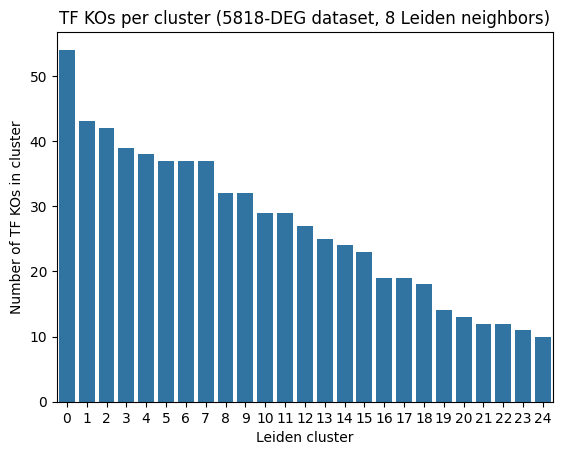

In [ ]:
plot_n_perts_per_cluster(n_perts_per_cluster_5818_8, "TF KOs per cluster (5818-DEG dataset, 8 Leiden neighbors)")

In [ ]:
# with pd.ExcelWriter("/home/ranwyl/results_tf_project/tf_kos_in_cluster_5818.xlsx") as writer:
#     perts_in_cluster_5818.to_excel(writer, sheet_name="TF KOs per cluster", index=False)

With 10 Leiden neighbors

In [4]:
# mde_5818_10 = tf_compute_MDE(adata_5818, label_points=False, spectral=True, leiden_neighbors=10)

In [ ]:
_, _, _, _, embedding_df_5818_10 = mde_5818_10
perts_in_cluster_5818_10 = gene_targets_per_cluster(embedding_df_5818_10)
perts_in_cluster_5818_10.head()

0        1       2         3       4      5       6        7        8   \
0   ARID2    AKAP8     AHR  ARHGAP35  ARID3A   AIRE   ADNP2   AKAP8L      ERF   
1    ARNT    ASCL5   ATMIN    BARHL1  ARID3B  ASH1L   ATF6B   CAMTA2      ERG   
2  BHLHA9  BHLHA15   CEBPD     BARX1   ASCL3  BCL6B   DEAF1     CBX2     FOSB   
3  CC2D1A   DMRTA2  CHAMP1     CXXC1   CREB5   DLX6  DMRTC2  CREB3L4  GATAD2A   
4  CCDC17     EBF3     CRX     DOT1L    EBF2  EPAS1    ELK1    DACH2    HNF1B   

      9   ...       11       12     13       14     15     16       17     18  \
0  AEBP1  ...    BAZ2A    ASCL1  DMRT3   ANKZF1  ATOH1  FOXM1  BHLHE41    ARX   
1  ARNT2  ...  BHLHE22  FLYWCH1  GATA1   CREBL2  CENPB  FOXN4    ESRRA  CTCFL   
2   CREM  ...  BHLHE40     HMX2    HDX    FOXI2  CENPS   GBX1    IKZF4    EHF   
3   ESR2  ...      BSX   HOXD13   IRX5    FOXJ1    DR1   HES6     LHX9   ESX1   
4  FOXD4  ...     CDX1     MYF6  MYPOP  GATAD2B  DRAP1  HMGN3     NFX1  FOSL1   

       19     20  
0   ASCL2  BACH2  
1   FOXH1  FOXO1  
2  MTERF3   HHEX  
3  MTERF4   RARB  
4  NFE2L3    SP2  

[5 rows x 21 columns]

In [ ]:
perts_in_cluster_5818_10.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5818_degs_10_nbrs.csv")

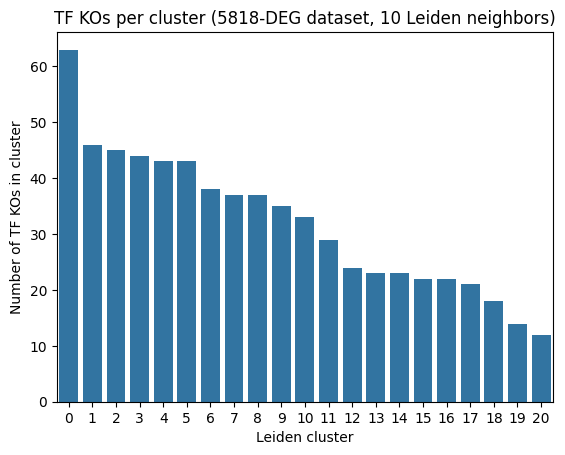

In [ ]:
n_perts_per_cluster_5818_10 = perts_in_cluster_5818_10.nunique().tolist()
plot_n_perts_per_cluster(n_perts_per_cluster_5818_10, "TF KOs per cluster (5818-DEG dataset, 10 Leiden neighbors)")

### Compare TF KO cluster membership between two datasets

To ensure that TF KO cluster membership reflects the underlying biology, we want to make sure the same TF KOs cluster together regardless of the gene set used. We will compare the 5818-DEG clusters with the 2000-HVG clusters. We will use the Jaccard index (intersection size divided by union size) as a metric of cluster similarity.

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
clusters_5818_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5818_degs_8_nbrs.csv", index_col=0)
clusters_5818_10 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5818_degs_10_nbrs.csv", index_col=0)
clusters_2000_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_8_nbrs.csv", index_col=0)
clusters_2000_10 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_10_nbrs.csv", index_col=0)

In [ ]:
clusters_5818_8.head()

0      1        2      3       4        5        6        7      8  \
0   ARID2   AIRE  BHLHE41  DMRT3   ADNP2    ASCL5      ERF   AKAP8L  ASH1L   
1    ARNT  ATOH7    ESRRA  FOXD4   ATF6B  BHLHA15      ERG   CAMTA2  BCL6B   
2  BHLHA9  CEBPB    FOXM1  FOXE3   DEAF1   DMRTA2     FOSB     CBX2   DLX6   
3  CC2D1A  DMBX1    FOXN4  GATA1  DMRTC2     EBF3  GATAD2A  CREB3L4  EPAS1   
4  CCDC17   ELF3     GBX1    HDX    ELK1    FOXA1    HNF1B    DACH2  FOXK2   

        9       10        11     12        13       14     15      16      17  \
0     AHR    BAZ2A  ARHGAP35  AEBP1    ARID3B    ASCL1  ATOH1  ARID3A   AKAP8   
1   ATMIN  BHLHE22     BARX1  ARNT2     ASCL3  FLYWCH1  CENPB   CREB5  BARHL1   
2  CHAMP1  BHLHE40     CXXC1  CEBPD      EBF2     HMX2  CENPS   GPBP1   GATA2   
3    DLX4      BSX     DOT1L    CRX  GTF2IRD1   HOXD13    DR1   GRHL2    HSF2   
4   DNMT1     CDX1      E2F4  DMRT2     JAZF1     MYF6  DRAP1    HIC1    NFIB   

      18      19      20     21      22       23      24  
0    ARX   ASCL2  ANKZF1  BACH2    CREM   CREBL2   CEBPE  
1  CTCFL   FOXH1   FOXI2  FOXO1    ESR2  GATAD2B  CSRNP2  
2    EHF  MTERF3   FOXJ1   HHEX   GATA3  MSANTD4   ZBTB6  
3   ESX1  MTERF4  POU3F3   RARB  NKX6-2     PAX9  ZBTB21  
4  FOSL1  NFE2L3   PPARA    SP2   NR1I3    ZNF12    ZFP1

In [ ]:
def compare_cluster_dfs(df1, df1_name, df2, df2_name):
    """
    Given two DataFrames where each column represents a TF KO cluster, 
    compare each TF KO cluster in df1 to each TF KO cluster in df2 using Jaccard similarity. 
    Output two DataFrames, one recording the Jaccard similarity
    and one recording the size of the set intersection between the two clusters.
    """
    dict1 = {int(col): df1[col].tolist() for col in df1.columns}
    dict2 = {int(col): df2[col].tolist() for col in df2.columns}
    jaccard_array = np.zeros((len(dict1), len(dict2)))
    intersection_array = np.zeros((len(dict1), len(dict2)), dtype=int)
    for i, perts1 in sorted(dict1.items()):
        set1 = set(perts1)
        for j, perts2 in sorted(dict2.items()):
            set2 = set(perts2)
            # Compute Jaccard index
            intersection = len(set1.intersection(set2))
            union = len(set1.union(set2))
            jaccard_array[i, j] = round(intersection/union, 3) if union != 0 else 0
            # Record intersection
            intersection_array[i, j] = intersection
    # Create DataFrame
    row_names = [f"{df1_name}_CL_{i}" for i in range(len(dict1))]
    col_names = [f"{df2_name}_CL_{j}" for j in range(len(dict2))]
    jaccard_df = pd.DataFrame(jaccard_array, columns=col_names, index=row_names)
    intersection_df = pd.DataFrame(intersection_array, columns=col_names, index=row_names)
    return jaccard_df, intersection_df

In [ ]:
jaccard_8, intersection_8 = \
    compare_cluster_dfs(clusters_5818_8, "DEG", clusters_2000_8, "HVG")

In [ ]:
# Highlight the maximum value in each row
# jaccard_comparison.style.highlight_max(axis=1, color="yellow").format("{:.3f}")

In [ ]:
# intersection_comparison.style.highlight_max(axis=0, color="lightgreen")

In [ ]:
def cluster_heatmap(cluster_comparison_df, rows_name, cols_name, title, v_min, v_max, color_map="rocket_r"):
    row_names = [i for i in range(cluster_comparison_df.shape[0])]
    col_names = [j for j in range(cluster_comparison_df.shape[1])]
    df = pd.DataFrame(cluster_comparison_df.values, columns=col_names, index=row_names)
    if v_min or v_max:
        ax = sns.heatmap(df, vmin=v_min, vmax=v_max, cmap=color_map)
    else:
        ax = sns.heatmap(df, cmap=color_map)
    ax.set_ylabel(rows_name)
    ax.set_xlabel(cols_name)
    ax.set_title(title)

In [5]:
# p = cluster_heatmap(jaccard_8, rows_name="5818-DEG Clusters", cols_name="2000-HVG Clusters",
#     title="Jaccard Index of TF KO Clusters (5818 DEGs vs. 2000 HVGs)", v_min=0, v_max=1, color_map="rocket_r")

In [6]:
# p = cluster_heatmap(intersection_8, rows_name="5818-DEG Clusters", cols_name="2000-HVG Clusters",
#     title="Intersection of TF KO Clusters (5818 DEGs vs. 2000 HVGs)", v_min=0, v_max=20, color_map="mako_r")

Now we will compare to the Mali Lab strong perturbation dataset clusters, specifically the TF KOs in each cluster. These clusters were generated using the TF project deterministic code that seeded all nondeterministic functions.

In [ ]:
mali_clusters = pd.read_csv("/home/ranwyl/results_tf_project/mali_lab_tf_ko_clusters_deterministic.csv", index_col=0)

In [ ]:
mali_clusters.head()

0   1       2      3       4        5       6       7     8       9  \
0    FOXK1 NaN  BHLHA9  ASCL5   DMRT2   ANKZF1    E2F4    CREM  ELK1  AKAP8L   
1    GATA5 NaN    DUXA  ATOH1   NFIL3   CSRNP2    ETS1   FOXK2   NaN   IKZF5   
2  MSANTD4 NaN    ESR2  ESRRA   ZNF16    FOXA1   FOXH1  ZNF563   NaN  TCF7L2   
3     NOTO NaN    ETS2  FOXE3  ZNF735  GATAD2A  POU2F1     NaN   NaN   ZNF44   
4    NR0B1 NaN    ISL1  GLIS3     NaN    HNF1B   SMAD4     NaN   NaN     NaN   

        10      11      12       13      14      15      16      17       18  \
0  CREB3L4    CDX1  ZNF583  ZNF705D    CBX2    DLX4     HLF  MTERF4     MXD1   
1    ESRRB   NFKB2     NaN      NaN   DOT1L  SETDB1   SALL4     NaN  NEUROG3   
2  L3MBTL4  POU4F3     NaN      NaN    ETV5  ZNF205   SNAI1     NaN    THAP8   
3    PATZ1    TCF3     NaN      NaN  KCNIP3  ZNF408   TBPL1     NaN   ZBTB22   
4      NaN  ZBTB34     NaN      NaN   NFXL1     NaN  ZNF614     NaN   ZNF75D   

       19       20      21      22      23      24  25  26      27      28  \
0    ESR1  FOXD4L5  MTERF3  BARHL1   GRHL2   ASH1L NaN NaN  ZNF706  LIN28B   
1   FOXJ2     NME2  ZBTB41     NaN  THAP12     BSX NaN NaN     NaN     NaN   
2    HES7      SRF     NaN     NaN    USF2  CREBL2 NaN NaN     NaN     NaN   
3    MTF2   ZNF510     NaN     NaN     NaN    FOSB NaN NaN     NaN     NaN   
4  NKX2-4      NaN     NaN     NaN     NaN   FOXS1 NaN NaN     NaN     NaN   

   29        30      31      32      33      34       35      36     37  38  \
0 NaN      EBF2    SOX4   ATMIN   BARX1  NKX6-2    PHF20  ZBTB42    DR1 NaN   
1 NaN  GTF2IRD1  ZNF219  CHAMP1   CENPB     SP1   POU3F2  ZNF549  DRAP1 NaN   
2 NaN    SNAPC5     NaN   DNMT1   GTF2I     NaN   POU5F1     NaN    NaN NaN   
3 NaN    ZNF383     NaN    JUNB  ZNF200     NaN  POU5F1B     NaN    NaN NaN   
4 NaN    ZNF420     NaN   PITX3  ZNF326     NaN      NaN     NaN    NaN NaN   

         39  40       41      42      43  
0  ARHGAP35 NaN     KLF1  HOXD13  ZNF253  
1      ETV1 NaN    NANOG   NR1D1     NaN  
2      HHEX NaN  NANOGP8    RBPJ     NaN  
3       NaN NaN   PRDM14   TCF12     NaN  
4       NaN NaN     PURG  ZNF396     NaN

Reorder Mali lab columns from longest to shortest before plotting

In [ ]:
def reorder_columns(df):
    """
    Reorder columns from longest to shortest and remove columns with < 2 items.
    """
    # Create tuples (column_name, length)
    col_lengths = [(i, col.count()) for i, col in df.items()]
    # Sort tuples by length
    col_lengths = list(sorted(col_lengths, key=lambda x: x[1], reverse=True))
    # Reorder columns
    col_order = [col[0] for col in col_lengths if col[1] > 1]
    new_df = df.loc[:, col_order]
    # Create dict for renumbering columns
    col_renumbering = {col_order[i]: i for i in range(len(col_order))}
    # Renumber columns
    new_df = new_df.rename(columns=col_renumbering)
    return new_df, col_renumbering

In [ ]:
mali_clusters_reordered, mali_columns_reordered = reorder_columns(mali_clusters)
mali_clusters_reordered

0        1       2        3       4        5       6       7   \
0    ANKZF1   BHLHA9   ASCL5    ASH1L    CDX1    FOXK1    CBX2    E2F4   
1    CSRNP2     DUXA   ATOH1      BSX   NFKB2    GATA5   DOT1L    ETS1   
2     FOXA1     ESR2   ESRRA   CREBL2  POU4F3  MSANTD4    ETV5   FOXH1   
3   GATAD2A     ETS2   FOXE3     FOSB    TCF3     NOTO  KCNIP3  POU2F1   
4     HNF1B     ISL1   GLIS3    FOXS1  ZBTB34    NR0B1   NFXL1   SMAD4   
5      MITF     JRKL    HES6      HDX  ZNF462     THRA   NR1I3  TCF7L1   
6   NANOGNB    MEOX2    IRX5     OSR2  ZNF572    TIGD6  PKNOX2  ZNF552   
7   NEUROD4  ONECUT2    MAFG    PCGF6  ZNF616    ZFP30   SOX12  ZNF783   
8      PHF1    PA2G4   NR3C2   PLSCR1  ZNF660    ZNF32   THAP5     NaN   
9     PPARD    PROX2  PRDM12   POU3F3  ZNF732      NaN     NaN     NaN   
10   SETDB2     SHOX     SCX    PRDM8  ZNF888      NaN     NaN     NaN   
11    SHOX2      SRY   TBX18   ZFP69B     NaN      NaN     NaN     NaN   
12    TBX20     TMF1  ZBTB39   ZNF487     NaN      NaN     NaN     NaN   
13    TBX21  TSC22D1   ZFP41   ZNF573     NaN      NaN     NaN     NaN   
14    THAP6   ZBTB33  ZNF222  ZSCAN18     NaN      NaN     NaN     NaN   
15     THRB     ZHX1  ZNF394  ZSCAN25     NaN      NaN     NaN     NaN   
16    TIGD2    ZNF48  ZNF395      NaN     NaN      NaN     NaN     NaN   
17     ZFP1   ZNF256  ZNF594      NaN     NaN      NaN     NaN     NaN   
18    ZFP90  ZNF280C  ZNF844      NaN     NaN      NaN     NaN     NaN   
19   ZNF267   ZNF490     NaN      NaN     NaN      NaN     NaN     NaN   
20   ZNF300   ZNF514     NaN      NaN     NaN      NaN     NaN     NaN   
21   ZNF418   ZNF551     NaN      NaN     NaN      NaN     NaN     NaN   
22   ZNF589   ZNF554     NaN      NaN     NaN      NaN     NaN     NaN   
23   ZNF619   ZNF658     NaN      NaN     NaN      NaN     NaN     NaN   
24   ZNF687   ZNF692     NaN      NaN     NaN      NaN     NaN     NaN   
25   ZNF708   ZNF701     NaN      NaN     NaN      NaN     NaN     NaN   
26   ZNF713  ZNF705A     NaN      NaN     NaN      NaN     NaN     NaN   
27  ZNF780A      NaN     NaN      NaN     NaN      NaN     NaN     NaN   
28   ZNF823      NaN     NaN      NaN     NaN      NaN     NaN     NaN   
29  ZSCAN32      NaN     NaN      NaN     NaN      NaN     NaN     NaN   

        8        9       10      11       12      13        14      15  \
0     ESR1     MXD1     HLF   ATMIN     KLF1  HOXD13      EBF2   BARX1   
1    FOXJ2  NEUROG3   SALL4  CHAMP1    NANOG   NR1D1  GTF2IRD1   CENPB   
2     HES7    THAP8   SNAI1   DNMT1  NANOGP8    RBPJ    SNAPC5   GTF2I   
3     MTF2   ZBTB22   TBPL1    JUNB   PRDM14   TCF12    ZNF383  ZNF200   
4   NKX2-4   ZNF75D  ZNF614   PITX3     PURG  ZNF396    ZNF420  ZNF326   
5    NR4A3   ZNF268  ZNF683     VDR   ZNF423  ZNF521       NaN     NaN   
6    THAP7  ZNF354A     NaN     NaN      NaN     NaN       NaN     NaN   
7   ZNF461      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
8      NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
9      NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
10     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
11     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
12     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
13     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
14     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
15     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
16     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
17     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
18     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
19     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
20     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
21     NaN      NaN     NaN     NaN      NaN     NaN       NaN     NaN   
22     NaN  

In [ ]:
jaccard_deg_mali_reordered, intersection_deg_mali_reordered = \
    compare_cluster_dfs(clusters_5818_8, "DEG", mali_clusters_reordered, "Mali_r")

In [7]:
# p = cluster_heatmap(jaccard_deg_mali_reordered, rows_name="5818-DEG Clusters", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
#     title="Jaccard Index of TF KO Clusters (5818 DEGs vs. Mali Lab Study)", v_min=0, v_max=1, color_map="rocket_r")

In [8]:
# p = cluster_heatmap(intersection_deg_mali_reordered, rows_name="5818-DEG Clusters", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
#     title="Intersection of TF KO Clusters (5818 DEGs vs. Mali Lab Study)", v_min=0, v_max=20, color_map="mako_r")

In [ ]:
jaccard_hvg_mali_reordered, intersection_hvg_mali_reordered = \
    compare_cluster_dfs(clusters_2000_8, "HVG", mali_clusters_reordered, "Mali_r")

In [9]:
# p = cluster_heatmap(jaccard_hvg_mali_reordered, rows_name="2000-HVG Clusters", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
#     title="Jaccard Index of TF KO Clusters (2000 HVGs vs. Mali Lab Study)", v_min=0, v_max=1, color_map="rocket_r")

In [10]:
# p = cluster_heatmap(intersection_hvg_mali_reordered, rows_name="2000-HVG Clusters", cols_name="Mali Lab TF KOs in Clusters Ordered by Size",
#     title="Intersection of TF KO Clusters (2000 HVGs vs. Mali Lab Study)", v_min=0, v_max=20, color_map="mako_r")

## (OLD) Overrepresentation analysis (ORA)

We seek to functionally annotate each TF KO cluster using overrepresentation analysis (ORA), which is performed on a user-submitted list of DEGs. For any given TF KO cluster, every TF KO in the cluster will have its own DEGs, and we want to generate a set of upregulated genes and a set of downregulated genes that represents the cluster.

Here we will try the following approach for each TF KO cluster. First, read in the full DE results, subset the results for the TF KOs in the cluster, and filter only genes with p-adj < 0.05. Next, for each TF KO, take the top n upregulated genes (i.e. the n genes with the highest LFC). Then take the intersection of the n genes per TF KO.

We will try this with the clusters from the MDE generated using 5087 DEGs as features and 8 nearest neighbors in the neighborhood graph for Leiden clustering.

Read in differential expression analysis results from TF KO and NTC dataset (85% sample fraction, LFC shrinkage performed with adapt=False)

In [ ]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [ ]:
de_results.head()

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG            5.197361              0.603388     0.610262    1.249251   
A1BG-AS1        2.117718              0.544581     0.911720    0.986719   
A1CF                 NaN                   NaN          NaN         NaN   
A2M             0.349860             -0.390388     1.225741   -0.692164   
A2M-AS1         0.311871              0.340470     1.828676    0.582373   

          DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG          0.211573         NaN       3.271476            -0.219247   
A1BG-AS1      0.323780         NaN       0.659727            -0.021330   
A1CF               NaN         NaN            NaN                  NaN   
A2M           0.488835         NaN       0.826464            -0.187075   
A2M-AS1       0.560315         NaN       0.976668             0.678086   

          OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG        0.719732  -0.436204  ...     0.928560   -1.333630      0.182325   
A1BG-AS1    1.140542  -0.048274  ...     1.246887   -0.863337      0.387952   
A1CF             NaN        NaN  ...          NaN         NaN           NaN   
A2M         1.073352  -0.401825  ...     1.930966    1.844563      0.065101   
A2M-AS1     1.342768   1.186024  ...     1.135588   -0.197266      0.843620   

          ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  FAM200B_lfcSE  \
A1BG         0.93709          3.431164               -0.557770       0.756780   
A1BG-AS1     0.93709          0.627773               -0.762906       1.404104   
A1CF             NaN               NaN                     NaN            NaN   
A2M          0.93709          0.643332                0.025018       1.154267   
A2M-AS1      0.93709          0.823219                0.181208       1.157592   

          FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG         -1.045982        0.295569      0.943485  
A1BG-AS1     -1.112549        0.265902      0.943485  
A1CF               NaN             NaN           NaN  
A2M           0.060363        0.951867      0.979964  
A2M-AS1       0.401337        0.688172      0.943485  

[5 rows x 3912 columns]

In [ ]:
clusters_5087_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5087_degs_8_nbrs.csv", header=0, index_col=0)

In [ ]:
clusters = clusters_5087_8

In [ ]:
clusters_strong = pd.read_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_degs_8nbrs.csv")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
def get_cluster_degs(cluster_df, de_df, cluster_num, n_degs_per_tf_ko, padj_threshold, lfc_threshold):
    """
    Generate a set of DEGs with p-adj < padj_threshold and |LFC| > lfc_threshold 
    for cluster number cluster_num in cluster_df, based on the DE results of de_df.
    """
    # Change cluster number to string
    if type(cluster_num) is not str:
        cluster_num = str(cluster_num)
    # Get TF KOs in cluster column (excluding NaN values)
    cluster_tf_ko_list = cluster_df[cluster_num][cluster_df[cluster_num].notna()].tolist()
    # Filter DE DF to only TF KOs
    de_df_cols = [col for col in de_df.columns if any(f"{tf_ko}_" in col for tf_ko in cluster_tf_ko_list)]
    de_df = de_df[de_df_cols]
    # Get top n upregulated and top n downregulated DEGs per TF KO
    up_degs_sets = list()
    down_degs_sets = list()
    n_degs_padj = list()
    n_degs_lfc = list()
    for tf_ko in cluster_tf_ko_list:
        tf_ko_de_df = de_df.filter(like=f"{tf_ko}_", axis=1)
        # Filter by p-adj and LFC thresholds
        tf_ko_de_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_padj"] < padj_threshold]
        n_degs_padj.append(tf_ko_de_df.shape[0]) # Number of genes that pass p-adj threshold
        tf_ko_de_df = tf_ko_de_df[abs(tf_ko_de_df[f"{tf_ko}_log2FoldChange"]) > lfc_threshold]
        n_degs_lfc.append(tf_ko_de_df.shape[0]) # Number of genes that pass LFC threshold
        # Top upregulated DEGs
        tf_ko_up_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] > 0]
        tf_up_degs = tf_ko_up_deg_df.nlargest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        up_degs_sets.append(set(tf_up_degs))
        # Top downregulated DEGs
        tf_ko_down_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] < 0]
        tf_down_degs = tf_ko_down_deg_df.nsmallest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        down_degs_sets.append(set(tf_down_degs))
    # Create DataFrames to display DEG results
    df_results = [n_degs_padj, n_degs_lfc, 
                  [len(s) for s in up_degs_sets], [len(s) for s in down_degs_sets]]
    df_index = ["# genes with padj < 0.05", f"# genes with padj < 0.05 and |LFC| > {lfc_threshold}", "# upregulated DEGs", "# downregulated DEGs"]
    results_df = pd.DataFrame(df_results, columns=cluster_tf_ko_list, index=df_index)
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs in intersection of all sets")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs in intersection of all sets")
    return results_df, up_degs_sets, down_degs_sets

In [ ]:
def filter_deg_sets(up_degs_sets, down_degs_sets, cutoff):
    up_degs_sets = [s for s in up_degs_sets if len(s) > cutoff]
    down_degs_sets = [s for s in down_degs_sets if len(s) > cutoff]
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs found")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs found")

In [ ]:
test_df, test_up, test_down = get_cluster_degs(clusters, de_results, cluster_num=0,
                                               n_degs_per_tf_ko=1000, padj_threshold=0.05, lfc_threshold=0.25)

0 upregulated DEGs in intersection of all sets
0 downregulated DEGs in intersection of all sets


In [ ]:
display(test_df)

AIRE  ARX  BHLHA9  DBX2  ELK1  \
# genes with padj < 0.05                     50    3     149    43     3   
# genes with padj < 0.05 and |LFC| > 0.25    48    2     102    34     3   
# upregulated DEGs                           17    1      30     9     2   
# downregulated DEGs                         31    1      72    25     1   

                                           FOSB  FOXN2  GATA1  GATA5  GSC  \
# genes with padj < 0.05                      2     33     17    203   63   
# genes with padj < 0.05 and |LFC| > 0.25     1     26     17    182   60   
# upregulated DEGs                            1      4      9     47   19   
# downregulated DEGs                          0     22      8    135   41   

                                           IRF8  IRX1  JRKL  MLXIP  MSX2  \
# genes with padj < 0.05                      0    28     1      7    22   
# genes with padj < 0.05 and |LFC| > 0.25     0    28     1      6    15   
# upregulated DEGs                            0     7     0      3     2   
# downregulated DEGs                          0    21     1      3    13   

                                           MYCL  ONECUT2  PAX2  POU3F3  RUNX3  \
# genes with padj < 0.05                      0       12    28     129     43   
# genes with padj < 0.05 and |LFC| > 0.25     0       10    20     122     32   
# upregulated DEGs                            0        6     8      30     13   
# downregulated DEGs                          0        4    12      92     19   

                                           SETDB2  SHOX2  STAT5A  TET2  TFEC  \
# genes with padj < 0.05                        5    206       0    28     0   
# genes with padj < 0.05 and |LFC| > 0.25       5    160       0    26     0   
# upregulated DEGs                              3     48       0     4     0   
# downregulated DEGs                            2    112       0    22     0   

                                           THAP6  TIGD7  TP73  ZBTB39  ZFP30  \
# genes with padj < 0.05                     199     82     8      21     18   
# genes with padj < 0.05 and |LFC| > 0.25    153     71     8      17     12   
# upregulated DEGs                            60     29     3       3      7   
# downregulated DEGs                          93     42     5      14      5   

                                           ZFP41  ZNF32  ZNF57  ZNF143  \
# genes with padj < 0.05                     127     76      5       7   
# genes with padj < 0.05 and |LFC| > 0.25     65     67      5       7   
# upregulated DEGs                            28     19      1       3   
# downregulated DEGs                          37     48      4       4   

                                           ZNF200  ZNF212  ZNF256  ZNF341  \
# genes with padj < 0.05                      146      24      79       7   
# genes with padj < 0.05 and |LFC| > 0.25     116      24      79       6   
# upregulated DEGs                             36       4      20       4   
# downregulated DEGs                           80      20      59       2   

                                           ZNF398  ZNF416  ZNF441  ZNF461  \
# genes with padj < 0.05                        2       0     309      44   
# genes with padj < 0.05 and |LFC| > 0.25       2       0     290      42   
# upregulated DEGs                              1       0      88      18   
# downregulated DEGs                            1       0     202      24   

                                           ZNF511  ZNF556  ZNF610  ZNF684  \
# genes with padj < 0.05                       63       1      10     163   
# genes with padj < 0.05 and |LFC| > 0.25      63       1      10     156   
# upregulated DEGs                             20       1       7      29   
# downregulated DEGs                           43       0       3     127   

                                           ZNF728  ZNF735  ZNF891  ZSCAN32  
# genes with padj < 0.05                       36      31       0       63  
# ge

In [ ]:
test_df2, test_up2, test_down2 = get_cluster_degs(clusters_strong, de_results, cluster_num=0,
                                               n_degs_per_tf_ko=1000, padj_threshold=0.05, lfc_threshold=0.25)

0 upregulated DEGs in intersection of all sets
0 downregulated DEGs in intersection of all sets


In [ ]:
display(test_df2)

CBX2  EPAS1  FOXK1  GATA6  GSC  \
# genes with padj < 0.05                    112    183    114     33   63   
# genes with padj < 0.05 and |LFC| > 0.25    85    147    106     28   60   
# upregulated DEGs                           22     32     37     14   19   
# downregulated DEGs                         63    115     69     14   41   

                                           HES7  KLF6  MEIS3  MEOX2  NKX2-4  \
# genes with padj < 0.05                     33   118    123     30     246   
# genes with padj < 0.05 and |LFC| > 0.25    31    97     62     27     219   
# upregulated DEGs                            7    32     20     16      99   
# downregulated DEGs                         24    65     42     11     120   

                                           NKX6-1  PA2G4  PAX6  RBCK1  REPIN1  \
# genes with padj < 0.05                       67    235    56     50      45   
# genes with padj < 0.05 and |LFC| > 0.25      59    234    48     34      31   
# upregulated DEGs                             20     81    10     17      17   
# downregulated DEGs                           39    153    38     17      14   

                                           REST  TBX1  TIGD7  TMF1  ZFP41  \
# genes with padj < 0.05                    139    10     82    20    127   
# genes with padj < 0.05 and |LFC| > 0.25   112     9     71    20     65   
# upregulated DEGs                           42     7     29     5     28   
# downregulated DEGs                         70     2     42    15     37   

                                           ZNF16  ZNF80  ZNF222  ZNF280C  \
# genes with padj < 0.05                      58     71     109       45   
# genes with padj < 0.05 and |LFC| > 0.25     49     70      87       43   
# upregulated DEGs                            20     18      28        9   
# downregulated DEGs                          29     52      59       34   

                                           ZNF354A  ZNF462  ZNF571  ZNF573  \
# genes with padj < 0.05                        60     225     148      60   
# genes with padj < 0.05 and |LFC| > 0.25       31     188     144      50   
# upregulated DEGs                               8      87      34      16   
# downregulated DEGs                            23     101     110      34   

                                           ZNF648  ZNF658  ZNF764  ZNF844  
# genes with padj < 0.05                       58     181      22      54  
# genes with padj < 0.05 and |LFC| > 0.25      49     154      22      50  
# upregulated DEGs                             15      65       2      13  
# downregulated DEGs                           34      89      20      37

# ORA with gProfiler package

In [ ]:
# Run ORA using gProfiler and return DF of full results
def ora_gprofiler_full(cluster_dict, sources=[]):
        # Helper function to run ORA on single gene list using gProfiler
        def ora_gprofiler_query(gene_list: list, sources):
                gprof = GProfiler(return_dataframe=True)
                gp_df = gprof.profile(organism='hsapiens', 
                                query=gene_list, 
                                sources=sources)
                return gp_df
        
        # Run ORA on all clusters and save results in DF
        all_dfs_list = list()
        cluster_nums = sorted(list(cluster_dict.keys()))
        for i in tqdm(range(len(cluster_nums)), desc="Processing cluster number"):
                cluster_genes = list(cluster_dict[i])
                ora_df_full = ora_gprofiler_query(cluster_genes, sources)
                # Add cluster number
                ora_df_full.insert(0, "cluster", [i]*ora_df_full.shape[0])
                all_dfs_list.append(ora_df_full)
        full_df = pd.concat(all_dfs_list)
        return full_df

def filter_gprofiler_results(full_df, gene_sets=None, n_top_results=5, columns=5):
    full_df = full_df.rename(columns={"native":"ID"})
    if gene_sets:
        full_df = full_df[full_df["source"].isin(gene_sets)]
    top_df_list = list()
    for cluster in full_df["cluster"].unique().tolist():
        cluster_df = full_df[full_df["cluster"] == cluster].sort_values("p_value")[:n_top_results]
        top_df_list.append(cluster_df)
    top_df = pd.concat(top_df_list)
    if type(columns) == int:
        filtered_df = top_df.iloc[:,:columns]
    elif type(columns) == list:
        filtered_df = top_df[columns]
    return filtered_df

def plot_shared_top_pathways_gprofiler(filtered_df, n_pathways=5, show_id=False, color=None, title=None):
    xmax = filtered_df["cluster"].nunique()
    if show_id:
        filtered_df["name and source"] = filtered_df["name"] + " (" + filtered_df["source"] + ")"
        filtered_df = filtered_df['name and source'].value_counts().head(n_pathways)
    else:
        filtered_df = filtered_df['name'].value_counts().head(n_pathways)
    fig, ax = plt.subplots(figsize=(6,4))
    if color:
        ax = sns.barplot(filtered_df, orient="h", facecolor=color)
    else:
        ax = sns.barplot(filtered_df, orient="h")
    plt.rcParams.update({"font.size":14})
    ax.set_xlabel("Number of clusters", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlim(0, xmax)
    ax.set_title(title, fontsize=14)